## Neural Computing - Comparing Convoluted Neural Networks with Multi-layer Perceptron in Image Classification
#### Author - Jakob Brown

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transform
from torch.utils.data import random_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import skorch
import time
from sklearn.model_selection import GridSearchCV

In [2]:
torch.cuda.is_available()

False

### Importing data

The Cifar 10 data set is readily available as part of pytorch. The following cell loads both the training and test set and converts them in to tensors, as well as normalizing the values of each of the 3 RGB channels between 1 and 0, using the mean and standard deviations of each channel, which were obtained at: https://gist.github.com/weiaicunzai/e623931921efefd4c331622c344d8151

In [3]:
transformer = transform.Compose([transform.ToTensor(),
                                  transform.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

data = torchvision.datasets.CIFAR10(root='normalized_data/', train = True, download=True, transform=transformer)
test_set = torchvision.datasets.CIFAR10(root='normalized_data/', train=False, transform=transformer)

Files already downloaded and verified


The data is now downloaded and in tensor format. Next, as the dataset is too large to be used at once, data loaders will be initialized to handle the data in batches of 50.

In [4]:
# number of classes

num_classes = len(data.classes)
print(num_classes)
print(data.classes)

10
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
# size of the data set

print(len(data))
print(len(test_set))

50000
10000


### Creating train/validation/test sets and respective data loaders for each

In [8]:
# simple version, to use as input for skorch(scikit-learn wrapper for pytorch)

xTrain = data.data
yTrain = data.targets
xTest = test_set.data
yTest = test_set.targets

In [9]:
# splitting training set to reserve a tenth for validation purposes

training_size = 45000
validation_size = 5000

train_set, validation_set = random_split(data, [training_size, validation_size])

In [11]:
# initializing data loaders for each set in order to process the large amounts of data in batches for efficiency

train_loader = torch.utils.data.DataLoader(train_set, batch_size = 32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = torch.utils.data.DataLoader(validation_set, batch_size = 64, shuffle = False, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 64, shuffle = False, num_workers=4, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


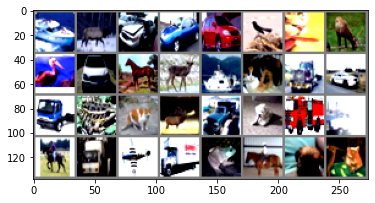

 ship,  deer, automobile, automobile, automobile,  bird,   cat,  deer,  bird, automobile, horse,  deer,  ship,   cat, truck, automobile, truck,  frog,   cat,  deer, truck,   dog, truck, truck, horse, truck, airplane, truck,  frog, horse,   dog,   cat


In [24]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(', '.join('%5s' % data.classes[labels[j]] for j in range(32)))


In [25]:
# dimensions of each image

pic, _ = data[np.random.randint(1, 5000)]
print(pic.shape)

torch.Size([3, 32, 32])


As can be seen above, the dimensions for the images are 3, 32, 32. 3 denotes the 3 RGB channels, in that order, while the image itself is made up of 32x32 pixels. Not the most high definition, but nonetheless discernable. There are 10 classes, listed above, and there are 50,000 images in the training set, thus each class has 5000 examples. The test set consists of 10,000 examples, consisting of 1000 of each example.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


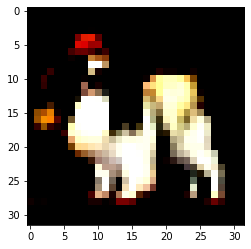

In [26]:
# displaying an exemplar image from the data
# permutation necessary as the matplotlib function imshow takes the number of dimensions last ([0]) rather than first

plt.imshow(pic.permute(1, 2, 0));

# <font color='red'> MLP Hyperparameters</font>

In [12]:
# variables #
num_epochs = 200 # <--- # hyperparameter #

lr = 1e-4 # <--- # hyperparameter #

criterion = nn.CrossEntropyLoss() # different loss functions are available but this one is ackknowledged for classification

dropout = 0.2 # <--- hyperparameter

batch_size = 32

# mlp number of nodes

nodes1 = 1500
nodes2 = 1000
nodes3 = 500


# learning rate initially set to 3e-4, which is recommended as not too slow or too large so that it would miss
# error minima/subtle fluctuation in performance*

Now to build the first NN, starting with the multi-layer perceptron (MLP)

In [14]:
print(train_loader.batch_size)

32


### Defining the MLP

In [234]:
# multi-layer perceptron (MLP)

class mlp(nn.Module):
    def __init__(self,
                 dropout = dropout,
                 nodes1 = nodes1,
                 nodes2 = nodes2,    # <--- hyperparameters
                 nodes3 = nodes3
                ): 
        super(mlp, self).__init__()
        self.network = nn.Sequential(
        
        nn.Linear(32 * 32 *3, nodes1),  # 3072 = 32 * 32 * 3 (the dimensions of the input images)
        nn.ReLU(inplace = True),
        nn.Dropout(dropout),
        nn.Linear(nodes1, nodes2),
        nn.ReLU(inplace = True),
        nn.Dropout(dropout),
        #nn.Linear(nodes2, nodes3),
        #nn.ReLU(inplace = True),
        #nn.Dropout(dropout),
        nn.Linear(nodes2, 10)) # 10 output classes
        
    def forward(self, i):
        return self.network(i)         

Now that the networks have been initialized, our models for each can be built from them, in preparation for inputting the Cifar 10 data to them.

### Using <font color='orange'>Skorch</font> to train and evaluate the MLP

Skorch references:
> https://github.com/thomasjpfan/pydata2018_dc_skorch

> https://analyticsindiamag.com/a-beginners-guide-to-skorch-with-code-to-implement-neural-network/


In [27]:
# making the inputs 1-D and floats, and making the target variables a numpy array
# reshaping solution found from http://home.mit.bme.hu/~hadhazi/Oktatas/NN18/dem3/html_demo/CIFAR-10Demo.html

##### MLP wants it like this (below), while cnn wants net.fit(data, yTrain (yTrain made np as below) ####

xTrain = np.reshape(xTrain,(50000,3072))
xTrain = xTrain.astype('float32')

yTrain = np.array([y for x, y in iter(data)])

# 1 Hidden layer

To clarify, a gridsearch was conducted to identify the best performing hyperparameters for a uni-layer MLP. These hyperparameters, specified below, were then input in to a singular skorch neural net classifier object, the training and validation results of which can be seen below. For 2 and 3 layer MLPs, the gridsearch was simply kept and the best estimator was assigned to a new object which was then described in the same way with the samem training and validation results visualisations.

__parameter grid:__ 

Dropout: [0, 0.1, 0.5]

Learning rate: [0.0001, 0.001, 0.01]

hidden layer nodes: [175, 250, 500, 1000]

SGD momentum: [0.9,0.7, 0.99]

In [199]:
from skorch import NeuralNetClassifier

# defining callbacks to be input in to the skorch classifier

earlystopping = skorch.callbacks.EarlyStopping(monitor = 'valid_acc', lower_is_better = False,
                                               patience = 10, threshold_mode = 'abs')

checkpoint = skorch.callbacks.Checkpoint(monitor = 'valid_acc_best')

# defining the classifier object


mlpskorch = NeuralNetClassifier(
        mlp,
        criterion = nn.CrossEntropyLoss,
        max_epochs = 200,
        lr = lr,
        callbacks = [earlystopping, checkpoint],
        optimizer__momentum = 0.7
        )

unilayer_replication_attempt = mlpskorch.fit(xTrain, yTrain)

  epoch    train_loss    valid_acc    valid_loss    cp      dur
-------  ------------  -----------  ------------  ----  -------
      1        5.4402       0.2116        2.0863     +  12.1676
      2        2.1592       0.2713        2.0115     +  13.3470
      3        2.0956       0.2920        1.9785     +  13.8864
      4        2.0531       0.3162        1.9380     +  14.3636
      5        2.0257       0.3191        1.9041     +  14.8322
      6        2.0056       0.3138        1.8893        15.1393
      7        1.9893       0.3343        1.8688     +  15.0433
      8        1.9717       0.3306        1.8474        15.1619
      9        1.9668       0.3348        1.8515     +  15.2862
     10        1.9482       0.3347        1.8415        15.3902
     11        1.9374       0.3345        1.8255        15.5733
     12        1.9289       0.3507        1.8154     +  15.2134
     13        1.9171       0.3482        1.8060        15.3427
     14        1.9055       0.3551      

In [205]:
sum(unilayer_replication_attempt.history[:, 'dur'])

982.5381309986115

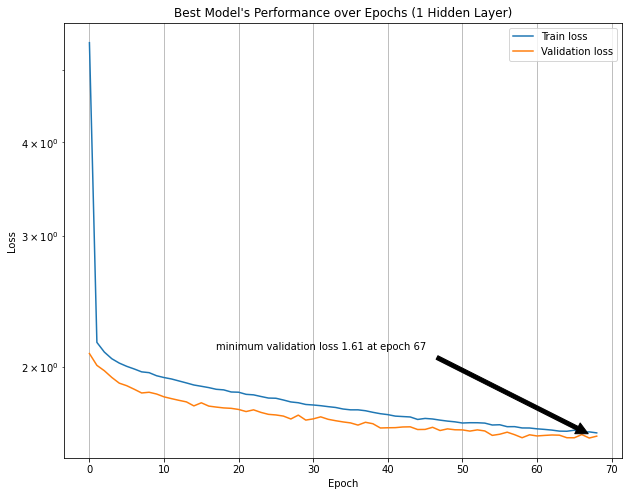

In [201]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()

plt.semilogy(unilayer_replication_attempt.history[:, 'train_loss'], label='Train loss')
plt.semilogy(unilayer_replication_attempt.history[:, 'valid_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# annotating best validation loss score
ymin = min(unilayer_replication_attempt.history[:, 'valid_loss'])
xpos = unilayer_replication_attempt.history[:, 'valid_loss'].index(ymin)
xmin = unilayer_replication_attempt.history[:, 'valid_loss'][xpos]
ax.annotate('minimum validation loss {0} at epoch {1}'.format(str(round(ymin, 2)), str(xpos)),
            xy = (xpos+1, ymin), xytext = (xpos - 50, ymin + 0.5), arrowprops=dict(facecolor='black', shrink=0.05))


plt.title("Best Model's Performance over Epochs (1 Hidden Layer)")
plt.grid()
plt.legend()
plt.show()      

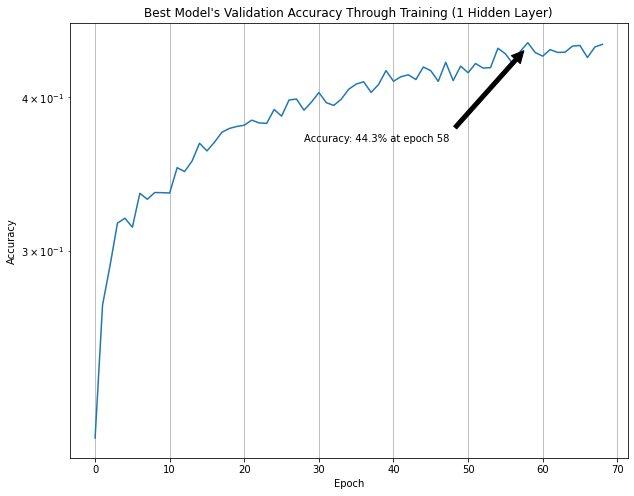

In [204]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()

plt.semilogy(unilayer_replication_attempt.history[:, 'valid_acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

ymax = max(unilayer_replication_attempt.history[:, 'valid_acc'])
xpos = unilayer_replication_attempt.history[:, 'valid_acc'].index(ymax)
xmin = unilayer_replication_attempt.history[:, 'valid_acc'][xpos]
ax.annotate('Accuracy: {0}% at epoch {1}'.format(str(ymax * 100), str(xpos)),
            xy = (xpos, ymax - 0.003), xytext = (xpos - 30, ymax-0.075), arrowprops=dict(facecolor='black', shrink=0.05))


plt.title("Best Model's Validation Accuracy Through Training (1 Hidden Layer)")
plt.grid()
plt.show()    

# 2 Hidden Layers

In [208]:
from skorch import NeuralNetClassifier

# defining callbacks to be input in to the skorch classifier

earlystopping = skorch.callbacks.EarlyStopping(monitor = 'valid_acc', lower_is_better = False,
                                               patience = 10, threshold_mode = 'abs')

checkpoint = skorch.callbacks.Checkpoint(monitor = 'valid_acc_best')

# defining the classifier object


mlpskorch = NeuralNetClassifier(
        mlp,
        criterion = nn.CrossEntropyLoss,
        max_epochs = 200,
        lr = lr,
        callbacks = [earlystopping, checkpoint]
        )



In [209]:
# Specifying parameters to be searched through

params = {'module__dropout': [0, 0.2, 0.5],
          'lr': [1e-4, 1e-3, 1e-2],
          'module__nodes1': [250, 500, 1000],
          'module__nodes2': [500, 1000, 1500], 
          #'module__nodes3': [],
          'optimizer': [torch.optim.SGD, torch.optim.Adam]
          }

gs = GridSearchCV(mlpskorch, params, verbose = 2, cv = 2, scoring = 'accuracy')

In [ ]:
# fitting the model

best_mdl = gs.fit(xTrain, yTrain)

best score:  0.4429
best params:  {'lr': 0.0001, 'module__dropout': 0.2, 'module__nodes1': 1000, 'module__nodes2': 500, 'optimizer': <class 'torch.optim.sgd.SGD'>}


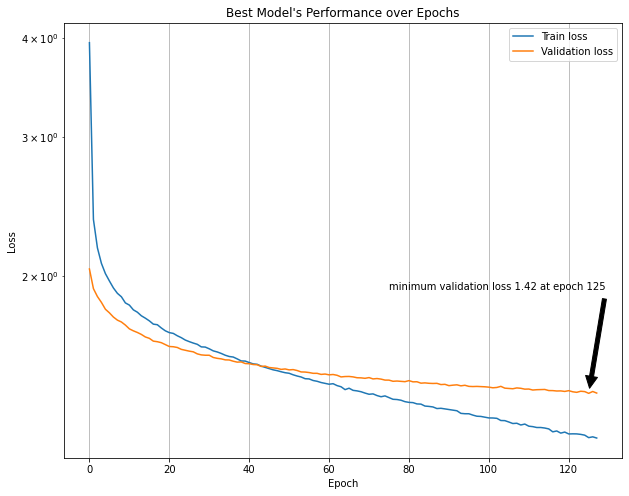

In [167]:
print("best score: ",gs.best_score_)
print("best params: ", gs.best_params_)
print("training time: ", sum(gs.best_estimator_.history[:, 'dur'])
best_2layer = gs.best_estimator_

# plotting training vs validation loss

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()

plt.semilogy(best_mdl.history[:, 'train_loss'], label='Train loss')
plt.semilogy(best_mdl.history[:, 'valid_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# annotating best validation loss score
ymin = min(best_mdl.history[:, 'valid_loss'])
xpos = best_mdl.history[:, 'valid_loss'].index(ymin)
xmin = best_mdl.history[:, 'valid_loss'][xpos]
ax.annotate('minimum validation loss {0} at epoch {1}'.format(str(round(ymin, 2)), str(xpos)),
            xy = (xpos, ymin), xytext = (xpos - 50, ymin + 0.5), arrowprops=dict(facecolor='black', shrink=0.05))


plt.title("Best Model's Performance over Epochs")
plt.grid()
plt.legend()
plt.show()      

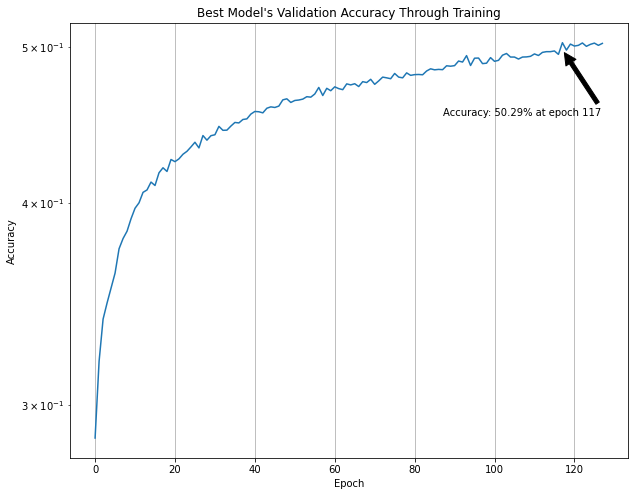

In [193]:
# annotating code aided with: https://stackoverflow.com/questions/43374920/how-to-automatically-annotate-maximum-value-in-pyplot

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()

plt.semilogy(best_mdl.history[:, 'valid_acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

ymax = max(best_mdl.history[:, 'valid_acc'])
xpos = best_mdl.history[:, 'valid_acc'].index(ymax)
xmin = best_mdl.history[:, 'valid_acc'][xpos]
ax.annotate('Accuracy: {0}% at epoch {1}'.format(str(ymax * 100), str(xpos)),
            xy = (xpos, ymax - 0.005), xytext = (xpos - 30, ymax-0.05), arrowprops=dict(facecolor='black', shrink=0.05))


plt.title("Best Model's Validation Accuracy Through Training")
plt.grid()
plt.show()    

In [188]:
print("training time: ", sum(gs.best_estimator_.history[:, 'dur']))

training time:  1607.5434184074402


# 3 Hidden Layers

Due to the exponential growth of computational workload as number of hidden layers increases, and strain placed on the CPU creating difficulties while running the grdisearch algorithm in the background, the 3 hidden layer gridsearch will have a strimmed selection of parameters, selected based off of what has yeilded the best validation results from the single and double hidden layer gridsearches.

In [224]:
from skorch import NeuralNetClassifier

# defining callbacks to be input in to the skorch classifier

earlystopping = skorch.callbacks.EarlyStopping(monitor = 'valid_acc', lower_is_better = False,
                                               patience = 10, threshold_mode = 'abs')

checkpoint = skorch.callbacks.Checkpoint(monitor = 'valid_acc_best')

# defining the classifier object


mlpskorch = NeuralNetClassifier(
        mlp,
        criterion = nn.CrossEntropyLoss,
        max_epochs = 200,
        lr = lr,
        callbacks = [earlystopping, checkpoint]
        )

In [225]:
# Specifying parameters to be searched through

params = {'module__dropout': [0.2, 0.5],
          'lr': [1e-4, 1e-3],
          'module__nodes1': [2000, 1500, 1000],
          'module__nodes2': [750, 1000], 
          'module__nodes3': [250, 500, 750],
          'optimizer__momentum': [0.9, 0.7]
          }

gs = GridSearchCV(mlpskorch, params, verbose = 2, cv = 2, scoring = 'accuracy')

In [226]:
# fitting the model

best_mdl_3 = gs.fit(xTrain, yTrain)

Fitting 2 folds for each of 144 candidates, totalling 288 fits
[CV] lr=0.0001, module__dropout=0.2, module__nodes1=2000, module__nodes2=750, module__nodes3=250, optimizer__momentum=0.9 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  epoch    train_loss    valid_acc    valid_loss    cp      dur
-------  ------------  -----------  ------------  ----  -------
      1        2.6335       0.3048        1.9900     +  19.3807
      2        2.0436       0.3428        1.8623     +  17.9074
      3        1.9461       0.3588        1.8052     +  17.6201
      4        1.8872       0.3804        1.7672     +  17.5067
      5        1.8506       0.3914        1.7375     +  17.5359
      6        1.8156       0.3924        1.7131     +  17.6506
      7        1.7819       0.4076        1.6807     +  17.6013
      8        1.7626       0.4086        1.6593     +  17.4048
      9        1.7370       0.4134        1.6477     +  17.5026
     10        1.7130       0.4220        1.6291     +  17.3785
     11        1.6936       0.4296        1.6192     +  17.3247
     12        1.6746       0.4240        1.6213        17.2969
     13        1.6547       0.4312        1.5949     +  17.3234
     14        1.6390       0.4316      

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 19.6min remaining:    0.0s


  epoch    train_loss    valid_acc    valid_loss    cp      dur
-------  ------------  -----------  ------------  ----  -------
      1        2.6219       0.2728        1.9569     +  15.3931
      2        2.0390       0.3394        1.8562     +  15.4750
      3        1.9456       0.3492        1.8121     +  15.4570
      4        1.8814       0.3696        1.7584     +  15.3984
      5        1.8444       0.3880        1.7316     +  15.5359
      6        1.8039       0.3902        1.7101     +  15.5085
      7        1.7705       0.4000        1.6920     +  15.4056
      8        1.7529       0.4030        1.6754     +  15.4291
      9        1.7232       0.4094        1.6531     +  15.3899
     10        1.7082       0.4162        1.6393     +  15.3719
     11        1.6894       0.4200        1.6268     +  15.3077
     12        1.6642       0.4248        1.6176     +  15.4215
     13        1.6520       0.4250        1.6069     +  15.5345
     14        1.6374       0.4338      

      8        1.9004       0.3672        1.7740     +  15.4395
      9        1.8755       0.3722        1.7569     +  15.3026
     10        1.8531       0.3794        1.7386     +  15.2929
     11        1.8391       0.3892        1.7270     +  15.2709
     12        1.8252       0.3876        1.7147        15.2294
     13        1.8100       0.3926        1.7018     +  15.3658
     14        1.7908       0.3950        1.6884     +  15.4136
     15        1.7788       0.4026        1.6804     +  15.3893
     16        1.7642       0.4064        1.6695     +  15.4820
     17        1.7500       0.4158        1.6585     +  15.3991
     18        1.7440       0.4126        1.6566        15.3800
     19        1.7272       0.4142        1.6449        15.2644
     20        1.7121       0.4186        1.6336     +  15.2032
     21        1.7054       0.4198        1.6295     +  15.1662
     22        1.6958       0.4272        1.6192     +  15.1938
     23        1.6851       0.4240      

    108        1.1438       0.5014        1.4219        15.0408
    109        1.1414       0.5032        1.4198     +  15.0095
    110        1.1335       0.5002        1.4253        15.1879
    111        1.1243       0.5014        1.4223        15.1030
    112        1.1247       0.5006        1.4232        15.1093
    113        1.1127       0.5034        1.4221     +  15.1092
    114        1.1190       0.5006        1.4239        15.1713
    115        1.1019       0.4984        1.4275        15.1336
    116        1.1017       0.4994        1.4308        15.1141
    117        1.0963       0.5026        1.4316        15.4326
    118        1.0895       0.5012        1.4248        15.1533
    119        1.1018       0.5054        1.4203     +  15.1135
    120        1.0807       0.5046        1.4223        15.1014
    121        1.0794       0.4988        1.4226        14.9911
    122        1.0703       0.5022        1.4344        15.3126
    123        1.0638       0.5014      

     68        1.3638       0.4806        1.4847        14.6498
     69        1.3519       0.4842        1.4835     +  14.7639
     70        1.3495       0.4814        1.4816        14.6893
     71        1.3457       0.4854        1.4750     +  14.6713
     72        1.3451       0.4822        1.4783        14.6948
     73        1.3267       0.4864        1.4725     +  14.6408
     74        1.3275       0.4832        1.4746        14.7328
     75        1.3209       0.4878        1.4742     +  14.6990
     76        1.3181       0.4860        1.4709        14.7154
     77        1.3066       0.4866        1.4806        14.7723
     78        1.3029       0.4854        1.4743        14.6352
     79        1.2956       0.4914        1.4606     +  14.6240
     80        1.2952       0.4918        1.4672     +  14.6601
     81        1.2873       0.4902        1.4636        14.6191
     82        1.2843       0.4938        1.4638     +  14.5729
     83        1.2738       0.4904      

     42        1.2569       0.4886        1.4451     +  15.2633
     43        1.2531       0.4876        1.4466        15.1936
     44        1.2328       0.4892        1.4472     +  15.1681
     45        1.2175       0.4926        1.4346     +  15.1630
     46        1.2232       0.4960        1.4328     +  15.1379
     47        1.1984       0.4860        1.4478        15.2589
     48        1.1872       0.4962        1.4400     +  15.1696
     49        1.1770       0.4960        1.4416        15.2498
     50        1.1720       0.4974        1.4445     +  15.1178
     51        1.1583       0.4986        1.4444     +  15.3015
     52        1.1477       0.4974        1.4366        15.1709
     53        1.1407       0.5036        1.4340     +  15.1648
     54        1.1319       0.4986        1.4456        15.2493
     55        1.1224       0.4966        1.4462        15.2065
     56        1.1140       0.5006        1.4395        15.1647
     57        1.1012       0.4998      

     29        1.5865       0.4526        1.5641     +  16.5405
     30        1.5747       0.4556        1.5556     +  20.3910
     31        1.5671       0.4578        1.5495     +  21.8566
     32        1.5546       0.4622        1.5458     +  15.9501
     33        1.5486       0.4628        1.5405     +  15.5877
     34        1.5394       0.4602        1.5383        15.3015
     35        1.5290       0.4622        1.5357        15.3524
     36        1.5244       0.4708        1.5311     +  15.1968
     37        1.5238       0.4656        1.5265        16.1531
     38        1.5163       0.4714        1.5210     +  16.0719
     39        1.5043       0.4676        1.5207        15.2235
     40        1.5023       0.4720        1.5182     +  15.3170
     41        1.4859       0.4736        1.5082     +  15.1317
     42        1.4831       0.4740        1.5115     +  15.1880
     43        1.4679       0.4764        1.5076     +  15.1553
     44        1.4675       0.4764      

     15        1.7189       0.4112        1.6592     +  15.1584
     16        1.7137       0.4144        1.6460     +  15.0889
     17        1.6925       0.4194        1.6407     +  15.1622
     18        1.6741       0.4184        1.6353        15.0340
     19        1.6680       0.4248        1.6253     +  15.0758
     20        1.6536       0.4280        1.6157     +  15.0999
     21        1.6340       0.4242        1.6162        15.1865
     22        1.6397       0.4280        1.6129        15.0689
     23        1.6225       0.4370        1.5997     +  15.0650
     24        1.6117       0.4326        1.6000        15.0718
     25        1.6084       0.4410        1.5891     +  15.0916
     26        1.5954       0.4436        1.5841     +  15.1490
     27        1.5864       0.4466        1.5805     +  15.1935
     28        1.5772       0.4460        1.5754        15.1715
     29        1.5596       0.4502        1.5754     +  15.1638
     30        1.5572       0.4474      

     36        1.2985       0.4908        1.4522     +  15.2841
     37        1.2931       0.5014        1.4472     +  15.3125
     38        1.2723       0.4940        1.4418        15.4159
     39        1.2587       0.4960        1.4443        15.3304
     40        1.2431       0.4976        1.4433        15.3898
     41        1.2318       0.4954        1.4489        15.5002
     42        1.2312       0.4978        1.4397        15.4162
     43        1.2113       0.5026        1.4375     +  15.3258
     44        1.2129       0.4902        1.4505        15.2791
     45        1.1957       0.4934        1.4412        15.4368
     46        1.1814       0.4986        1.4476        15.3795
     47        1.1756       0.4938        1.4451        15.3123
     48        1.1603       0.4936        1.4405        15.3085
     49        1.1436       0.4982        1.4522        15.4307
     50        1.1359       0.4986        1.4455        15.3266
     51        1.1277       0.5042      

     66        0.9839       0.4956        1.5070        15.2939
     67        0.9752       0.4956        1.5047        15.2370
     68        0.9696       0.4954        1.5304        15.1940
     69        0.9626       0.4882        1.5553        15.1996
     70        0.9507       0.4954        1.5347        15.1933
     71        0.9329       0.4972        1.5397        15.3549
Stopping since valid_acc has not improved in the last 10 epochs.
[CV]  lr=0.0001, module__dropout=0.2, module__nodes1=2000, module__nodes2=750, module__nodes3=750, optimizer__momentum=0.9, total=18.7min
[CV] lr=0.0001, module__dropout=0.2, module__nodes1=2000, module__nodes2=750, module__nodes3=750, optimizer__momentum=0.7 
  epoch    train_loss    valid_acc    valid_loss    cp      dur
-------  ------------  -----------  ------------  ----  -------
      1        3.0302       0.3012        1.9900     +  15.3081
      2        2.1982       0.3122        1.9238     +  15.3871
      3        2.0774       0.3468

     90        1.1603       0.4980        1.4267        15.2812
Stopping since valid_acc has not improved in the last 10 epochs.
[CV]  lr=0.0001, module__dropout=0.2, module__nodes1=2000, module__nodes2=750, module__nodes3=750, optimizer__momentum=0.7, total=23.6min
[CV] lr=0.0001, module__dropout=0.2, module__nodes1=2000, module__nodes2=750, module__nodes3=750, optimizer__momentum=0.7 
  epoch    train_loss    valid_acc    valid_loss    cp      dur
-------  ------------  -----------  ------------  ----  -------
      1        3.0600       0.2586        2.0275     +  15.1867
      2        2.1815       0.3122        1.9056     +  15.2945
      3        2.0636       0.3296        1.8678     +  15.3981
      4        1.9938       0.3622        1.8098     +  15.3487
      5        1.9507       0.3656        1.7795     +  15.2670
      6        1.9141       0.3658        1.7652     +  15.3624
      7        1.8755       0.3766        1.7428     +  15.2943
      8        1.8499       0.3872

  epoch    train_loss    valid_acc    valid_loss    cp      dur
-------  ------------  -----------  ------------  ----  -------
      1        2.7305       0.2710        2.0625     +  15.1595
      2        2.0832       0.3202        1.9311     +  15.1947
      3        1.9857       0.3538        1.8435     +  15.1923
      4        1.9152       0.3692        1.7836     +  15.1433
      5        1.8782       0.3814        1.7610     +  15.1602
      6        1.8407       0.3876        1.7222     +  15.2346
      7        1.8125       0.4004        1.7041     +  15.2401
      8        1.7820       0.4084        1.6792     +  15.2580
      9        1.7584       0.4096        1.6709     +  15.2516
     10        1.7373       0.4160        1.6503     +  15.3284
     11        1.7196       0.4148        1.6414        15.2284
     12        1.7026       0.4264        1.6230     +  15.1629
     13        1.6801       0.4302        1.6073     +  15.2431
     14        1.6647       0.4394      

     13        1.6779       0.4126        1.6236     +  15.3145
     14        1.6638       0.4184        1.6112     +  15.3451
     15        1.6416       0.4316        1.5968     +  15.3851
     16        1.6246       0.4360        1.5914     +  15.1894
     17        1.6210       0.4402        1.5848     +  15.2692
     18        1.6029       0.4462        1.5729     +  15.2609
     19        1.5850       0.4470        1.5661     +  15.3564
     20        1.5754       0.4508        1.5579     +  15.3325
     21        1.5582       0.4568        1.5425     +  15.1872
     22        1.5412       0.4514        1.5477        15.1397
     23        1.5290       0.4554        1.5361        15.1361
     24        1.5148       0.4590        1.5313     +  15.1893
     25        1.5088       0.4614        1.5230     +  15.1830
     26        1.4942       0.4602        1.5236        15.2947
     27        1.4832       0.4692        1.5116     +  15.1300
     28        1.4707       0.4608      

     37        1.5836       0.4420        1.5621     +  15.4392
     38        1.5762       0.4446        1.5598     +  15.4574
     39        1.5699       0.4388        1.5587        15.3964
     40        1.5579       0.4472        1.5487     +  15.4179
     41        1.5487       0.4490        1.5456     +  15.5089
     42        1.5554       0.4490        1.5434        15.3375
     43        1.5384       0.4504        1.5431     +  15.3438
     44        1.5321       0.4530        1.5366     +  15.6501
     45        1.5286       0.4548        1.5302     +  15.8270
     46        1.5252       0.4572        1.5340     +  15.5318
     47        1.5074       0.4532        1.5306        15.5075
     48        1.5052       0.4552        1.5252        15.5225
     49        1.4974       0.4554        1.5228        15.4673
     50        1.4927       0.4582        1.5209     +  15.4186
     51        1.4870       0.4604        1.5217     +  15.4025
     52        1.4758       0.4618      

     30        1.6106       0.4246        1.5946     +  15.5297
     31        1.6016       0.4330        1.5874     +  15.5074
     32        1.5838       0.4302        1.5844        15.4479
     33        1.5790       0.4324        1.5848        15.4159
     34        1.5777       0.4322        1.5785        15.4145
     35        1.5744       0.4332        1.5719     +  15.3685
     36        1.5617       0.4340        1.5723     +  15.5075
     37        1.5548       0.4422        1.5653     +  15.4414
     38        1.5460       0.4382        1.5654        15.5247
     39        1.5417       0.4402        1.5623        15.3529
     40        1.5372       0.4364        1.5623        15.3776
     41        1.5297       0.4478        1.5469     +  15.3716
     42        1.5226       0.4456        1.5551        15.4271
     43        1.5210       0.4468        1.5500        15.3222
     44        1.5096       0.4484        1.5457     +  15.4786
     45        1.5044       0.4470      

     28        1.4072       0.4722        1.4856     +  16.0790
     29        1.3874       0.4692        1.4743        16.2554
     30        1.3821       0.4762        1.4662     +  16.0297
     31        1.3656       0.4800        1.4673     +  16.0291
     32        1.3548       0.4724        1.4634        16.0549
     33        1.3435       0.4826        1.4527     +  16.0442
     34        1.3356       0.4804        1.4501        15.9955
     35        1.3232       0.4808        1.4606        15.9307
     36        1.3152       0.4886        1.4521     +  15.9170
     37        1.3000       0.4894        1.4477     +  16.0184
     38        1.2818       0.4838        1.4437        16.0657
     39        1.2773       0.4854        1.4397        16.1400
     40        1.2572       0.4900        1.4350     +  16.0436
     41        1.2600       0.4924        1.4416     +  16.0756
     42        1.2437       0.4914        1.4486        16.0132
     43        1.2283       0.4926      

     66        0.9797       0.4930        1.5204        16.3244
Stopping since valid_acc has not improved in the last 10 epochs.
[CV]  lr=0.0001, module__dropout=0.2, module__nodes1=2000, module__nodes2=1000, module__nodes3=500, optimizer__momentum=0.9, total=18.3min
[CV] lr=0.0001, module__dropout=0.2, module__nodes1=2000, module__nodes2=1000, module__nodes3=500, optimizer__momentum=0.7 
  epoch    train_loss    valid_acc    valid_loss    cp      dur
-------  ------------  -----------  ------------  ----  -------
      1        3.1322       0.3050        1.9402     +  16.3271
      2        2.1801       0.3272        1.8851     +  16.3096
      3        2.0681       0.3418        1.8397     +  16.2565
      4        1.9930       0.3564        1.8154     +  16.2339
      5        1.9466       0.3702        1.7789     +  16.3155
      6        1.9061       0.3748        1.7640     +  16.3512
      7        1.8776       0.3914        1.7457     +  16.2440
      8        1.8456       0.39

     93        1.1449       0.4950        1.4370        16.3946
     94        1.1385       0.4910        1.4441        16.2440
     95        1.1305       0.4988        1.4342     +  16.2552
     96        1.1228       0.4938        1.4371        16.7614
     97        1.1151       0.4944        1.4375        16.3489
     98        1.1105       0.4960        1.4351        16.4152
     99        1.1148       0.4954        1.4370        16.3266
    100        1.1053       0.4976        1.4338        16.4638
    101        1.0952       0.4980        1.4380        16.3244
    102        1.0905       0.4992        1.4374     +  16.3530
    103        1.0845       0.4966        1.4308        16.3303
    104        1.0847       0.4948        1.4343        16.3849
    105        1.0758       0.5006        1.4365     +  16.3810
    106        1.0638       0.5000        1.4398        16.3975
    107        1.0620       0.5018        1.4275     +  16.4393
    108        1.0558       0.4976      

     42        1.4566       0.4680        1.5200     +  16.4639
     43        1.4580       0.4652        1.5179        16.5314
     44        1.4423       0.4720        1.5157     +  16.3584
     45        1.4337       0.4692        1.5161        16.4879
     46        1.4276       0.4686        1.5124        16.5095
     47        1.4203       0.4712        1.5085        16.4451
     48        1.4148       0.4708        1.5037        16.4507
     49        1.4117       0.4720        1.5060        16.4162
     50        1.4002       0.4730        1.4999     +  16.3764
     51        1.3889       0.4732        1.5005     +  16.5258
     52        1.3949       0.4772        1.4977     +  16.3686
     53        1.3815       0.4786        1.4961     +  16.4277
     54        1.3707       0.4838        1.4935     +  16.4082
     55        1.3649       0.4792        1.4929        16.3229
     56        1.3630       0.4822        1.4855        16.3189
     57        1.3505       0.4792      

     14        1.6011       0.4456        1.5648        17.4251
     15        1.5763       0.4530        1.5540     +  17.1082
     16        1.5723       0.4526        1.5398        17.1835
     17        1.5492       0.4546        1.5504     +  17.0612
     18        1.5310       0.4618        1.5310     +  17.0456
     19        1.5232       0.4550        1.5304        17.0186
     20        1.5082       0.4550        1.5303        17.5211
     21        1.4870       0.4580        1.5225        17.0771
     22        1.4795       0.4686        1.5067     +  17.0481
     23        1.4632       0.4736        1.4991     +  17.1226
     24        1.4517       0.4676        1.4921        17.0854
     25        1.4313       0.4702        1.4870        17.0634
     26        1.4219       0.4654        1.4969        17.0890
     27        1.4158       0.4740        1.4867     +  17.1086
     28        1.3945       0.4754        1.4704     +  17.0872
     29        1.3827       0.4710      

     49        1.1418       0.4912        1.4740        16.8146
     50        1.1348       0.4930        1.4779        16.6674
     51        1.1245       0.5054        1.4593     +  16.8325
     52        1.1025       0.5020        1.4724        16.7845
     53        1.0997       0.4976        1.4724        16.6716
     54        1.0869       0.4898        1.4886        16.7528
     55        1.0768       0.5036        1.4757        16.7707
     56        1.0633       0.4998        1.4846        16.7698
     57        1.0561       0.5042        1.4753        17.2033
     58        1.0442       0.4988        1.4858        16.7587
     59        1.0351       0.5016        1.4761        16.7322
     60        1.0304       0.5066        1.4738     +  16.8518
     61        1.0102       0.5080        1.4844     +  16.8302
     62        1.0081       0.5026        1.4891        16.7070
     63        0.9925       0.4986        1.5065        16.8211
     64        0.9815       0.5022      

     68        1.2670       0.4906        1.4474        16.9199
     69        1.2560       0.4956        1.4471        16.8711
     70        1.2462       0.4928        1.4513        16.8885
     71        1.2430       0.4924        1.4444        16.8696
     72        1.2418       0.4924        1.4479        16.9290
     73        1.2295       0.4950        1.4384        16.8938
     74        1.2258       0.4980        1.4373        16.8731
     75        1.2150       0.4938        1.4397        17.2114
     76        1.2064       0.4980        1.4417        16.9670
Stopping since valid_acc has not improved in the last 10 epochs.
[CV]  lr=0.0001, module__dropout=0.2, module__nodes1=2000, module__nodes2=1000, module__nodes3=750, optimizer__momentum=0.7, total=21.9min
[CV] lr=0.0001, module__dropout=0.2, module__nodes1=2000, module__nodes2=1000, module__nodes3=750, optimizer__momentum=0.7 
  epoch    train_loss    valid_acc    valid_loss    cp      dur
-------  ------------  ---------

      7        1.7970       0.4044        1.6973     +  11.3719
      8        1.7702       0.4208        1.6709     +  11.4241
      9        1.7481       0.4214        1.6561     +  11.8102
     10        1.7309       0.4134        1.6461        11.5557
     11        1.7091       0.4312        1.6245     +  11.4079
     12        1.6946       0.4238        1.6329        11.4489
     13        1.6789       0.4326        1.6112     +  11.4310
     14        1.6621       0.4398        1.6008     +  11.3554
     15        1.6510       0.4368        1.5932        11.4392
     16        1.6251       0.4402        1.5850     +  11.6643
     17        1.6192       0.4476        1.5718     +  11.6606
     18        1.5996       0.4504        1.5607     +  11.4503
     19        1.5924       0.4448        1.5620        11.3681
     20        1.5770       0.4406        1.5592        11.4642
     21        1.5703       0.4542        1.5459     +  11.4280
     22        1.5479       0.4526      

     21        1.5616       0.4446        1.5596        11.3605
     22        1.5406       0.4484        1.5580     +  11.4255
     23        1.5349       0.4548        1.5443     +  11.3234
     24        1.5197       0.4530        1.5339        11.3534
     25        1.5154       0.4562        1.5434     +  11.3628
     26        1.4969       0.4602        1.5325     +  11.4643
     27        1.4838       0.4532        1.5339        11.4351
     28        1.4746       0.4650        1.5190     +  11.3365
     29        1.4665       0.4624        1.5158        11.3821
     30        1.4543       0.4668        1.5199     +  11.4060
     31        1.4423       0.4714        1.5150     +  11.3866
     32        1.4288       0.4608        1.5204        11.3457
     33        1.4273       0.4666        1.5089        11.3931
     34        1.4094       0.4706        1.4986        11.3951
     35        1.4091       0.4696        1.5096        11.3294
     36        1.3920       0.4742      

     45        1.5192       0.4538        1.5312        11.5667
     46        1.5122       0.4554        1.5287     +  11.4629
     47        1.4959       0.4516        1.5286        11.3980
     48        1.4958       0.4598        1.5220     +  11.4041
     49        1.4876       0.4646        1.5145     +  11.4011
     50        1.4807       0.4614        1.5145        11.4342
     51        1.4716       0.4630        1.5123        11.3523
     52        1.4729       0.4564        1.5160        11.4348
     53        1.4677       0.4642        1.5064        11.5218
     54        1.4629       0.4604        1.5074        11.3743
     55        1.4555       0.4618        1.5061        11.4012
     56        1.4461       0.4668        1.5070     +  11.4159
     57        1.4375       0.4708        1.4948     +  11.4286
     58        1.4358       0.4690        1.4965        11.3752
     59        1.4222       0.4708        1.4913        11.4556
     60        1.4147       0.4732      

     36        1.5737       0.4484        1.5631        11.3786
     37        1.5664       0.4450        1.5631        11.3836
     38        1.5607       0.4526        1.5578     +  11.3621
     39        1.5520       0.4460        1.5557        11.4019
     40        1.5489       0.4552        1.5465     +  11.3786
     41        1.5430       0.4580        1.5465     +  11.4750
     42        1.5367       0.4560        1.5451        11.4792
     43        1.5255       0.4584        1.5433     +  11.3868
     44        1.5200       0.4572        1.5420        11.3936
     45        1.5112       0.4556        1.5370        11.3866
     46        1.5055       0.4648        1.5343     +  11.3398
     47        1.4995       0.4566        1.5327        11.4028
     48        1.4947       0.4564        1.5327        11.3983
     49        1.4842       0.4604        1.5312        11.3877
     50        1.4867       0.4674        1.5261     +  11.3429
     51        1.4695       0.4620      

     14        1.6347       0.4344        1.5862     +  11.9650
     15        1.6164       0.4360        1.5878     +  11.9664
     16        1.6014       0.4442        1.5669     +  11.8846
     17        1.5850       0.4400        1.5615        11.8858
     18        1.5698       0.4416        1.5615        11.9017
     19        1.5595       0.4436        1.5587        11.8898
     20        1.5376       0.4504        1.5412     +  11.8721
     21        1.5317       0.4518        1.5451     +  11.8558
     22        1.5166       0.4496        1.5345        11.8654
     23        1.5014       0.4508        1.5327        12.0233
     24        1.4889       0.4496        1.5186        11.8700
     25        1.4835       0.4544        1.5169     +  11.8853
     26        1.4702       0.4638        1.5099     +  11.9503
     27        1.4512       0.4580        1.5090        11.8579
     28        1.4424       0.4618        1.5057        11.8765
     29        1.4330       0.4614      

     32        1.3760       0.4672        1.5104        11.8667
     33        1.3632       0.4698        1.5030        11.9843
     34        1.3623       0.4742        1.4791        11.9358
     35        1.3425       0.4746        1.4903     +  11.9461
     36        1.3398       0.4838        1.4839     +  11.8831
     37        1.3176       0.4802        1.4844        11.8908
     38        1.3199       0.4774        1.4851        11.9283
     39        1.3012       0.4830        1.4865        11.8925
     40        1.2879       0.4812        1.4895        11.8915
     41        1.2827       0.4750        1.4907        11.9621
     42        1.2712       0.4826        1.4778        11.9182
     43        1.2503       0.4812        1.5000        12.0509
     44        1.2532       0.4822        1.4957        11.9042
     45        1.2420       0.4834        1.4746        11.9424
     46        1.2327       0.4886        1.4715     +  11.9695
     47        1.2179       0.4850      

     69        1.3261       0.4898        1.4574     +  11.9221
     70        1.3192       0.4878        1.4534        11.9440
     71        1.3156       0.4880        1.4533        11.9269
     72        1.3163       0.4892        1.4473        12.0295
     73        1.2989       0.4898        1.4495        12.0149
     74        1.2937       0.4902        1.4456     +  11.9554
     75        1.2926       0.4894        1.4460        11.9422
     76        1.2798       0.4916        1.4462     +  11.9353
     77        1.2783       0.4916        1.4434        11.9349
     78        1.2805       0.4860        1.4393        11.9684
     79        1.2666       0.4914        1.4403        12.0043
     80        1.2680       0.4894        1.4457        11.8921
     81        1.2550       0.4896        1.4387        12.0761
     82        1.2473       0.4908        1.4426        11.9680
     83        1.2397       0.4898        1.4414        11.9205
     84        1.2373       0.4942      

     63        1.3455       0.4796        1.4963        11.9001
     64        1.3424       0.4726        1.5003        11.9082
     65        1.3412       0.4772        1.4930        11.9180
     66        1.3317       0.4792        1.4900        11.8640
     67        1.3256       0.4802        1.4908        11.9844
     68        1.3162       0.4762        1.4994        11.9165
     69        1.3156       0.4802        1.4853        11.8928
     70        1.3033       0.4774        1.4853        11.8674
     71        1.3037       0.4768        1.4846        11.9395
     72        1.2997       0.4824        1.4821     +  11.8949
     73        1.2892       0.4790        1.4863        11.9845
     74        1.2842       0.4844        1.4821     +  11.9724
     75        1.2838       0.4866        1.4803     +  11.8950
     76        1.2779       0.4806        1.4882        11.9027
     77        1.2693       0.4862        1.4838        11.9613
     78        1.2593       0.4866      

     60        1.0880       0.5046        1.4556     +  12.4320
     61        1.0860       0.5008        1.4541        12.4037
     62        1.0798       0.4922        1.4648        12.4556
     63        1.0677       0.4960        1.4604        12.5131
     64        1.0600       0.4990        1.4590        12.4760
     65        1.0585       0.4964        1.4652        12.5480
     66        1.0382       0.4942        1.4677        12.4675
     67        1.0340       0.4928        1.4840        12.4228
     68        1.0204       0.4978        1.4893        12.4404
     69        1.0116       0.5056        1.4686     +  12.3995
     70        1.0074       0.4978        1.4748        12.4564
     71        0.9976       0.4992        1.4849        12.4739
     72        0.9948       0.4948        1.4849        12.5543
     73        0.9752       0.4960        1.4761        12.4028
     74        0.9608       0.4930        1.5082        12.5721
     75        0.9659       0.5008      

      4        1.9987       0.3650        1.7994     +  12.4518
      5        1.9512       0.3720        1.7762     +  12.4540
      6        1.9132       0.3818        1.7542     +  12.4245
      7        1.8844       0.3866        1.7325     +  12.4308
      8        1.8529       0.3970        1.7174     +  12.4565
      9        1.8334       0.3986        1.7011     +  12.3883
     10        1.8037       0.4024        1.6946     +  12.4291
     11        1.7970       0.4070        1.6832     +  12.4241
     12        1.7728       0.4098        1.6711     +  12.4522
     13        1.7524       0.4170        1.6608     +  12.4112
     14        1.7379       0.4176        1.6465     +  12.3596
     15        1.7283       0.4254        1.6424     +  12.3985
     16        1.7118       0.4314        1.6273     +  12.5682
     17        1.6987       0.4264        1.6179        12.5176
     18        1.6837       0.4302        1.6183        12.4160
     19        1.6737       0.4380      

    105        1.0950       0.5006        1.4418        12.4474
    106        1.0897       0.5020        1.4436        12.3963
    107        1.0867       0.5046        1.4434        12.4265
    108        1.0782       0.5076        1.4410     +  12.4096
    109        1.0782       0.5044        1.4439        12.4400
    110        1.0667       0.5086        1.4445     +  12.3895
    111        1.0736       0.5094        1.4395     +  12.4781
    112        1.0616       0.5076        1.4404        12.4562
    113        1.0476       0.5098        1.4384     +  12.4422
    114        1.0472       0.5028        1.4413        12.5390
    115        1.0428       0.5068        1.4423        12.4543
    116        1.0402       0.5078        1.4465        12.4240
    117        1.0311       0.5086        1.4449        12.7616
    118        1.0240       0.5034        1.4470        12.5038
    119        1.0169       0.5042        1.4463        12.4775
    120        1.0200       0.5046      

      2        2.0459       0.3388        1.8916     +  12.2718
      3        1.9567       0.3608        1.8196     +  12.2968
      4        1.9079       0.3758        1.7724     +  12.3431
      5        1.8673       0.3828        1.7568     +  12.2347
      6        1.8351       0.3876        1.7259     +  12.2718
      7        1.8093       0.3912        1.7072     +  12.2108
      8        1.7845       0.4062        1.6840     +  12.2351
      9        1.7651       0.4126        1.6704     +  12.2714
     10        1.7394       0.4236        1.6495     +  12.2220
     11        1.7247       0.4242        1.6391     +  12.2660
     12        1.7049       0.4232        1.6289        12.2202
     13        1.6915       0.4324        1.6164     +  12.2358
     14        1.6770       0.4326        1.6006     +  12.2210
     15        1.6585       0.4376        1.5849     +  12.2410
     16        1.6418       0.4428        1.5847     +  12.2586
     17        1.6343       0.4424      

     16        1.6261       0.4382        1.5932     +  12.2826
     17        1.6136       0.4392        1.5846     +  12.2294
     18        1.6005       0.4398        1.5786     +  12.1825
     19        1.5875       0.4468        1.5686     +  12.1743
     20        1.5789       0.4456        1.5619        12.2454
     21        1.5648       0.4458        1.5540        12.2052
     22        1.5481       0.4506        1.5432     +  12.1960
     23        1.5390       0.4512        1.5409     +  12.1967
     24        1.5241       0.4564        1.5383     +  12.3005
     25        1.5097       0.4536        1.5400        12.2054
     26        1.5086       0.4564        1.5243        12.3148
     27        1.4919       0.4614        1.5243     +  12.2059
     28        1.4820       0.4606        1.5286        12.2555
     29        1.4746       0.4658        1.5159     +  12.2324
     30        1.4579       0.4690        1.5131     +  12.2175
     31        1.4579       0.4722      

     34        1.5989       0.4426        1.5703        12.2013
     35        1.5943       0.4424        1.5664        12.1649
     36        1.5797       0.4456        1.5553     +  12.2835
     37        1.5761       0.4422        1.5580        12.1941
     38        1.5694       0.4544        1.5573     +  12.1980
     39        1.5605       0.4502        1.5545        12.1798
     40        1.5520       0.4510        1.5519        12.2162
     41        1.5485       0.4508        1.5484        12.1832
     42        1.5423       0.4474        1.5457        12.1613
     43        1.5319       0.4524        1.5402        12.1751
     44        1.5368       0.4542        1.5390        12.1727
     45        1.5299       0.4564        1.5365     +  12.2539
     46        1.5258       0.4578        1.5357     +  12.2317
     47        1.5107       0.4544        1.5303        12.2132
     48        1.5037       0.4598        1.5229     +  12.2293
     49        1.5002       0.4546      

     21        1.7121       0.4052        1.6565        12.2655
     22        1.6995       0.4068        1.6498        12.1177
     23        1.6914       0.4086        1.6397     +  12.1830
     24        1.6860       0.4110        1.6372     +  12.2778
     25        1.6834       0.4156        1.6327     +  12.2102
     26        1.6674       0.4150        1.6271        12.1920
     27        1.6602       0.4208        1.6200     +  12.1922
     28        1.6531       0.4196        1.6144        12.1729
     29        1.6490       0.4202        1.6113        12.2117
     30        1.6409       0.4198        1.6131        12.1751
     31        1.6282       0.4260        1.6043     +  12.2627
     32        1.6229       0.4286        1.6019     +  12.2152
     33        1.6104       0.4278        1.5968        12.2505
     34        1.6064       0.4328        1.5887     +  12.2330
     35        1.6012       0.4324        1.5886        12.1899
     36        1.5918       0.4316      

     14        1.6320       0.4436        1.5813     +  12.8276
     15        1.6150       0.4362        1.5915        12.8002
     16        1.5970       0.4432        1.5700        12.8083
     17        1.5967       0.4480        1.5685     +  12.7882
     18        1.5793       0.4528        1.5598     +  12.8410
     19        1.5569       0.4562        1.5516     +  12.8023
     20        1.5442       0.4498        1.5461        12.8153
     21        1.5347       0.4608        1.5398     +  12.7955
     22        1.5155       0.4580        1.5377        12.8052
     23        1.5063       0.4660        1.5180     +  12.8002
     24        1.4885       0.4606        1.5198        12.9209
     25        1.4780       0.4598        1.5238        12.8349
     26        1.4696       0.4676        1.5120     +  12.8213
     27        1.4616       0.4652        1.5114        12.8273
     28        1.4494       0.4690        1.4972     +  12.7632
     29        1.4366       0.4770      

     52        1.1810       0.4932        1.4671     +  12.7358
     53        1.1630       0.4862        1.4958        12.7711
     54        1.1534       0.4978        1.4674     +  12.7894
     55        1.1457       0.4874        1.4926        12.7983
     56        1.1459       0.5024        1.4730     +  12.7818
     57        1.1311       0.4884        1.4922        12.9848
     58        1.1337       0.4944        1.4962        12.8462
     59        1.1165       0.5014        1.4861        12.7979
     60        1.1022       0.4946        1.4791        12.7551
     61        1.0992       0.4958        1.4730        12.7521
     62        1.0918       0.4966        1.4914        12.7133
     63        1.0738       0.4930        1.4990        12.7909
     64        1.0710       0.4904        1.5039        12.7868
     65        1.0539       0.4932        1.4892        12.7739
Stopping since valid_acc has not improved in the last 10 epochs.
[CV]  lr=0.0001, module__dropout=0.2, m

  epoch    train_loss    valid_acc    valid_loss    cp      dur
-------  ------------  -----------  ------------  ----  -------
      1        3.0544       0.2650        2.0070     +  12.7287
      2        2.1610       0.3076        1.8958     +  12.8474
      3        2.0306       0.3288        1.8344     +  12.7978
      4        1.9644       0.3464        1.8071     +  12.8193
      5        1.9216       0.3552        1.7822     +  12.9279
      6        1.8891       0.3634        1.7617     +  12.8483
      7        1.8580       0.3798        1.7379     +  12.8449
      8        1.8326       0.3782        1.7338        12.8063
      9        1.8109       0.3896        1.7157     +  12.7740
     10        1.7926       0.3944        1.7060     +  12.8315
     11        1.7714       0.3972        1.6918     +  12.8578
     12        1.7532       0.4050        1.6782     +  12.8214
     13        1.7397       0.4094        1.6709     +  12.8528
     14        1.7297       0.4092      

     12        1.6544       0.4356        1.6146     +  13.4020
     13        1.6308       0.4258        1.6033        13.2949
     14        1.6121       0.4418        1.5791     +  13.4558
     15        1.5963       0.4504        1.5753     +  13.3952
     16        1.5848       0.4492        1.5634        13.4175
     17        1.5662       0.4500        1.5557        13.3872
     18        1.5519       0.4560        1.5520     +  13.3451
     19        1.5446       0.4500        1.5469        13.3766
     20        1.5222       0.4540        1.5426        13.4743
     21        1.5035       0.4590        1.5413     +  13.3463
     22        1.4920       0.4578        1.5363        13.3893
     23        1.4882       0.4622        1.5162     +  13.6080
     24        1.4699       0.4628        1.5181     +  13.3683
     25        1.4537       0.4666        1.5119     +  13.4189
     26        1.4356       0.4622        1.5093        13.3621
     27        1.4313       0.4726      

     45        1.2296       0.4926        1.4744     +  13.3619
     46        1.2172       0.4968        1.4822     +  13.4014
     47        1.1986       0.4820        1.5132        13.4106
     48        1.1973       0.4808        1.4977        13.3824
     49        1.1858       0.4870        1.4894        13.3161
     50        1.1833       0.4900        1.4887        13.4726
     51        1.1639       0.4924        1.4908        13.4075
     52        1.1603       0.5000        1.4685     +  13.3456
     53        1.1402       0.4956        1.4927        13.3777
     54        1.1377       0.4966        1.4850        13.3267
     55        1.1240       0.4924        1.4993        13.3540
     56        1.1246       0.4846        1.5223        13.4409
     57        1.1085       0.4910        1.5005        13.4236
     58        1.0962       0.4942        1.5001        13.4098
     59        1.0858       0.4868        1.5215        13.4231
     60        1.0854       0.4882      

      7        1.8544       0.3674        1.7541     +  13.3889
      8        1.8283       0.3690        1.7424     +  13.3455
      9        1.8006       0.3802        1.7176     +  13.4713
     10        1.7826       0.3898        1.7070     +  13.4143
     11        1.7625       0.3956        1.6942     +  13.3769
     12        1.7440       0.3878        1.6945        13.3463
     13        1.7313       0.3940        1.6836        13.3301
     14        1.7107       0.4000        1.6637     +  13.3998
     15        1.7012       0.4090        1.6532     +  13.4143
     16        1.6867       0.4140        1.6491     +  13.3495
     17        1.6730       0.4160        1.6369     +  13.3822
     18        1.6546       0.4214        1.6325     +  13.5011
     19        1.6510       0.4196        1.6276        13.3929
     20        1.6292       0.4158        1.6258        13.4183
     21        1.6298       0.4274        1.6139     +  13.4010
     22        1.6179       0.4244      

      7        1.8165       0.4000        1.7204     +  7.9551
      8        1.7951       0.4022        1.6993     +  7.9563
      9        1.7663       0.4116        1.6755     +  7.9678
     10        1.7439       0.4184        1.6547     +  7.9625
     11        1.7198       0.4178        1.6502        7.9603
     12        1.7087       0.4198        1.6299     +  7.9364
     13        1.6970       0.4222        1.6281     +  8.0218
     14        1.6867       0.4348        1.6155     +  8.0060
     15        1.6622       0.4292        1.6156        7.9877
     16        1.6546       0.4298        1.6064        7.9685
     17        1.6319       0.4316        1.5963        7.9618
     18        1.6273       0.4450        1.5775     +  7.9818
     19        1.6085       0.4408        1.5770        7.9867
     20        1.5959       0.4388        1.5725        7.9759
     21        1.5889       0.4416        1.5720        7.8974
     22        1.5723       0.4470        1.5580     + 

     17        1.6324       0.4328        1.5945     +  7.7934
     18        1.6225       0.4312        1.5973        7.7801
     19        1.6051       0.4400        1.5749     +  7.8350
     20        1.5942       0.4390        1.5722        7.8146
     21        1.5827       0.4460        1.5629     +  7.8563
     22        1.5775       0.4462        1.5545     +  7.8270
     23        1.5619       0.4478        1.5493     +  7.8662
     24        1.5449       0.4480        1.5412     +  7.8270
     25        1.5450       0.4542        1.5338     +  7.7958
     26        1.5258       0.4474        1.5476        7.8434
     27        1.5242       0.4502        1.5348        7.9503
     28        1.5084       0.4584        1.5285     +  7.8502
     29        1.4938       0.4578        1.5228        7.8946
     30        1.4873       0.4532        1.5292        7.8733
     31        1.4800       0.4594        1.5161     +  7.9127
     32        1.4705       0.4554        1.5313       

     43        1.5549       0.4554        1.5452     +  7.7897
     44        1.5459       0.4504        1.5453        7.8362
     45        1.5387       0.4558        1.5456     +  7.8287
     46        1.5366       0.4560        1.5410     +  7.7874
     47        1.5204       0.4554        1.5381        7.7995
     48        1.5254       0.4548        1.5362        7.7940
     49        1.5075       0.4574        1.5271     +  7.7641
     50        1.5029       0.4608        1.5253     +  7.8014
     51        1.5046       0.4586        1.5252        7.8512
     52        1.4982       0.4580        1.5275        7.8180
     53        1.4944       0.4586        1.5213        7.7760
     54        1.4839       0.4594        1.5178        7.7807
     55        1.4802       0.4608        1.5169        7.7734
     56        1.4721       0.4610        1.5074     +  7.8034
     57        1.4712       0.4554        1.5150        7.8259
     58        1.4691       0.4638        1.5077     + 

     45        1.5066       0.4534        1.5577        7.8398
     46        1.5007       0.4530        1.5545        7.8377
     47        1.4888       0.4526        1.5509        7.8231
     48        1.4885       0.4506        1.5536        7.8278
     49        1.4836       0.4542        1.5418     +  7.8379
     50        1.4725       0.4580        1.5480     +  7.8310
     51        1.4755       0.4578        1.5388        7.8856
     52        1.4603       0.4564        1.5469        7.8170
     53        1.4548       0.4624        1.5326     +  7.8149
     54        1.4567       0.4678        1.5331     +  7.8135
     55        1.4497       0.4594        1.5335        7.9203
     56        1.4310       0.4646        1.5325        7.8544
     57        1.4373       0.4604        1.5399        7.8678
     58        1.4357       0.4566        1.5378        7.8294
     59        1.4289       0.4606        1.5283        7.8169
     60        1.4198       0.4626        1.5238       

     15        1.6283       0.4284        1.5999     +  8.2770
     16        1.6162       0.4302        1.5950     +  8.3117
     17        1.6085       0.4288        1.5893        8.3679
     18        1.5963       0.4290        1.5906        8.3470
     19        1.5781       0.4398        1.5724     +  8.3085
     20        1.5625       0.4396        1.5698        8.3654
     21        1.5544       0.4452        1.5679     +  8.3692
     22        1.5375       0.4292        1.5788        8.3693
     23        1.5220       0.4430        1.5606        8.3376
     24        1.5125       0.4540        1.5398     +  8.3528
     25        1.5158       0.4526        1.5519        8.3087
     26        1.4982       0.4574        1.5346     +  8.3171
     27        1.4813       0.4566        1.5334        8.3663
     28        1.4748       0.4496        1.5459        8.3638
     29        1.4739       0.4530        1.5433        8.4296
     30        1.4612       0.4616        1.5176     + 

     61        1.3963       0.4756        1.4867        8.3375
     62        1.3838       0.4782        1.4834        8.3055
     63        1.3852       0.4786        1.4848     +  8.3382
     64        1.3790       0.4748        1.4893        8.3880
     65        1.3731       0.4742        1.4841        8.4683
     66        1.3688       0.4726        1.4875        8.3382
     67        1.3649       0.4792        1.4896     +  8.3851
     68        1.3526       0.4794        1.4812     +  8.4556
     69        1.3506       0.4758        1.4794        8.3711
     70        1.3529       0.4812        1.4758     +  8.3395
     71        1.3470       0.4834        1.4746     +  8.3699
     72        1.3332       0.4800        1.4798        8.3692
     73        1.3336       0.4792        1.4722        8.2933
     74        1.3285       0.4802        1.4779        8.3468
     75        1.3183       0.4812        1.4723        8.3968
     76        1.3218       0.4814        1.4710       

     63        1.3819       0.4678        1.5235     +  8.3568
     64        1.3764       0.4654        1.5302        8.3825
     65        1.3673       0.4690        1.5320     +  8.4323
     66        1.3641       0.4712        1.5159     +  8.4226
     67        1.3587       0.4642        1.5358        8.4247
     68        1.3490       0.4694        1.5206        8.4696
     69        1.3454       0.4638        1.5358        8.4295
     70        1.3435       0.4674        1.5192        8.4080
     71        1.3380       0.4708        1.5200        8.4073
     72        1.3288       0.4724        1.5225     +  8.4525
     73        1.3252       0.4712        1.5263        8.4186
     74        1.3186       0.4700        1.5189        8.3560
     75        1.3192       0.4674        1.5324        8.4956
     76        1.3159       0.4738        1.5069     +  8.4130
     77        1.3034       0.4698        1.5258        8.3687
     78        1.2946       0.4686        1.5225       

     73        1.0746       0.4886        1.4857        8.6980
     74        1.0783       0.4890        1.5036        8.7199
Stopping since valid_acc has not improved in the last 10 epochs.
[CV]  lr=0.0001, module__dropout=0.2, module__nodes1=1000, module__nodes2=750, module__nodes3=750, optimizer__momentum=0.9, total=11.1min
[CV] lr=0.0001, module__dropout=0.2, module__nodes1=1000, module__nodes2=750, module__nodes3=750, optimizer__momentum=0.9 
  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        2.7065       0.2920        1.9536     +  8.7599
      2        2.0060       0.3224        1.8497     +  8.6787
      3        1.9348       0.3460        1.8047     +  8.6348
      4        1.8918       0.3634        1.7757     +  8.6244
      5        1.8515       0.3736        1.7473     +  8.5926
      6        1.8229       0.3752        1.7343     +  8.7049
      7        1.7914       0.3872        1.

      8        1.8575       0.3854        1.7478     +  8.6241
      9        1.8403       0.3808        1.7371        8.5739
     10        1.8205       0.3962        1.7216     +  8.6367
     11        1.8020       0.4010        1.7001     +  8.6061
     12        1.7861       0.3994        1.6944        8.6251
     13        1.7692       0.4014        1.6825     +  8.5828
     14        1.7570       0.4030        1.6668     +  8.6064
     15        1.7491       0.4148        1.6665     +  8.6062
     16        1.7329       0.4090        1.6619        8.7249
     17        1.7193       0.4082        1.6517        8.6607
     18        1.7095       0.4136        1.6449        8.6122
     19        1.6963       0.4164        1.6393     +  8.7456
     20        1.6876       0.4142        1.6377        8.6567
     21        1.6677       0.4272        1.6213     +  8.6481
     22        1.6648       0.4182        1.6342        8.6582
     23        1.6486       0.4220        1.6144       

    113        1.1039       0.4820        1.4941        8.6285
    114        1.0983       0.4876        1.4782        8.7751
    115        1.1006       0.4894        1.4836        8.6343
Stopping since valid_acc has not improved in the last 10 epochs.
[CV]  lr=0.0001, module__dropout=0.2, module__nodes1=1000, module__nodes2=750, module__nodes3=750, optimizer__momentum=0.7, total=17.1min
[CV] lr=0.0001, module__dropout=0.2, module__nodes1=1000, module__nodes2=750, module__nodes3=750, optimizer__momentum=0.7 
  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        2.9686       0.2450        2.0555     +  8.6647
      2        2.1360       0.2872        1.9401     +  8.7403
      3        2.0317       0.3282        1.8769     +  8.6230
      4        1.9739       0.3388        1.8383     +  8.6838
      5        1.9345       0.3416        1.8202     +  8.5761
      6        1.9036       0.3600        1.

      2        2.0444       0.3412        1.8934     +  8.5453
      3        1.9672       0.3454        1.8307     +  8.4794
      4        1.9143       0.3754        1.7793     +  8.4874
      5        1.8785       0.3816        1.7589     +  8.4791
      6        1.8433       0.3834        1.7274     +  8.5019
      7        1.8200       0.3918        1.7112     +  8.4821
      8        1.7904       0.3990        1.6995     +  8.4574
      9        1.7797       0.4002        1.6793     +  8.5878
     10        1.7519       0.3960        1.6701        8.4912
     11        1.7369       0.4084        1.6501     +  8.5177
     12        1.7181       0.4168        1.6411     +  8.4860
     13        1.7024       0.4198        1.6325     +  8.5366
     14        1.6854       0.4222        1.6226     +  8.5833
     15        1.6768       0.4198        1.6087        8.5904
     16        1.6493       0.4294        1.5901     +  8.4950
     17        1.6347       0.4302        1.5973     + 

      7        1.8124       0.3848        1.7214     +  8.4433
      8        1.7862       0.3826        1.7082        8.4158
      9        1.7639       0.3912        1.6871     +  8.4329
     10        1.7416       0.3976        1.6790     +  8.5121
     11        1.7243       0.4008        1.6585     +  8.3989
     12        1.7130       0.4016        1.6528     +  8.4294
     13        1.6944       0.4136        1.6325     +  8.4349
     14        1.6811       0.4186        1.6363     +  8.4295
     15        1.6708       0.4204        1.6262     +  8.4873
     16        1.6499       0.4222        1.6140     +  8.5088
     17        1.6311       0.4236        1.6102     +  8.4486
     18        1.6235       0.4252        1.6042     +  8.5636
     19        1.6109       0.4406        1.5869     +  8.4534
     20        1.6020       0.4348        1.5827        8.5040
     21        1.5887       0.4256        1.5882        8.4637
     22        1.5780       0.4398        1.5741       

     38        1.5759       0.4538        1.5557     +  8.4933
     39        1.5726       0.4506        1.5491        8.4918
     40        1.5659       0.4608        1.5459     +  8.4682
     41        1.5668       0.4540        1.5440        8.5603
     42        1.5551       0.4608        1.5397        8.4568
     43        1.5521       0.4552        1.5375        8.4378
     44        1.5435       0.4560        1.5340        8.4747
     45        1.5343       0.4568        1.5287        8.4725
     46        1.5310       0.4608        1.5266        8.4610
     47        1.5270       0.4616        1.5211     +  8.4490
     48        1.5187       0.4574        1.5238        8.4861
     49        1.5174       0.4588        1.5204        8.5025
     50        1.5033       0.4596        1.5151        8.4467
     51        1.5040       0.4658        1.5142     +  8.5242
     52        1.4948       0.4662        1.5103     +  8.5501
     53        1.4890       0.4644        1.5068       

     21        1.7001       0.4200        1.6470     +  8.5504
     22        1.6995       0.4170        1.6477        8.5548
     23        1.6688       0.4160        1.6332        8.7250
     24        1.6731       0.4214        1.6375     +  8.5540
     25        1.6640       0.4324        1.6239     +  8.5430
     26        1.6508       0.4306        1.6220        8.5843
     27        1.6461       0.4304        1.6166        8.6042
     28        1.6427       0.4366        1.6068     +  8.9533
     29        1.6295       0.4358        1.6121        8.7469
     30        1.6142       0.4326        1.6059        8.5609
     31        1.6141       0.4370        1.5993     +  8.7327
     32        1.6065       0.4406        1.5947     +  8.6285
     33        1.6013       0.4428        1.5922     +  8.5844
     34        1.5872       0.4438        1.5826     +  8.5870
     35        1.5844       0.4426        1.5854        8.5609
     36        1.5739       0.4468        1.5834     + 

     33        1.4297       0.4674        1.5038        9.1285
     34        1.4199       0.4614        1.5016        9.1854
     35        1.4085       0.4668        1.4995        9.1845
     36        1.4032       0.4654        1.4905        9.1920
     37        1.3905       0.4674        1.4998        9.2155
     38        1.3794       0.4628        1.5073        9.1776
     39        1.3671       0.4738        1.4833     +  9.2707
     40        1.3672       0.4792        1.4764     +  9.2263
     41        1.3464       0.4704        1.4817        9.1900
     42        1.3376       0.4788        1.4677        9.1876
     43        1.3325       0.4812        1.4660     +  9.1758
     44        1.3234       0.4864        1.4609     +  9.1782
     45        1.3152       0.4714        1.4737        9.1572
     46        1.3070       0.4782        1.4728        9.1854
     47        1.2973       0.4790        1.4723        9.1699
     48        1.2999       0.4726        1.4736       

      8        1.8582       0.3824        1.7376     +  9.2245
      9        1.8319       0.3836        1.7223     +  9.1398
     10        1.8092       0.3890        1.7085     +  9.1308
     11        1.7967       0.4012        1.7021     +  9.1380
     12        1.7794       0.3982        1.6858        9.1212
     13        1.7632       0.4072        1.6733     +  9.0778
     14        1.7571       0.4080        1.6698     +  9.1161
     15        1.7377       0.4176        1.6584     +  9.1072
     16        1.7238       0.4158        1.6496        9.1137
     17        1.7147       0.4206        1.6444     +  9.0866
     18        1.6948       0.4246        1.6349     +  9.0979
     19        1.6962       0.4186        1.6301        9.1527
     20        1.6818       0.4270        1.6270     +  9.1288
     21        1.6661       0.4282        1.6177     +  9.1744
     22        1.6632       0.4332        1.6126     +  9.1700
     23        1.6506       0.4324        1.6068       

     12        1.7782       0.3950        1.7048     +  9.1935
     13        1.7578       0.3948        1.6894        9.1889
     14        1.7343       0.4036        1.6824     +  9.2257
     15        1.7252       0.4090        1.6750     +  9.2031
     16        1.7160       0.4052        1.6673        9.2175
     17        1.7089       0.4170        1.6600     +  9.3004
     18        1.6970       0.4126        1.6607        9.2134
     19        1.6848       0.4154        1.6523        9.1919
     20        1.6736       0.4176        1.6405     +  9.2179
     21        1.6629       0.4216        1.6334     +  9.2235
     22        1.6541       0.4314        1.6239     +  9.1851
     23        1.6476       0.4204        1.6315        9.1905
     24        1.6379       0.4258        1.6240        9.1790
     25        1.6305       0.4278        1.6177        9.2815
     26        1.6267       0.4364        1.6085     +  9.2015
     27        1.6086       0.4394        1.5996     + 

     42        1.3206       0.4698        1.4887        9.7756
     43        1.3223       0.4704        1.4838     +  9.7573
     44        1.3098       0.4688        1.4934        9.7371
     45        1.3020       0.4700        1.4872        9.7716
     46        1.2882       0.4760        1.4820     +  9.7582
     47        1.2824       0.4776        1.4772     +  9.7716
     48        1.2819       0.4698        1.4912        9.8062
     49        1.2796       0.4834        1.4711     +  9.7878
     50        1.2584       0.4714        1.4780        10.2005
     51        1.2543       0.4806        1.4731        9.8805
     52        1.2432       0.4796        1.4786        9.7929
     53        1.2407       0.4846        1.4690     +  9.7960
     54        1.2173       0.4656        1.4931        9.8011
     55        1.2213       0.4762        1.4859        9.7709
     56        1.2125       0.4858        1.4811     +  9.8038
     57        1.2050       0.4740        1.4850      

      5        1.9417       0.3654        1.7980     +  9.7572
      6        1.9065       0.3860        1.7735     +  9.7734
      7        1.8846       0.3880        1.7558     +  9.7707
      8        1.8558       0.3914        1.7345     +  9.8199
      9        1.8359       0.3972        1.7261     +  9.7493
     10        1.8166       0.3986        1.7124     +  9.8253
     11        1.8021       0.4080        1.6961     +  9.7788
     12        1.7816       0.4100        1.6928     +  9.7022
     13        1.7633       0.4076        1.6841        9.7460
     14        1.7620       0.4120        1.6666     +  9.7915
     15        1.7446       0.4154        1.6622     +  9.7682
     16        1.7341       0.4186        1.6564     +  9.7559
     17        1.7136       0.4250        1.6395     +  9.7490
     18        1.7028       0.4252        1.6381     +  9.7733
     19        1.6921       0.4252        1.6363        9.8021
     20        1.6754       0.4240        1.6208       

     20        1.6581       0.4066        1.6585     +  9.7366
     21        1.6555       0.4020        1.6603        9.7382
     22        1.6389       0.4176        1.6419     +  9.7361
     23        1.6330       0.3978        1.6605        9.7356
     24        1.6196       0.4116        1.6405        9.7489
     25        1.6127       0.4116        1.6409        9.6984
     26        1.6056       0.4210        1.6269     +  9.7102
     27        1.5928       0.4172        1.6273        9.7888
     28        1.5908       0.4126        1.6249        9.8498
     29        1.5822       0.4226        1.6174     +  9.7876
     30        1.5739       0.4222        1.6129        9.7476
     31        1.5612       0.4234        1.6112     +  9.7692
     32        1.5649       0.4274        1.5982     +  9.7777
     33        1.5456       0.4308        1.6019     +  9.6809
     34        1.5429       0.4318        1.5983     +  9.7922
     35        1.5326       0.4324        1.5921     + 

     36        1.8127       0.4012        1.7348        14.6670
     37        1.8047       0.4064        1.7279        14.6161
     38        1.8082       0.4104        1.7206     +  14.7649
     39        1.7880       0.3944        1.7368        14.7641
     40        1.7980       0.4182        1.7242     +  14.6351
     41        1.7826       0.4190        1.7131     +  14.6668
     42        1.7827       0.4230        1.7052     +  14.6734
     43        1.7748       0.4112        1.7199        14.5747
     44        1.7772       0.4182        1.7082        14.6420
     45        1.7666       0.4198        1.7014        14.6490
     46        1.7596       0.4204        1.6966        14.7673
     47        1.7521       0.4300        1.6982     +  14.6450
     48        1.7468       0.4250        1.6971        14.7081
     49        1.7463       0.4304        1.6818     +  14.6259
     50        1.7413       0.4262        1.6793        14.6228
     51        1.7405       0.4190      

     20        1.9054       0.3740        1.8109     +  14.4165
     21        1.8892       0.3744        1.8089     +  14.3895
     22        1.8887       0.3788        1.7965     +  14.5723
     23        1.8752       0.3780        1.7824        14.5000
     24        1.8770       0.3746        1.8010        14.4300
     25        1.8636       0.3764        1.7733        14.6960
     26        1.8546       0.3836        1.7726     +  14.4273
     27        1.8451       0.3916        1.7694     +  14.5843
     28        1.8408       0.3858        1.7662        14.5407
     29        1.8396       0.3886        1.7611        14.4494
     30        1.8403       0.3850        1.7564        14.5177
     31        1.8213       0.3794        1.7571        14.5112
     32        1.8126       0.3978        1.7386     +  14.5957
     33        1.8091       0.4026        1.7423     +  14.7668
     34        1.7966       0.3986        1.7297        14.6690
     35        1.8001       0.3980      

      5        2.2507       0.2856        2.1031     +  15.2315
      6        2.2328       0.2830        2.0999        15.0591
      7        2.1934       0.2906        2.0644     +  14.9471
      8        2.1789       0.2964        2.0400     +  14.9203
      9        2.1517       0.3088        2.0194     +  14.9915
     10        2.1372       0.3060        2.0013        14.9507
     11        2.1227       0.3082        1.9959        14.9632
     12        2.1040       0.3114        1.9773     +  14.9047
     13        2.1007       0.3230        1.9771     +  15.1018
     14        2.0805       0.3284        1.9572     +  14.8927
     15        2.0714       0.3300        1.9554     +  14.9341
     16        2.0519       0.3308        1.9367     +  15.0254
     17        2.0459       0.3388        1.9235     +  15.0572
     18        2.0430       0.3430        1.9141     +  14.9849
     19        2.0289       0.3496        1.9165     +  14.9747
     20        2.0110       0.3574      

      5        2.2469       0.2728        2.0824     +  14.9070
      6        2.2186       0.2922        2.0683     +  14.7981
      7        2.1854       0.2894        2.0537        14.9860
      8        2.1613       0.3128        2.0327     +  15.0004
      9        2.1355       0.3074        2.0069        15.0723
     10        2.1256       0.3086        1.9986        15.1051
     11        2.1070       0.3218        1.9816     +  15.0951
     12        2.0942       0.3336        1.9752     +  15.0018
     13        2.0751       0.3296        1.9567        14.8916
     14        2.0686       0.3354        1.9449     +  14.9179
     15        2.0565       0.3366        1.9356     +  14.8169
     16        2.0449       0.3460        1.9305     +  14.8610
     17        2.0254       0.3458        1.9143        14.8120
     18        2.0232       0.3468        1.9109     +  17.4922
     19        2.0128       0.3418        1.8992        15.1078
     20        2.0055       0.3502      

    109        1.6670       0.4362        1.6332     +  14.8637
    110        1.6757       0.4362        1.6291        14.7911
    111        1.6731       0.4378        1.6208     +  14.9475
    112        1.6679       0.4390        1.6271     +  14.9399
    113        1.6650       0.4350        1.6257        14.7831
    114        1.6503       0.4350        1.6283        14.9000
    115        1.6556       0.4360        1.6250        14.8025
    116        1.6614       0.4422        1.6298     +  14.8463
    117        1.6536       0.4376        1.6246        14.8422
    118        1.6532       0.4330        1.6216        14.7831
    119        1.6604       0.4380        1.6196        14.7933
    120        1.6481       0.4362        1.6233        14.7833
    121        1.6511       0.4384        1.6143        14.7590
    122        1.6493       0.4368        1.6182        14.9954
    123        1.6485       0.4460        1.6164     +  14.8744
    124        1.6361       0.4402      

     51        1.7163       0.4216        1.6868        15.5059
     52        1.7140       0.4286        1.6815        15.4346
     53        1.7092       0.4322        1.6830        15.4140
     54        1.7086       0.4344        1.6929     +  15.4808
     55        1.7011       0.4366        1.6649     +  15.4316
     56        1.6997       0.4314        1.6720        15.6235
     57        1.6931       0.4312        1.6679        15.5358
     58        1.6976       0.4318        1.6670        15.4782
     59        1.6828       0.4346        1.6481        15.5115
     60        1.6845       0.4282        1.6561        15.4459
     61        1.6742       0.4420        1.6612     +  15.8162
     62        1.6701       0.4400        1.6531        15.6743
     63        1.6709       0.4390        1.6546        15.5202
     64        1.6714       0.4390        1.6609        15.6608
     65        1.6637       0.4374        1.6563        15.5303
     66        1.6579       0.4440      

     48        1.7277       0.4282        1.6932     +  15.1896
     49        1.7324       0.4210        1.7063        15.1392
     50        1.7226       0.4240        1.6977        15.1562
     51        1.7228       0.4250        1.6834        15.1848
     52        1.7018       0.4210        1.6853        15.1947
     53        1.7079       0.4234        1.6754        15.2898
     54        1.7016       0.4204        1.6881        15.2225
     55        1.6991       0.4352        1.6774     +  15.2408
     56        1.6994       0.4326        1.6862        15.2780
     57        1.6908       0.4292        1.6731        15.2339
     58        1.6792       0.4236        1.6723        15.2041
     59        1.6829       0.4316        1.6684        15.2610
     60        1.6737       0.4334        1.6594        15.1960
     61        1.6827       0.4338        1.6763        15.2907
     62        1.6748       0.4388        1.6589     +  15.2451
     63        1.6681       0.4434      

     22        2.0004       0.3540        1.8540        14.7367
     23        1.9897       0.3590        1.8554        14.7939
     24        1.9849       0.3632        1.8538     +  14.9182
     25        1.9740       0.3682        1.8507     +  14.8491
     26        1.9638       0.3650        1.8410        14.9076
     27        1.9611       0.3746        1.8415     +  14.9610
     28        1.9466       0.3730        1.8263        14.9224
     29        1.9571       0.3764        1.8247     +  14.9501
     30        1.9430       0.3752        1.8229        14.9900
     31        1.9386       0.3794        1.8196     +  14.9924
     32        1.9294       0.3824        1.7989     +  14.9227
     33        1.9205       0.3756        1.7960        15.0424
     34        1.9135       0.3792        1.8001        14.9830
     35        1.9078       0.3860        1.7938     +  15.1454
     36        1.9106       0.3928        1.7937     +  15.0111
     37        1.8970       0.3866      

    127        1.6252       0.4518        1.5832        15.4693
    128        1.6199       0.4476        1.5893        15.6032
    129        1.6248       0.4488        1.5896        15.4592
    130        1.6128       0.4434        1.5908        15.5638
    131        1.6205       0.4512        1.5856        15.4968
    132        1.6200       0.4520        1.5869        15.4622
    133        1.6109       0.4556        1.5826     +  15.4456
    134        1.6123       0.4506        1.5889        15.4825
    135        1.6007       0.4534        1.5765        15.3990
    136        1.6098       0.4506        1.5768        15.4933
    137        1.6053       0.4512        1.5738        15.4399
    138        1.6072       0.4552        1.5745        15.5372
    139        1.6026       0.4522        1.5773        15.3268
    140        1.6008       0.4556        1.5784        15.6515
    141        1.5925       0.4484        1.5707        15.4481
    142        1.6008       0.4568      

     64        1.7826       0.4104        1.7131     +  14.9724
     65        1.7803       0.4134        1.7149     +  15.0285
     66        1.7774       0.4122        1.7127        15.2024
     67        1.7845       0.4108        1.7118        15.1682
     68        1.7744       0.4030        1.7042        15.0076
     69        1.7712       0.4094        1.7054        14.9344
     70        1.7721       0.4100        1.6976        15.0807
     71        1.7668       0.4058        1.6969        15.0045
     72        1.7622       0.4098        1.6863        15.0971
     73        1.7566       0.4096        1.6969        15.0385
     74        1.7512       0.4138        1.6994     +  14.9890
     75        1.7634       0.4078        1.7006        15.1200
     76        1.7496       0.4152        1.6852     +  15.0995
     77        1.7438       0.4158        1.6858     +  15.0498
     78        1.7480       0.4146        1.6886        15.0792
     79        1.7436       0.4094      

     27        1.8471       0.3944        1.7659        15.3792
     28        1.8387       0.3898        1.7610        15.3606
     29        1.8222       0.3980        1.7494     +  15.4310
     30        1.8253       0.3980        1.7430        15.5464
     31        1.8210       0.4008        1.7478     +  15.4870
     32        1.8103       0.4060        1.7523     +  15.4783
     33        1.8196       0.4000        1.7367        15.5503
     34        1.7953       0.4036        1.7287        15.5657
     35        1.8058       0.4070        1.7357     +  15.4834
     36        1.7895       0.4150        1.7175     +  15.5020
     37        1.7829       0.4152        1.7256     +  15.8575
     38        1.7689       0.4178        1.6980     +  15.8284
     39        1.7676       0.4042        1.7234        15.6130
     40        1.7629       0.4142        1.6980        15.4871
     41        1.7628       0.4202        1.7129     +  15.4325
     42        1.7651       0.4128      

     57        1.6937       0.4470        1.6577     +  15.6802
     58        1.6906       0.4362        1.6619        15.6425
     59        1.6706       0.4334        1.6655        15.6373
     60        1.6678       0.4330        1.6524        15.6129
     61        1.6622       0.4322        1.6557        15.7515
     62        1.6592       0.4386        1.6481        15.7243
     63        1.6629       0.4390        1.6458        15.6968
     64        1.6476       0.4398        1.6511        15.6122
     65        1.6461       0.4426        1.6413        15.8109
     66        1.6431       0.4424        1.6503        15.9443
Stopping since valid_acc has not improved in the last 10 epochs.
[CV]  lr=0.0001, module__dropout=0.5, module__nodes1=2000, module__nodes2=750, module__nodes3=750, optimizer__momentum=0.9, total=17.4min
[CV] lr=0.0001, module__dropout=0.5, module__nodes1=2000, module__nodes2=750, module__nodes3=750, optimizer__momentum=0.7 
  epoch    train_loss    valid_acc

     90        1.7170       0.4288        1.6514        15.9014
     91        1.7072       0.4334        1.6486        15.7773
     92        1.7089       0.4336        1.6403        16.0567
     93        1.7041       0.4302        1.6328        15.8552
     94        1.6939       0.4318        1.6343        15.8557
     95        1.7016       0.4356        1.6355        15.8388
     96        1.6973       0.4318        1.6338        15.8978
     97        1.6952       0.4368        1.6368     +  15.8739
     98        1.6906       0.4364        1.6287        15.8408
     99        1.6957       0.4336        1.6299        15.9551
    100        1.6881       0.4384        1.6298     +  15.8283
    101        1.6840       0.4330        1.6361        15.8885
    102        1.6829       0.4370        1.6343        16.0005
    103        1.6809       0.4374        1.6174        15.7817
    104        1.6643       0.4412        1.6281     +  15.8497
    105        1.6680       0.4430      

      9        2.1197       0.3268        1.9505     +  15.1628
     10        2.1014       0.3254        1.9529        15.1604
     11        2.0906       0.3352        1.9321     +  15.1291
     12        2.0739       0.3384        1.9125     +  15.0964
     13        2.0564       0.3346        1.9089        15.0531
     14        2.0443       0.3434        1.8858     +  15.0742
     15        2.0294       0.3488        1.8852     +  15.0968
     16        2.0263       0.3454        1.8705        15.1022
     17        2.0152       0.3566        1.8653     +  15.1786
     18        2.0072       0.3558        1.8651        15.0643
     19        1.9954       0.3504        1.8508        15.0391
     20        1.9950       0.3586        1.8449     +  15.1104
     21        1.9775       0.3606        1.8315     +  15.1603
     22        1.9749       0.3594        1.8426        15.1715
     23        1.9614       0.3718        1.8343     +  15.0865
     24        1.9546       0.3686      

    116        1.6211       0.4442        1.6161        15.9566
    117        1.6171       0.4502        1.6015        15.8023
    118        1.6169       0.4420        1.6049        15.8087
    119        1.6041       0.4426        1.6083        15.9222
    120        1.6125       0.4512        1.6037        15.8646
    121        1.6067       0.4482        1.6040        15.8952
    122        1.5997       0.4472        1.6067        15.8869
    123        1.6023       0.4498        1.5982        15.8798
    124        1.6027       0.4454        1.5918        15.9460
Stopping since valid_acc has not improved in the last 10 epochs.
[CV]  lr=0.0001, module__dropout=0.5, module__nodes1=2000, module__nodes2=750, module__nodes3=750, optimizer__momentum=0.7, total=32.8min
[CV] lr=0.0001, module__dropout=0.5, module__nodes1=2000, module__nodes2=1000, module__nodes3=250, optimizer__momentum=0.9 
  epoch    train_loss    valid_acc    valid_loss    cp      dur
-------  ------------  ----------

     89        1.6001       0.4528        1.5854     +  16.2359
     90        1.5928       0.4486        1.5926        16.2133
     91        1.5848       0.4502        1.5811        16.0786
     92        1.5886       0.4512        1.5667        16.1752
     93        1.5830       0.4532        1.5775     +  16.1752
     94        1.5855       0.4474        1.5959        16.1482
     95        1.5761       0.4510        1.5804        16.1223
     96        1.5831       0.4494        1.5857        16.5637
     97        1.5721       0.4488        1.5823        16.1582
     98        1.5616       0.4500        1.5716        16.0396
     99        1.5682       0.4502        1.5800        16.0120
    100        1.5658       0.4474        1.5756        16.2522
    101        1.5621       0.4546        1.5651     +  16.0638
    102        1.5526       0.4490        1.5669        16.0923
    103        1.5511       0.4500        1.5730        16.0492
    104        1.5473       0.4448      

     53        1.7097       0.4072        1.6659        15.7286
     54        1.7042       0.4174        1.6534        15.7397
     55        1.6915       0.4212        1.6544     +  15.7910
     56        1.6985       0.4178        1.6572        15.7484
     57        1.6953       0.4210        1.6516        15.9188
     58        1.6835       0.4244        1.6397     +  15.7862
     59        1.6800       0.4156        1.6552        15.8627
     60        1.6823       0.4284        1.6370     +  15.8742
     61        1.6725       0.4262        1.6381        15.7182
     62        1.6650       0.4286        1.6299     +  15.8077
     63        1.6673       0.4230        1.6393        15.7491
     64        1.6640       0.4288        1.6317     +  15.8625
     65        1.6603       0.4254        1.6330        15.8475
     66        1.6599       0.4218        1.6309        15.7544
     67        1.6552       0.4258        1.6331        15.9919
     68        1.6473       0.4314      

     42        1.8884       0.3928        1.7912     +  15.6021
     43        1.8817       0.3836        1.7959        15.6821
     44        1.8705       0.3916        1.7751        15.7895
     45        1.8765       0.3914        1.7738        15.8171
     46        1.8734       0.3934        1.7769     +  15.6635
     47        1.8737       0.3940        1.7770     +  15.7912
     48        1.8656       0.4018        1.7646     +  15.7231
     49        1.8621       0.3918        1.7674        15.7008
     50        1.8539       0.3942        1.7607        15.7332
     51        1.8498       0.3990        1.7555        15.7057
     52        1.8461       0.3936        1.7479        15.7467
     53        1.8492       0.3972        1.7517        15.7339
     54        1.8425       0.3962        1.7474        15.7316
     55        1.8400       0.4020        1.7485     +  15.7820
     56        1.8268       0.4072        1.7409     +  15.8064
     57        1.8230       0.3924      

     25        1.9669       0.3618        1.8596     +  15.7726
     26        1.9536       0.3618        1.8530        15.5513
     27        1.9506       0.3640        1.8509     +  15.5828
     28        1.9425       0.3622        1.8486        15.6524
     29        1.9404       0.3652        1.8341     +  15.5959
     30        1.9345       0.3680        1.8341     +  15.6052
     31        1.9191       0.3674        1.8380        15.6281
     32        1.9157       0.3676        1.8234        16.1318
     33        1.9153       0.3706        1.8161     +  15.7010
     34        1.9080       0.3770        1.8185     +  15.7561
     35        1.9013       0.3696        1.8113        16.8101
     36        1.8941       0.3746        1.8019        16.4790
     37        1.8935       0.3712        1.8064        15.7044
     38        1.8946       0.3760        1.7961        15.7254
     39        1.8818       0.3802        1.7934     +  15.7375
     40        1.8763       0.3804      

    130        1.6237       0.4362        1.6180        16.0325
    131        1.6251       0.4430        1.6089        16.0324
    132        1.6348       0.4400        1.6100        15.9880
    133        1.6237       0.4356        1.6112        15.9964
    134        1.6211       0.4410        1.6082        15.9969
    135        1.6207       0.4426        1.6079        16.0628
    136        1.6159       0.4408        1.6103        16.0223
    137        1.6146       0.4402        1.6105        16.0662
Stopping since valid_acc has not improved in the last 10 epochs.
[CV]  lr=0.0001, module__dropout=0.5, module__nodes1=2000, module__nodes2=1000, module__nodes3=250, optimizer__momentum=0.7, total=37.0min
[CV] lr=0.0001, module__dropout=0.5, module__nodes1=2000, module__nodes2=1000, module__nodes3=500, optimizer__momentum=0.9 
  epoch    train_loss    valid_acc    valid_loss    cp      dur
-------  ------------  -----------  ------------  ----  -------
      1        3.9196       0.22

     92        1.5758       0.4518        1.5927        17.1241
Stopping since valid_acc has not improved in the last 10 epochs.
[CV]  lr=0.0001, module__dropout=0.5, module__nodes1=2000, module__nodes2=1000, module__nodes3=500, optimizer__momentum=0.9, total=26.2min
[CV] lr=0.0001, module__dropout=0.5, module__nodes1=2000, module__nodes2=1000, module__nodes3=500, optimizer__momentum=0.9 
  epoch    train_loss    valid_acc    valid_loss    cp      dur
-------  ------------  -----------  ------------  ----  -------
      1        3.7559       0.2358        2.1574     +  16.3428
      2        2.2515       0.2556        2.1110     +  16.2826
      3        2.1877       0.2854        2.0448     +  16.2065
      4        2.1423       0.2946        2.0000     +  16.2297
      5        2.1136       0.3122        1.9909     +  16.3987
      6        2.0800       0.3270        1.9409     +  16.4272
      7        2.0606       0.3274        1.9284     +  16.4709
      8        2.0399       0.33

     20        2.0048       0.3556        1.8747     +  16.5174
     21        2.0043       0.3562        1.8626     +  16.5431
     22        1.9853       0.3626        1.8634     +  16.4703
     23        1.9843       0.3628        1.8536     +  16.8032
     24        1.9751       0.3674        1.8474     +  16.6773
     25        1.9736       0.3626        1.8442        16.5909
     26        1.9623       0.3654        1.8459        16.7175
     27        1.9563       0.3652        1.8222        16.5171
     28        1.9521       0.3666        1.8351        16.6136
     29        1.9357       0.3744        1.8196     +  16.5588
     30        1.9462       0.3744        1.8144        16.6173
     31        1.9348       0.3768        1.8061     +  16.6852
     32        1.9328       0.3806        1.8105     +  16.6805
     33        1.9189       0.3800        1.8035        16.8082
     34        1.9121       0.3876        1.8012     +  16.6984
     35        1.9062       0.3868      

     30        1.9375       0.3780        1.8192        16.4899
     31        1.9200       0.3754        1.8186        16.7297
     32        1.9141       0.3900        1.8027     +  16.5527
     33        1.9083       0.3876        1.8102        16.6662
     34        1.9014       0.3870        1.7984        16.5788
     35        1.8957       0.3856        1.7900        16.5390
     36        1.8947       0.3904        1.7933     +  16.6062
     37        1.8879       0.3824        1.7838        16.4840
     38        1.8825       0.3866        1.7818        16.6602
     39        1.8750       0.3928        1.7836     +  16.5594
     40        1.8741       0.3928        1.7771        16.6184
     41        1.8708       0.3856        1.7795        16.4837
     42        1.8726       0.3954        1.7815     +  16.5214
     43        1.8604       0.4004        1.7697     +  16.5890
     44        1.8504       0.3992        1.7632        16.4792
     45        1.8444       0.4014      

    139        1.5882       0.4480        1.6097        17.0753
    140        1.5893       0.4494        1.6018        17.0490
    141        1.5816       0.4532        1.5978        17.0348
    142        1.5776       0.4544        1.5897        16.9898
    143        1.5726       0.4460        1.6059        17.1397
    144        1.5706       0.4534        1.5923        17.0006
    145        1.5669       0.4576        1.5884     +  17.0464
    146        1.5708       0.4538        1.5881        17.0062
    147        1.5631       0.4538        1.5865        16.9690
    148        1.5681       0.4476        1.5959        17.0044
    149        1.5653       0.4460        1.5945        16.9656
    150        1.5590       0.4566        1.5954        17.0640
    151        1.5659       0.4522        1.6020        17.0136
    152        1.5608       0.4530        1.5908        17.0084
    153        1.5548       0.4542        1.5852        17.0272
    154        1.5564       0.4554      

     85        1.5907       0.4434        1.6116        17.9602
     86        1.5839       0.4482        1.6005     +  17.9569
     87        1.5862       0.4430        1.6111        17.9527
     88        1.5966       0.4436        1.6178        17.8750
     89        1.5773       0.4476        1.6094        17.8587
     90        1.5824       0.4430        1.5965        18.0111
     91        1.5761       0.4452        1.6079        17.9357
     92        1.5706       0.4432        1.6076        17.8971
     93        1.5650       0.4494        1.5847     +  18.0205
     94        1.5665       0.4484        1.6019        17.9504
     95        1.5714       0.4446        1.5949        17.8928
     96        1.5666       0.4466        1.5985        18.1690
     97        1.5572       0.4510        1.5960     +  17.9720
     98        1.5514       0.4524        1.6003     +  18.0460
     99        1.5513       0.4520        1.5932        17.9377
    100        1.5541       0.4536      

     52        1.7038       0.4228        1.6883        17.3836
     53        1.7048       0.4224        1.6905        17.2972
     54        1.7041       0.4304        1.6897     +  17.3081
     55        1.6932       0.4290        1.6787        17.4544
     56        1.6883       0.4306        1.6921     +  17.3693
     57        1.6793       0.4266        1.6732        17.6129
     58        1.6802       0.4238        1.6785        17.4330
     59        1.6756       0.4366        1.6683     +  17.3926
     60        1.6722       0.4330        1.6637        17.4870
     61        1.6721       0.4334        1.6661        17.3622
     62        1.6672       0.4336        1.6609        17.3707
     63        1.6616       0.4336        1.6628        17.3988
     64        1.6570       0.4346        1.6607        17.7053
     65        1.6514       0.4394        1.6525     +  17.4410
     66        1.6545       0.4382        1.6588        17.4800
     67        1.6568       0.4340      

     66        1.7784       0.4172        1.6905        17.3444
     67        1.7870       0.4142        1.6954        17.2613
     68        1.7763       0.4148        1.6946        17.2111
     69        1.7803       0.4198        1.6860        17.2850
     70        1.7744       0.4222        1.6793     +  17.3431
     71        1.7685       0.4172        1.6899        17.2743
     72        1.7590       0.4240        1.6742     +  17.2367
     73        1.7610       0.4244        1.6789     +  17.2311
     74        1.7616       0.4202        1.6832        17.2995
     75        1.7510       0.4208        1.6680        17.2036
     76        1.7549       0.4198        1.6798        17.5337
     77        1.7512       0.4298        1.6669     +  17.4329
     78        1.7428       0.4224        1.6663        17.4607
     79        1.7457       0.4264        1.6751        17.2737
     80        1.7389       0.4232        1.6630        17.3445
     81        1.7306       0.4216      

     67        1.7679       0.4138        1.6995     +  17.1314
     68        1.7596       0.4108        1.6912        17.2821
     69        1.7571       0.4132        1.6923        17.2579
     70        1.7526       0.4126        1.6894        17.2273
     71        1.7508       0.4106        1.6996        17.3380
     72        1.7520       0.4172        1.6889     +  17.1442
     73        1.7444       0.4098        1.6876        17.1973
     74        1.7453       0.4130        1.6907        17.1665
     75        1.7323       0.4192        1.6910     +  17.0772
     76        1.7408       0.4174        1.6867        17.1849
     77        1.7357       0.4098        1.6799        17.1175
     78        1.7291       0.4134        1.6829        17.1480
     79        1.7253       0.4182        1.6723        17.1129
     80        1.7198       0.4142        1.6758        17.1500
     81        1.7189       0.4194        1.6680     +  17.1848
     82        1.7216       0.4198      

      9        2.0948       0.3090        1.9732     +  12.1587
     10        2.0735       0.3190        1.9733     +  11.8955
     11        2.0614       0.3192        1.9824     +  11.7246
     12        2.0415       0.3296        1.9418     +  11.7122
     13        2.0355       0.3322        1.9280     +  11.7448
     14        2.0334       0.3208        1.9313        11.7640
     15        2.0216       0.3438        1.9083     +  11.7898
     16        2.0043       0.3454        1.9067     +  11.6896
     17        2.0014       0.3596        1.8986     +  11.7355
     18        1.9931       0.3620        1.9091     +  11.8121
     19        1.9832       0.3470        1.8910        11.8790
     20        1.9805       0.3560        1.8800        11.7221
     21        1.9698       0.3510        1.9026        11.6411
     22        1.9560       0.3678        1.8788     +  11.6872
     23        1.9470       0.3650        1.8631        11.7706
     24        1.9432       0.3722      

     17        1.9790       0.3488        1.8971     +  11.6346
     18        1.9632       0.3474        1.8712        11.5470
     19        1.9502       0.3458        1.8685        11.5034
     20        1.9466       0.3608        1.8487     +  11.6069
     21        1.9487       0.3640        1.8573     +  11.6062
     22        1.9372       0.3672        1.8414     +  11.4770
     23        1.9207       0.3594        1.8637        11.5225
     24        1.9158       0.3534        1.8586        11.5486
     25        1.9136       0.3632        1.8401        11.6258
     26        1.9098       0.3640        1.8307        11.6336
     27        1.9095       0.3720        1.8253     +  11.5513
     28        1.9063       0.3728        1.8276     +  11.7182
     29        1.8970       0.3694        1.8234        11.6324
     30        1.8956       0.3624        1.8214        11.5737
     31        1.8919       0.3842        1.8127     +  11.6367
     32        1.8783       0.3836      

     59        1.8660       0.3998        1.7720     +  11.4282
     60        1.8673       0.3976        1.7732        11.4402
     61        1.8704       0.3914        1.7750        11.4324
     62        1.8610       0.4032        1.7701     +  11.4219
     63        1.8631       0.3948        1.7746        11.4390
     64        1.8585       0.3952        1.7733        11.3620
     65        1.8547       0.4040        1.7575     +  11.3400
     66        1.8417       0.3986        1.7612        11.5332
     67        1.8488       0.3958        1.7710        11.5972
     68        1.8437       0.3950        1.7489        11.4481
     69        1.8421       0.4008        1.7526        11.4019
     70        1.8403       0.4020        1.7429        11.4518
     71        1.8490       0.4028        1.7531        11.4848
     72        1.8348       0.4010        1.7560        11.4486
     73        1.8284       0.4056        1.7431     +  11.4883
     74        1.8272       0.4106      

     72        1.8268       0.4028        1.7483        11.4334
     73        1.8167       0.4104        1.7539        11.8936
     74        1.8097       0.4074        1.7459        11.4673
     75        1.8175       0.4070        1.7405        11.5418
     76        1.8149       0.4008        1.7463        11.3930
     77        1.8121       0.4078        1.7371        11.4553
     78        1.8111       0.3990        1.7485        11.4729
     79        1.8054       0.4080        1.7356        11.4085
Stopping since valid_acc has not improved in the last 10 epochs.
[CV]  lr=0.0001, module__dropout=0.5, module__nodes1=1500, module__nodes2=750, module__nodes3=250, optimizer__momentum=0.7, total=15.3min
[CV] lr=0.0001, module__dropout=0.5, module__nodes1=1500, module__nodes2=750, module__nodes3=500, optimizer__momentum=0.9 
  epoch    train_loss    valid_acc    valid_loss    cp      dur
-------  ------------  -----------  ------------  ----  -------
      1        3.7034       0.1820

     93        1.6661       0.4290        1.6772        12.2568
     94        1.6526       0.4320        1.6598        12.4308
     95        1.6496       0.4320        1.6660        12.2816
     96        1.6571       0.4372        1.6590     +  12.2635
     97        1.6483       0.4332        1.6709        12.4269
     98        1.6407       0.4322        1.6562        12.4388
     99        1.6487       0.4370        1.6568        12.2866
    100        1.6373       0.4304        1.6548        12.2787
    101        1.6331       0.4378        1.6687     +  12.2077
    102        1.6490       0.4342        1.6590        12.3664
    103        1.6470       0.4354        1.6658        12.3811
    104        1.6408       0.4386        1.6688     +  12.2964
    105        1.6357       0.4442        1.6592     +  12.2997
    106        1.6327       0.4360        1.6508        12.2842
    107        1.6242       0.4354        1.6572        12.2424
    108        1.6279       0.4332      

     49        1.8035       0.3894        1.7759        11.9877
     50        1.7924       0.3824        1.7702        11.9893
     51        1.7820       0.3950        1.7570        12.1262
     52        1.7815       0.3976        1.7539        12.1418
     53        1.7824       0.4004        1.7407        12.0626
     54        1.7685       0.3946        1.7421        12.0397
Stopping since valid_acc has not improved in the last 10 epochs.
[CV]  lr=0.0001, module__dropout=0.5, module__nodes1=1500, module__nodes2=750, module__nodes3=500, optimizer__momentum=0.9, total=11.0min
[CV] lr=0.0001, module__dropout=0.5, module__nodes1=1500, module__nodes2=750, module__nodes3=500, optimizer__momentum=0.7 
  epoch    train_loss    valid_acc    valid_loss    cp      dur
-------  ------------  -----------  ------------  ----  -------
      1        4.2940       0.2012        2.1982     +  11.5955
      2        2.3953       0.2334        2.2051     +  11.5379
      3        2.3228       0.2476

      4        2.2805       0.2486        2.1452     +  11.5315
      5        2.2485       0.2534        2.1158     +  11.4948
      6        2.2213       0.2500        2.0877        11.4587
      7        2.2060       0.2662        2.0573     +  11.5893
      8        2.1844       0.2700        2.0439     +  11.5039
      9        2.1640       0.2742        2.0228     +  11.4450
     10        2.1485       0.2892        2.0216     +  11.4420
     11        2.1276       0.2898        2.0009     +  11.4873
     12        2.1290       0.2934        2.0058     +  11.4771
     13        2.1099       0.2958        1.9864     +  11.4906
     14        2.1012       0.3012        1.9624     +  11.4283
     15        2.0872       0.3018        1.9631     +  11.4523
     16        2.0764       0.3060        1.9449     +  11.3929
     17        2.0666       0.3226        1.9288     +  11.5694
     18        2.0600       0.3258        1.9291     +  11.5318
     19        2.0536       0.3074      

     25        1.9684       0.3810        1.8483        12.5013
     26        1.9427       0.3696        1.8494        12.4742
     27        1.9350       0.3842        1.8255        12.5458
     28        1.9201       0.3884        1.8247     +  12.5033
     29        1.9210       0.3988        1.8138     +  12.5451
     30        1.9253       0.3946        1.8228        12.5431
     31        1.9178       0.3940        1.8070        12.5200
     32        1.9060       0.3876        1.8060        12.5628
     33        1.8906       0.4010        1.7971     +  12.4889
     34        1.8905       0.3880        1.7978        12.5152
     35        1.8839       0.3916        1.8075        12.4762
     36        1.8836       0.3942        1.7783        12.5482
     37        1.8730       0.4052        1.7694     +  12.5529
     38        1.8643       0.4044        1.7795        12.7273
     39        1.8668       0.4024        1.7798        12.4794
     40        1.8626       0.3966      

     63        1.7313       0.4060        1.7157        12.7263
     64        1.7269       0.4320        1.7017     +  12.7010
     65        1.7269       0.4124        1.6922        12.7808
     66        1.7078       0.4242        1.6948        12.7696
     67        1.7212       0.4204        1.6994        12.6794
     68        1.7162       0.4258        1.6934        12.6772
     69        1.7123       0.4206        1.7020        12.7220
     70        1.7063       0.4258        1.7022        12.8678
     71        1.7024       0.4268        1.6981        12.7491
     72        1.7060       0.4304        1.6732        12.7515
     73        1.6974       0.4310        1.6867        12.6973
Stopping since valid_acc has not improved in the last 10 epochs.
[CV]  lr=0.0001, module__dropout=0.5, module__nodes1=1500, module__nodes2=750, module__nodes3=750, optimizer__momentum=0.9, total=15.6min
[CV] lr=0.0001, module__dropout=0.5, module__nodes1=1500, module__nodes2=750, module__nodes3=

     89        1.7875       0.4146        1.7023        12.4345
     90        1.7832       0.4092        1.7084        12.4374
     91        1.7746       0.4250        1.7029     +  12.4040
     92        1.7729       0.4124        1.7055        12.4690
     93        1.7733       0.4154        1.6925        12.4223
     94        1.7657       0.4196        1.6878        12.4691
     95        1.7631       0.4200        1.6877        12.4577
     96        1.7617       0.4176        1.7147        12.4208
     97        1.7597       0.4206        1.6883        12.3828
     98        1.7568       0.4188        1.6960        12.4365
     99        1.7621       0.4226        1.6974        12.5443
    100        1.7508       0.4258        1.6995     +  12.3760
    101        1.7454       0.4232        1.6893        12.4717
    102        1.7540       0.4216        1.6869        12.5639
    103        1.7450       0.4244        1.6834        12.5314
    104        1.7485       0.4224      

      3        2.2392       0.2470        2.1372     +  11.7925
      4        2.1978       0.2676        2.1163     +  11.7286
      5        2.1629       0.2806        2.0623     +  11.8894
      6        2.1378       0.2772        2.0276        12.0402
      7        2.1191       0.2884        2.0171     +  12.2208
      8        2.0925       0.3020        1.9924     +  12.0778
      9        2.0736       0.3124        1.9921     +  12.1655
     10        2.0596       0.3176        1.9974     +  12.1899
     11        2.0439       0.3252        1.9713     +  12.1158
     12        2.0302       0.3380        1.9354     +  12.1428
     13        2.0139       0.3332        1.9261        12.1544
     14        2.0163       0.3354        1.9324        12.3941
     15        2.0093       0.3388        1.9246     +  12.0944
     16        1.9897       0.3392        1.8822     +  12.2237
     17        1.9811       0.3576        1.8802     +  12.2319
     18        1.9720       0.3574      

  epoch    train_loss    valid_acc    valid_loss    cp      dur
-------  ------------  -----------  ------------  ----  -------
      1        3.5421       0.1906        2.2480     +  11.9411
      2        2.2822       0.2124        2.1844     +  11.7174
      3        2.2379       0.2390        2.1309     +  11.6484
      4        2.1868       0.2494        2.0736     +  11.6994
      5        2.1533       0.2744        2.0419     +  11.6616
      6        2.1196       0.2890        1.9954     +  11.9649
      7        2.1048       0.2792        2.0020        12.1811
      8        2.0861       0.2970        1.9646     +  12.0979
      9        2.0716       0.3008        1.9739     +  12.2559
     10        2.0527       0.3172        1.9323     +  12.0890
     11        2.0489       0.3114        1.9383        12.0784
     12        2.0229       0.3158        1.9240        12.1476
     13        2.0132       0.3318        1.9056     +  12.1180
     14        2.0116       0.3276      

     44        1.9182       0.3840        1.8056        12.1415
     45        1.9056       0.3842        1.8056        12.1084
     46        1.9134       0.3868        1.8154     +  12.1884
     47        1.9094       0.3878        1.8107     +  12.1841
     48        1.9028       0.3882        1.7906     +  12.1126
     49        1.8984       0.3860        1.7984        12.0983
     50        1.8906       0.3952        1.7889     +  12.0962
     51        1.8835       0.3910        1.7834        12.1478
     52        1.8865       0.3940        1.7797        12.1326
     53        1.8791       0.3928        1.7736        12.1350
     54        1.8800       0.3954        1.7817     +  12.2208
     55        1.8739       0.3952        1.7640        12.1487
     56        1.8661       0.3984        1.7776     +  12.3086
     57        1.8637       0.4000        1.7647     +  12.2764
     58        1.8637       0.4036        1.7707     +  12.2632
     59        1.8625       0.3950      

     65        1.8307       0.3884        1.7711        12.2891
     66        1.8312       0.3934        1.7585     +  12.1072
     67        1.8275       0.3956        1.7533     +  12.2392
     68        1.8279       0.3938        1.7545        12.2155
     69        1.8257       0.3956        1.7520        12.3557
     70        1.8198       0.3938        1.7527        12.1558
     71        1.8177       0.3880        1.7617        12.1300
     72        1.8106       0.3870        1.7556        12.1993
     73        1.8069       0.4006        1.7449     +  12.1769
     74        1.8068       0.3954        1.7370        12.2021
     75        1.8059       0.4026        1.7462     +  12.2205
     76        1.8007       0.4002        1.7375        12.3520
     77        1.7998       0.4016        1.7383        12.2076
     78        1.7985       0.4006        1.7366        12.1850
     79        1.7959       0.3946        1.7335        12.3010
     80        1.7881       0.4008      

     17        1.9869       0.3516        1.8649     +  12.8334
     18        1.9913       0.3572        1.8603     +  12.8267
     19        1.9780       0.3508        1.8704        12.9320
     20        1.9626       0.3600        1.8625     +  13.1028
     21        1.9661       0.3566        1.8692        12.9713
     22        1.9600       0.3592        1.8536        12.9344
     23        1.9410       0.3550        1.8549        12.9618
     24        1.9351       0.3722        1.8356     +  12.8818
     25        1.9265       0.3698        1.8329        12.9856
     26        1.9230       0.3706        1.8390        12.9615
     27        1.9245       0.3728        1.8132     +  12.9908
     28        1.9018       0.3832        1.8251     +  13.1009
     29        1.9046       0.3712        1.8324        13.2008
     30        1.9064       0.3734        1.8143        13.0731
     31        1.8940       0.3812        1.8296        13.1516
     32        1.8930       0.3868      

     27        1.9192       0.3662        1.8371        12.9719
     28        1.9112       0.3674        1.8163        12.9100
     29        1.9042       0.3642        1.8173        12.9497
     30        1.8958       0.3782        1.8122     +  13.2459
     31        1.8954       0.3604        1.8374        13.0326
     32        1.8838       0.3830        1.8156     +  13.1555
     33        1.8713       0.3820        1.8100        13.0923
     34        1.8681       0.3872        1.7914     +  13.0655
     35        1.8604       0.3862        1.7957        13.0890
     36        1.8555       0.3840        1.7809        13.0669
     37        1.8484       0.3868        1.7889        13.1554
     38        1.8547       0.3890        1.7750     +  13.1482
     39        1.8380       0.4002        1.7835     +  13.1822
     40        1.8266       0.3876        1.7769        13.1051
     41        1.8190       0.3960        1.7532        13.0957
     42        1.8212       0.4024      

     42        1.9287       0.3858        1.8059     +  12.8714
     43        1.9317       0.3864        1.8133     +  12.9073
     44        1.9271       0.3840        1.8076        12.8589
     45        1.9117       0.3940        1.8091     +  12.8822
     46        1.9195       0.3840        1.8014        12.9412
     47        1.9075       0.3836        1.8032        12.9433
     48        1.8995       0.3832        1.7857        12.8965
     49        1.9017       0.3904        1.7902        12.9582
     50        1.8987       0.3874        1.7810        12.9391
     51        1.8990       0.3934        1.7802        12.8740
     52        1.8830       0.3912        1.7728        12.9585
     53        1.8801       0.3960        1.7507     +  12.8888
     54        1.8766       0.3968        1.7545     +  12.9972
     55        1.8748       0.3950        1.7565        13.0092
     56        1.8706       0.3976        1.7666     +  13.0080
     57        1.8688       0.3956      

     43        1.9041       0.3678        1.8242        12.7633
     44        1.9027       0.3754        1.8048        12.8473
     45        1.8951       0.3772        1.7957        12.8204
     46        1.8862       0.3768        1.8043        12.7261
     47        1.8886       0.3686        1.8004        12.8168
     48        1.8848       0.3810        1.7932        12.7541
     49        1.8799       0.3874        1.7894     +  12.9110
     50        1.8762       0.3806        1.7992        12.9510
     51        1.8696       0.3824        1.7972        12.8045
     52        1.8583       0.3842        1.7715        12.8858
     53        1.8532       0.3876        1.7707     +  12.8379
     54        1.8609       0.3830        1.7823        12.8698
     55        1.8601       0.3868        1.7639        12.9067
     56        1.8476       0.3868        1.7634        12.9093
     57        1.8569       0.3902        1.7753     +  12.8378
     58        1.8433       0.3930      

     60        1.7653       0.4170        1.7211        14.1050
     61        1.7613       0.4126        1.7252        13.9979
     62        1.7550       0.4102        1.7313        14.0700
     63        1.7623       0.4180        1.7167        14.0440
     64        1.7540       0.4142        1.7356        14.0374
     65        1.7487       0.4170        1.7184        14.1062
     66        1.7516       0.4232        1.7188     +  14.0484
     67        1.7389       0.4204        1.7345        14.0127
     68        1.7391       0.4166        1.7123        14.1153
     69        1.7308       0.4226        1.7156        14.0584
     70        1.7248       0.4226        1.7148        14.1331
     71        1.7383       0.4172        1.7061        14.0527
     72        1.7313       0.4228        1.7185        14.0508
     73        1.7264       0.4290        1.6898     +  14.0982
     74        1.7246       0.4158        1.7185        14.0735
     75        1.7176       0.4236      

     21        1.9472       0.3584        1.8318        13.7500
     22        1.9406       0.3612        1.8374     +  13.6897
     23        1.9365       0.3674        1.8539     +  13.8560
     24        1.9295       0.3534        1.8422        13.7900
     25        1.9202       0.3482        1.8591        13.7600
     26        1.9329       0.3680        1.8417     +  13.7891
     27        1.9125       0.3748        1.8203     +  13.8351
     28        1.9007       0.3710        1.8334        13.8528
     29        1.8890       0.3798        1.8405     +  13.8534
     30        1.8904       0.3772        1.8117        13.8751
     31        1.8775       0.3756        1.8058        13.8106
     32        1.8880       0.3794        1.7922        13.7821
     33        1.8705       0.3758        1.7980        13.7876
     34        1.8733       0.3820        1.8146     +  13.8367
     35        1.8611       0.3742        1.8026        13.8666
     36        1.8579       0.3812      

     28        1.9944       0.3594        1.8802     +  13.2771
     29        1.9880       0.3496        1.8406        13.2235
     30        1.9834       0.3566        1.8520        13.2063
     31        1.9787       0.3540        1.8618        13.3200
     32        1.9703       0.3688        1.8535     +  13.1495
     33        1.9684       0.3712        1.8387     +  13.3179
     34        1.9568       0.3700        1.8353        13.2520
     35        1.9561       0.3686        1.8309        13.2981
     36        1.9440       0.3770        1.8332     +  13.2211
     37        1.9456       0.3774        1.8317     +  13.2877
     38        1.9418       0.3674        1.8267        13.2518
     39        1.9395       0.3744        1.8257        13.3473
     40        1.9310       0.3832        1.8126     +  13.3713
     41        1.9225       0.3822        1.8087        13.2845
     42        1.9252       0.3744        1.8086        13.2457
     43        1.9132       0.3806      

     13        2.1003       0.3000        1.9657        12.9623
     14        2.1018       0.3026        1.9833     +  13.1009
     15        2.0794       0.3110        1.9526     +  12.9866
     16        2.0834       0.3116        1.9556     +  13.1240
     17        2.0682       0.3336        1.9333     +  13.1954
     18        2.0587       0.3232        1.9267        13.0869
     19        2.0498       0.3174        1.9307        13.1128
     20        2.0428       0.3274        1.9078        12.9945
     21        2.0301       0.3120        1.9144        13.2293
     22        2.0267       0.3254        1.9099        13.2274
     23        2.0155       0.3386        1.8931     +  13.1115
     24        2.0054       0.3382        1.8766        13.1918
     25        2.0078       0.3358        1.8869        13.1919
     26        2.0037       0.3394        1.8773     +  13.0848
     27        1.9959       0.3440        1.8812     +  13.2009
     28        1.9822       0.3414      

     28        2.0262       0.3352        1.9183     +  8.2497
     29        2.0174       0.3392        1.9210     +  8.3444
     30        2.0080       0.3252        1.9382        8.2822
     31        1.9935       0.3490        1.9183     +  8.2762
     32        1.9891       0.3456        1.9273        8.3817
     33        1.9830       0.3482        1.9120        8.3294
     34        1.9799       0.3436        1.9334        8.2438
     35        1.9701       0.3522        1.8997     +  8.3533
     36        1.9631       0.3504        1.9115        8.3400
     37        1.9661       0.3580        1.8894     +  8.2701
     38        1.9539       0.3574        1.8641        8.4427
     39        1.9431       0.3532        1.8783        8.3302
     40        1.9426       0.3606        1.8753     +  8.4061
     41        1.9375       0.3616        1.8648     +  8.4264
     42        1.9398       0.3760        1.8604     +  8.4273
     43        1.9376       0.3750        1.8427       

      9        2.1661       0.2536        2.0495        7.9695
     10        2.1564       0.2502        2.0457        8.0302
     11        2.1447       0.2756        2.0376     +  7.9864
     12        2.1311       0.2754        2.0331        7.9710
     13        2.1235       0.3112        1.9890     +  7.9737
     14        2.1174       0.2652        2.0226        8.1912
     15        2.1149       0.2948        2.0399        7.9776
     16        2.0974       0.2884        2.0059        8.1444
     17        2.0938       0.3028        2.0194        8.0145
     18        2.0700       0.2980        1.9748        8.0140
     19        2.0687       0.3238        1.9541     +  8.0677
     20        2.0618       0.3330        1.9586     +  8.1837
     21        2.0400       0.3246        1.9410        8.0523
     22        2.0431       0.3370        1.9435     +  8.1285
     23        2.0343       0.3324        1.9224        8.1173
     24        2.0216       0.3446        1.9146     + 

    118        1.6932       0.4268        1.6940        8.3911
    119        1.6830       0.4384        1.6900        8.3422
    120        1.6856       0.4246        1.7009        8.3234
    121        1.6893       0.4342        1.7007        8.3590
    122        1.6890       0.4266        1.6973        8.4242
    123        1.6840       0.4404        1.6933     +  8.4080
    124        1.6848       0.4268        1.6930        8.4070
    125        1.6836       0.4378        1.6878        8.4020
    126        1.6761       0.4328        1.7011        8.3472
    127        1.6648       0.4342        1.6959        8.3685
    128        1.6660       0.4296        1.6843        8.4396
    129        1.6595       0.4320        1.6867        8.4835
    130        1.6629       0.4326        1.6861        8.5120
    131        1.6637       0.4164        1.6898        8.4259
    132        1.6505       0.4366        1.6771        8.4649
Stopping since valid_acc has not improved in the last 1

     86        1.8646       0.3892        1.7904        8.0316
     87        1.8674       0.3866        1.7877        7.9680
     88        1.8635       0.3878        1.7821        7.9741
     89        1.8550       0.3972        1.7787     +  8.0302
     90        1.8597       0.3920        1.7835        8.1009
     91        1.8562       0.3992        1.7722     +  8.1039
     92        1.8529       0.3976        1.7645        8.0582
     93        1.8494       0.3896        1.7772        7.9690
     94        1.8569       0.3904        1.7846        7.9361
     95        1.8448       0.3906        1.7721        7.9839
     96        1.8447       0.3948        1.7603        8.0676
     97        1.8452       0.3898        1.7820        8.0527
     98        1.8350       0.3966        1.7614        7.9954
     99        1.8392       0.3980        1.7655        8.0461
    100        1.8369       0.3958        1.7614        8.0152
    101        1.8315       0.4028        1.7661     + 

     74        1.8968       0.3756        1.8231        7.9754
     75        1.8949       0.3764        1.8283        8.0322
     76        1.8868       0.3794        1.8230        7.9260
     77        1.8892       0.3838        1.7960        7.9374
     78        1.8864       0.3744        1.8079        7.9725
     79        1.8770       0.3756        1.8082        7.9161
     80        1.8801       0.3684        1.8124        8.0172
     81        1.8780       0.3774        1.8087        8.0243
Stopping since valid_acc has not improved in the last 10 epochs.
[CV]  lr=0.0001, module__dropout=0.5, module__nodes1=1000, module__nodes2=750, module__nodes3=250, optimizer__momentum=0.7, total=10.9min
[CV] lr=0.0001, module__dropout=0.5, module__nodes1=1000, module__nodes2=750, module__nodes3=500, optimizer__momentum=0.9 
  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        3.3707       0.1420        2.

     97        1.7595       0.4214        1.7360     +  9.1278
     98        1.7534       0.4222        1.7277     +  9.0898
     99        1.7552       0.4202        1.7349        9.1390
    100        1.7610       0.4222        1.7266        9.2075
    101        1.7471       0.4272        1.7116     +  9.1094
    102        1.7515       0.4166        1.7227        9.0855
    103        1.7394       0.4192        1.7291        9.1009
    104        1.7320       0.4188        1.7237        9.0687
    105        1.7394       0.4118        1.7263        9.1230
    106        1.7437       0.4202        1.7276        9.0776
    107        1.7358       0.4186        1.7228        9.1213
    108        1.7403       0.4316        1.7053     +  9.1082
    109        1.7312       0.4218        1.7401        9.1367
    110        1.7337       0.4212        1.7076        9.0702
    111        1.7202       0.4244        1.7147        9.1801
    112        1.7197       0.4268        1.7112       

     56        1.8972       0.3642        1.8475        8.9843
     57        1.9001       0.3752        1.8333        9.0527
     58        1.8976       0.3766        1.8241     +  9.0356
     59        1.8896       0.3762        1.8389        9.0304
     60        1.8883       0.3808        1.7944     +  9.1542
     61        1.8769       0.3726        1.8076        9.0809
     62        1.8660       0.3732        1.7966        9.0148
     63        1.8685       0.3770        1.8053        9.1314
     64        1.8731       0.3862        1.8099     +  9.0222
     65        1.8722       0.3814        1.8051        9.0956
     66        1.8648       0.3840        1.7984        9.0946
     67        1.8523       0.3984        1.7819     +  9.1723
     68        1.8522       0.3930        1.7996        9.1522
     69        1.8372       0.3856        1.7780        9.0976
     70        1.8378       0.4004        1.7788     +  9.0833
     71        1.8394       0.3994        1.7808       

     49        1.9803       0.3578        1.8682        8.5509
     50        1.9743       0.3570        1.8556        8.5083
     51        1.9767       0.3382        1.8498        8.6204
     52        1.9680       0.3620        1.8524     +  8.6174
     53        1.9645       0.3628        1.8667     +  8.5122
     54        1.9684       0.3634        1.8535     +  8.6009
     55        1.9594       0.3626        1.8288        8.6793
     56        1.9551       0.3678        1.8388     +  8.5523
     57        1.9481       0.3550        1.8288        8.7382
     58        1.9504       0.3570        1.8393        8.6089
     59        1.9435       0.3696        1.8297     +  8.7384
     60        1.9445       0.3578        1.8412        8.6078
     61        1.9393       0.3652        1.8266        8.5843
     62        1.9355       0.3702        1.8474     +  8.5971
     63        1.9345       0.3742        1.8168     +  8.5632
     64        1.9332       0.3742        1.8366       

     38        2.0043       0.3422        1.8990     +  8.6289
     39        1.9935       0.3332        1.8884        8.5534
     40        1.9945       0.3414        1.8823        8.5651
     41        1.9888       0.3460        1.8861     +  8.6551
     42        1.9872       0.3432        1.8728        8.7115
     43        1.9841       0.3384        1.8777        8.5910
     44        1.9748       0.3424        1.8842        8.6229
     45        1.9769       0.3366        1.8754        8.6888
     46        1.9639       0.3438        1.8747        8.5454
     47        1.9648       0.3462        1.8691     +  8.6187
     48        1.9635       0.3362        1.8917        8.5689
     49        1.9502       0.3466        1.8637     +  8.7050
     50        1.9605       0.3446        1.8858        8.7910
     51        1.9463       0.3528        1.8482     +  8.5842
     52        1.9504       0.3516        1.8499        8.6436
     53        1.9474       0.3384        1.8757       

     75        1.8374       0.4034        1.7765        9.6987
     76        1.8109       0.4002        1.7709        9.6216
     77        1.8197       0.3992        1.7758        9.8339
Stopping since valid_acc has not improved in the last 10 epochs.
[CV]  lr=0.0001, module__dropout=0.5, module__nodes1=1000, module__nodes2=750, module__nodes3=750, optimizer__momentum=0.9, total=12.5min
[CV] lr=0.0001, module__dropout=0.5, module__nodes1=1000, module__nodes2=750, module__nodes3=750, optimizer__momentum=0.9 
  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        3.4535       0.1894        2.2650     +  8.6092
      2        2.2863       0.1852        2.2349        8.5925
      3        2.2677       0.1918        2.1886     +  8.5064
      4        2.2598       0.1980        2.1873     +  8.4751
      5        2.2401       0.2254        2.1453     +  8.4972
      6        2.2285       0.2218        2.

      9        2.2295       0.2424        2.1504     +  8.6125
     10        2.2237       0.2506        2.1559     +  8.7848
     11        2.2201       0.2668        2.1391     +  8.8541
     12        2.2032       0.2592        2.1156        8.6334
     13        2.1940       0.2662        2.0862        8.6809
     14        2.1900       0.2752        2.0908     +  8.6053
     15        2.1821       0.2816        2.0889     +  8.6601
     16        2.1767       0.2978        2.0707     +  8.8207
     17        2.1598       0.2620        2.0401        8.6333
     18        2.1520       0.2940        2.0637        8.6494
     19        2.1598       0.2980        2.0230     +  8.7018
     20        2.1393       0.2944        2.0269        8.6681
     21        2.1282       0.3042        2.0068     +  8.6087
     22        2.1224       0.3084        2.0056     +  8.7110
     23        2.1232       0.3120        2.0238     +  8.7531
     24        2.1163       0.3016        2.0063       

     55        1.9525       0.3518        1.8346        9.0454
     56        1.9480       0.3592        1.8503     +  9.0965
     57        1.9479       0.3376        1.8623        9.0775
     58        1.9412       0.3588        1.8330        9.0821
     59        1.9369       0.3292        1.8683        9.0078
     60        1.9392       0.3536        1.8266        9.0503
     61        1.9266       0.3680        1.8174     +  9.0380
     62        1.9304       0.3450        1.8379        9.0113
     63        1.9304       0.3550        1.8391        9.0547
     64        1.9205       0.3534        1.8403        8.9871
     65        1.9217       0.3658        1.8108        9.0498
     66        1.9182       0.3660        1.8088        9.1565
     67        1.9156       0.3442        1.8290        9.1085
     68        1.9078       0.3606        1.8287        8.9989
     69        1.9091       0.3640        1.8049        9.0307
     70        1.9075       0.3674        1.7976       

     31        1.9773       0.3554        1.8999        9.3404
     32        1.9752       0.3574        1.8893        9.2656
     33        1.9587       0.3616        1.8692        9.2093
     34        1.9634       0.3696        1.8542     +  9.2377
     35        1.9536       0.3588        1.8742        9.2955
     36        1.9590       0.3624        1.8837        9.3037
     37        1.9472       0.3752        1.8806     +  9.2949
     38        1.9381       0.3704        1.8525        9.3525
     39        1.9399       0.3756        1.8454     +  9.2814
     40        1.9319       0.3758        1.8722     +  9.2766
     41        1.9217       0.3752        1.8462        9.3466
     42        1.9195       0.3736        1.8575        9.2784
     43        1.9107       0.3936        1.8376     +  9.3038
     44        1.9127       0.3818        1.8579        9.3524
     45        1.9126       0.3770        1.8496        9.3441
     46        1.8952       0.3746        1.8402       

     35        2.0457       0.3340        1.9691     +  8.7503
     36        2.0388       0.3494        1.9411     +  8.7151
     37        2.0364       0.3410        1.9172        8.7801
     38        2.0351       0.3344        1.9104        8.6498
     39        2.0284       0.3384        1.9165        8.7688
     40        2.0255       0.3492        1.9131        8.8278
     41        2.0133       0.3536        1.9134     +  8.7418
     42        2.0236       0.3560        1.9037     +  8.8578
     43        2.0117       0.3474        1.9051        8.8643
     44        2.0084       0.3520        1.9054        8.7462
     45        2.0081       0.3464        1.9236        8.7854
     46        1.9947       0.3584        1.8987     +  8.8236
     47        1.9961       0.3610        1.8881     +  8.7618
     48        1.9979       0.3518        1.9258        8.8345
     49        1.9925       0.3600        1.8833        8.8451
     50        1.9829       0.3558        1.8879       

     43        1.9841       0.3322        1.8980        8.8356
     44        1.9872       0.3414        1.8860        8.9822
     45        1.9881       0.3482        1.8785        8.8398
     46        1.9757       0.3426        1.8969        8.8262
     47        1.9748       0.3380        1.8954        8.9340
     48        1.9737       0.3352        1.8898        8.8818
     49        1.9731       0.3576        1.8862     +  8.9027
     50        1.9629       0.3508        1.8650        8.8344
     51        1.9529       0.3488        1.8754        8.8107
     52        1.9561       0.3530        1.8781        8.8331
     53        1.9513       0.3434        1.8616        8.8719
     54        1.9560       0.3454        1.8652        8.9196
     55        1.9521       0.3600        1.8684     +  8.9049
     56        1.9404       0.3540        1.8544        8.8662
     57        1.9358       0.3604        1.8527     +  8.8360
     58        1.9358       0.3606        1.8585     + 

     49        1.9318       0.3750        1.8561     +  10.0384
     50        1.9131       0.3708        1.8379        10.3455
     51        1.9206       0.3572        1.8405        10.1111
     52        1.9210       0.3684        1.8620        10.0703
     53        1.8958       0.3730        1.8563        10.0106
     54        1.8929       0.3734        1.8211        10.0334
     55        1.8987       0.3812        1.8281     +  10.0361
     56        1.8919       0.3754        1.8339        10.0358
     57        1.8889       0.3696        1.8050        10.0718
     58        1.8868       0.3714        1.8243        10.0498
     59        1.8728       0.3826        1.8279     +  10.0250
     60        1.8777       0.3762        1.8180        10.1655
     61        1.8681       0.3864        1.8079     +  10.0759
     62        1.8654       0.3806        1.8144        10.0689
     63        1.8630       0.3712        1.8233        10.1235
     64        1.8585       0.3908      

    161        1.6175       0.4410        1.6699        10.3402
    162        1.6144       0.4396        1.6644        10.2899
    163        1.6143       0.4402        1.6593        10.3065
    164        1.6225       0.4416        1.6722        10.2736
    165        1.6121       0.4402        1.6520        10.2119
    166        1.6054       0.4392        1.6583        10.3021
    167        1.6167       0.4418        1.6681        10.2504
    168        1.6075       0.4464        1.6622     +  10.2538
    169        1.6044       0.4396        1.6520        10.2543
    170        1.6070       0.4410        1.6493        10.3363
    171        1.5995       0.4410        1.6448        10.2990
    172        1.6026       0.4392        1.6476        10.2879
    173        1.5887       0.4470        1.6312     +  10.2556
    174        1.5920       0.4350        1.6448        10.2874
    175        1.5887       0.4354        1.6479        10.4602
    176        1.5901       0.4446      

     77        1.8103       0.4046        1.7864     +  10.2300
     78        1.7962       0.3960        1.7998        10.2895
     79        1.7942       0.4020        1.7759        10.2134
     80        1.7915       0.4076        1.7623     +  10.3991
     81        1.7997       0.4042        1.7696        10.3447
     82        1.7988       0.3982        1.7723        10.2849
     83        1.7886       0.3912        1.7727        10.2910
     84        1.7872       0.3992        1.7739        10.2149
     85        1.7779       0.3992        1.7822        10.2528
     86        1.7863       0.4014        1.7738        10.2965
     87        1.7780       0.4074        1.7663        10.2685
     88        1.7725       0.4088        1.7605     +  10.1781
     89        1.7740       0.4118        1.7554     +  10.2738
     90        1.7705       0.4088        1.7627        10.2483
     91        1.7665       0.4072        1.7615        10.3532
     92        1.7629       0.4048      

     67        1.9544       0.3654        1.8472        9.6146
     68        1.9480       0.3598        1.8548        9.6026
     69        1.9417       0.3626        1.8404        9.5580
     70        1.9385       0.3646        1.8316        9.5738
     71        1.9498       0.3634        1.8485        9.6470
     72        1.9412       0.3770        1.8380     +  9.6616
     73        1.9315       0.3712        1.8316        9.6279
     74        1.9320       0.3860        1.8141     +  9.5807
     75        1.9282       0.3802        1.8237        9.6352
     76        1.9259       0.3636        1.8217        9.7066
     77        1.9216       0.3566        1.8251        9.6593
     78        1.9265       0.3712        1.8306        9.8067
     79        1.9242       0.3712        1.7952        9.5898
     80        1.9143       0.3682        1.8209        9.6760
     81        1.9123       0.3716        1.8080        9.6610
     82        1.9105       0.3680        1.8270       

     85        1.8676       0.3760        1.8177        9.6249
     86        1.8612       0.3644        1.8156        9.7640
     87        1.8601       0.3782        1.8046        9.6655
     88        1.8559       0.3814        1.8106        9.6092
Stopping since valid_acc has not improved in the last 10 epochs.
[CV]  lr=0.0001, module__dropout=0.5, module__nodes1=1000, module__nodes2=1000, module__nodes3=500, optimizer__momentum=0.7, total=14.2min
[CV] lr=0.0001, module__dropout=0.5, module__nodes1=1000, module__nodes2=1000, module__nodes3=750, optimizer__momentum=0.9 
  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        3.4965       0.1576        2.2693     +  9.5417
      2        2.2872       0.1784        2.2376     +  9.5538
      3        2.2684       0.2018        2.2091     +  9.5826
      4        2.2627       0.1908        2.1844        9.6836
      5        2.2477       0.1914        

     10        2.1622       0.2746        2.0615     +  10.3366
     11        2.1660       0.2624        2.0667        10.2993
     12        2.1459       0.2576        2.0681        10.2874
     13        2.1369       0.2686        2.0330        10.4666
     14        2.1329       0.2664        2.0060        10.4297
     15        2.1283       0.2862        2.0436     +  10.3768
     16        2.1149       0.2948        2.0290     +  10.4744
     17        2.0997       0.3014        1.9952     +  10.6057
     18        2.0938       0.2876        1.9688        10.4771
     19        2.0855       0.2828        2.0082        10.3954
     20        2.0655       0.3014        1.9408        10.5160
     21        2.0743       0.3050        1.9579     +  10.4741
     22        2.0676       0.3106        1.9706     +  10.4954
     23        2.0661       0.3098        1.9673        10.4655
     24        2.0522       0.3198        1.9645     +  10.5812
     25        2.0377       0.3200      

     60        1.9622       0.3694        1.8427     +  10.3009
     61        1.9579       0.3694        1.8490        10.1262
     62        1.9536       0.3746        1.8383     +  10.1730
     63        1.9574       0.3644        1.8163        10.2053
     64        1.9477       0.3674        1.8092        10.1194
     65        1.9502       0.3674        1.8288        10.1802
     66        1.9443       0.3672        1.8171        10.1572
     67        1.9394       0.3620        1.8570        10.1686
     68        1.9277       0.3704        1.8208        10.2714
     69        1.9297       0.3728        1.7974        10.3073
     70        1.9331       0.3676        1.8173        10.2314
     71        1.9230       0.3784        1.7871     +  10.2229
     72        1.9173       0.3722        1.8100        10.2587
     73        1.9150       0.3796        1.7911     +  10.1581
     74        1.9191       0.3842        1.7943     +  10.1854
     75        1.9150       0.3826      

     14        2.1864       0.2546        2.0878        9.7362
     15        2.1746       0.2578        2.0778     +  9.7624
     16        2.1669       0.2634        2.0618     +  9.7812
     17        2.1648       0.2756        2.0633     +  9.9134
     18        2.1513       0.2662        2.1013        9.9010
     19        2.1514       0.2560        2.0527        10.0009
     20        2.1478       0.2766        2.0389     +  9.9417
     21        2.1393       0.2842        2.0285     +  9.8566
     22        2.1313       0.2754        2.0318        9.8743
     23        2.1261       0.2898        2.0124     +  9.9356
     24        2.1202       0.2766        2.0179        9.8446
     25        2.1143       0.2802        2.0119        9.9751
     26        2.1074       0.2818        1.9895        9.9565
     27        2.1019       0.2946        1.9874     +  9.9126
     28        2.0961       0.2876        2.0017        9.9644
     29        2.0922       0.2842        2.0007      

  epoch    train_loss    valid_acc    valid_loss    cp      dur
-------  ------------  -----------  ------------  ----  -------
      1        3.2994       0.2770        1.9662     +  14.0364
      2        1.9868       0.3528        1.8296     +  15.1780
      3        1.9014       0.3834        1.7543     +  16.3496
      4        1.8458       0.3688        1.7510        16.3558
      5        1.8038       0.3930        1.6888     +  16.4003
      6        1.7633       0.3826        1.7008        16.3979
      7        1.7397       0.3812        1.7159        16.5371
      8        1.7110       0.4226        1.6314     +  16.5659
      9        1.6960       0.4086        1.6370        16.4556
     10        1.6720       0.3984        1.6653        16.4209
     11        1.6501       0.4062        1.6757        16.3194
     12        1.6403       0.4244        1.6124     +  16.4672
     13        1.6104       0.4050        1.6752        16.5602
     14        1.5942       0.4444      

     57        1.0448       0.4360        1.7136        17.0982
     58        1.0258       0.4412        1.8012     +  16.9800
     59        1.0052       0.4228        1.7831        17.0152
     60        0.9937       0.4280        1.8301        17.0047
     61        0.9908       0.4328        1.7551        17.0866
     62        0.9755       0.4134        1.8276        16.9724
     63        0.9615       0.4280        1.8711        16.8985
     64        0.9607       0.4338        1.7844        16.9526
     65        0.9491       0.4304        1.8198        16.9203
     66        0.9424       0.4256        1.8438        17.1921
     67        0.9159       0.4178        1.9248        16.9302
Stopping since valid_acc has not improved in the last 10 epochs.
[CV]  lr=0.001, module__dropout=0.2, module__nodes1=2000, module__nodes2=750, module__nodes3=250, optimizer__momentum=0.7, total=20.4min
[CV] lr=0.001, module__dropout=0.2, module__nodes1=2000, module__nodes2=750, module__nodes3=50

     28        1.5896       0.4120        1.6156     +  19.4763
     29        1.5876       0.4128        1.6282     +  19.6309
     30        1.5828       0.4016        1.6455        19.7677
     31        1.5695       0.4124        1.6179        19.6324
     32        1.5506       0.4078        1.6521        19.5642
     33        1.5621       0.4070        1.6328        19.7834
     34        1.5457       0.4236        1.5928     +  19.6130
     35        1.5349       0.4246        1.6135     +  19.6552
     36        1.5328       0.4206        1.6158        19.8084
     37        1.5175       0.4116        1.6182        19.6969
     38        1.5039       0.4230        1.6061        19.6226
     39        1.5149       0.4076        1.6270        19.5979
     40        1.5115       0.4022        1.6253        19.7210
     41        1.5014       0.4276        1.5844     +  19.6657
     42        1.4789       0.4378        1.5711     +  19.7741
     43        1.4843       0.4342      

     53        1.0245       0.4920        1.5249        17.1719
     54        1.0054       0.4764        1.5456        17.1134
     55        1.0047       0.4898        1.5182        17.2078
     56        1.0017       0.4952        1.5217        17.2399
Stopping since valid_acc has not improved in the last 10 epochs.
[CV]  lr=0.001, module__dropout=0.2, module__nodes1=2000, module__nodes2=750, module__nodes3=500, optimizer__momentum=0.7, total=16.5min
[CV] lr=0.001, module__dropout=0.2, module__nodes1=2000, module__nodes2=750, module__nodes3=500, optimizer__momentum=0.7 
  epoch    train_loss    valid_acc    valid_loss    cp      dur
-------  ------------  -----------  ------------  ----  -------
      1        3.4554       0.1382        3.5491     +  14.8535
      2        1.9798       0.1882        2.3696     +  16.2031
      3        1.8839       0.2136        2.1682     +  17.4480
      4        1.8362       0.2108        2.2231        17.5126
      5        1.7964       0.2460  

     38        1.4935       0.4502        1.5450     +  19.8030
     39        1.4727       0.4356        1.5623        20.0109
     40        1.4800       0.4416        1.5580        19.9900
     41        1.4707       0.4486        1.5459        19.8920
     42        1.4667       0.4478        1.5355        19.9378
     43        1.4517       0.4440        1.5492        19.9875
     44        1.4398       0.4500        1.5393        19.9655
     45        1.4267       0.4588        1.5276     +  20.0457
     46        1.4217       0.4498        1.5428        19.8938
     47        1.4188       0.4598        1.5239     +  19.9341
     48        1.4181       0.4424        1.5743        19.9717
     49        1.3937       0.4644        1.5128     +  19.9992
     50        1.3748       0.4510        1.5471        20.1142
     51        1.3876       0.4600        1.5290        19.9588
     52        1.3702       0.4600        1.5273        19.9049
     53        1.3597       0.4702      

     22        1.4317       0.4440        1.6040        17.5404
     23        1.4208       0.4628        1.5129     +  17.5015
     24        1.4085       0.4388        1.6081        17.6750
     25        1.3837       0.4750        1.4919     +  17.5101
     26        1.3746       0.4612        1.5345        17.5864
     27        1.3661       0.4772        1.4978     +  17.5031
     28        1.3461       0.4718        1.5006        17.4892
     29        1.3242       0.4532        1.5733        17.4175
     30        1.3212       0.4678        1.5116        17.4750
     31        1.3003       0.4518        1.5989        17.6063
     32        1.2976       0.4736        1.5132        17.3920
     33        1.2680       0.4756        1.5221        17.4457
     34        1.2625       0.4626        1.5733        17.3999
     35        1.2464       0.4680        1.5428        17.4147
     36        1.2394       0.4748        1.5002        17.3951
     37        1.2257       0.4780      

      2        2.3030       0.1000        2.3029        15.2374
      3        2.3029       0.1000        2.3028        15.2427
      4        2.3029       0.1000        2.3028        15.1784
      5        2.3029       0.1000        2.3027        15.6737
      6        2.3029       0.1000        2.3027        21.0441
      7        2.3028       0.1000        2.3027        21.5667
      8        2.3028       0.1000        2.3027        21.4615
      9        2.3029       0.1000        2.3027        21.6221
     10        2.3028       0.1000        2.3027        21.7188
Stopping since valid_acc has not improved in the last 10 epochs.
[CV]  lr=0.001, module__dropout=0.2, module__nodes1=2000, module__nodes2=1000, module__nodes3=250, optimizer__momentum=0.9, total= 3.6min
[CV] lr=0.001, module__dropout=0.2, module__nodes1=2000, module__nodes2=1000, module__nodes3=250, optimizer__momentum=0.7 
  epoch    train_loss    valid_acc    valid_loss    cp      dur
-------  ------------  -----------

     47        1.1689       0.4056        1.8210        18.1586
     48        1.1495       0.4170        1.7788        17.9765
     49        1.1492       0.4194        1.7893        18.0104
     50        1.1302       0.4212        1.7713        17.8704
     51        1.1139       0.4438        1.6893     +  17.9530
     52        1.1108       0.4282        1.7573        17.9602
     53        1.0994       0.4020        1.8511        18.0188
     54        1.0831       0.4172        1.8353        18.0239
     55        1.0754       0.4520        1.6480     +  17.9482
     56        1.0576       0.4054        1.8834        18.0270
     57        1.0484       0.4180        1.8750        18.0044
     58        1.0425       0.3958        1.9129        18.0509
     59        1.0385       0.4152        1.8219        17.9439
     60        1.0141       0.3982        2.0057        17.8557
     61        1.0050       0.3980        1.9729        17.9625
     62        0.9991       0.4312      

      6        1.8564       0.2756        1.9590        20.2362
      7        1.8380       0.3022        1.9003     +  20.8349
      8        1.8019       0.3002        1.8624        20.9182
      9        1.7848       0.3070        1.8678     +  20.8625
     10        1.7739       0.3180        1.8530     +  20.9616
     11        1.7694       0.3218        1.8553     +  20.9400
     12        1.7385       0.3346        1.7951     +  20.8039
     13        1.7191       0.3564        1.7527     +  20.7512
     14        1.7174       0.3702        1.7369     +  20.6897
     15        1.6937       0.3648        1.7406        20.8457
     16        1.6913       0.3540        1.7230        20.9960
     17        1.6841       0.3818        1.7011     +  21.2371
     18        1.6624       0.3920        1.6892     +  21.0877
     19        1.6752       0.3480        1.7385        21.0109
     20        1.6655       0.3708        1.6953        21.0636
     21        1.6469       0.3692      

      7        1.7193       0.2712        2.0938     +  18.9113
      8        1.7022       0.3046        1.9331     +  18.8971
      9        1.6727       0.3044        1.9599        18.9395
     10        1.6484       0.2794        2.1268        18.9258
     11        1.6275       0.3130        1.9239     +  18.9602
     12        1.6090       0.3136        1.9250     +  18.9597
     13        1.5853       0.3042        1.9726        18.9286
     14        1.5762       0.3214        1.9428     +  18.9443
     15        1.5503       0.3094        2.0021        19.0099
     16        1.5383       0.3350        1.8635     +  19.0081
     17        1.5172       0.3614        1.8053     +  18.9694
     18        1.5042       0.3444        1.7959        18.9269
     19        1.4825       0.3676        1.7786     +  18.9157
     20        1.4675       0.3564        1.8581        18.9236
     21        1.4581       0.3536        1.8851        18.9869
     22        1.4476       0.3498      

     59        1.2923       0.4750        1.4882     +  23.9970
     60        1.2848       0.4638        1.5087        24.5949
     61        1.2855       0.4576        1.5334        28.0973
     62        1.3061       0.4606        1.5257        25.7556
     63        1.2580       0.4614        1.5392        25.9458
     64        1.2519       0.4664        1.5277        25.3683
     65        1.2609       0.4698        1.5129        26.3467
     66        1.2638       0.4668        1.5286        24.0881
     67        1.2590       0.4618        1.5180        23.9838
     68        1.2650       0.4584        1.5470        25.1793
Stopping since valid_acc has not improved in the last 10 epochs.
[CV]  lr=0.001, module__dropout=0.2, module__nodes1=2000, module__nodes2=1000, module__nodes3=750, optimizer__momentum=0.9, total=29.1min
[CV] lr=0.001, module__dropout=0.2, module__nodes1=2000, module__nodes2=1000, module__nodes3=750, optimizer__momentum=0.9 
  epoch    train_loss    valid_acc

     25        1.4000       0.4784        1.4894     +  20.5238
     26        1.3902       0.4616        1.5271        20.5336
     27        1.3787       0.4508        1.5525        20.4616
     28        1.3728       0.4602        1.5177        20.4928
     29        1.3499       0.4728        1.4958        20.5160
     30        1.3438       0.4652        1.5052        20.7991
     31        1.3269       0.4620        1.5353        20.5072
     32        1.3134       0.4616        1.5229        20.4654
     33        1.2962       0.4840        1.4644     +  20.5545
     34        1.2839       0.4632        1.5169        20.6728
     35        1.2745       0.4776        1.4777        20.5522
     36        1.2579       0.4796        1.4822        20.7951
     37        1.2521       0.4860        1.4693     +  20.6039
     38        1.2416       0.4862        1.4828     +  20.6465
     39        1.2258       0.4772        1.4885        20.7054
     40        1.2118       0.4824      

     72        0.8356       0.4354        1.8688        19.7430
     73        0.8298       0.4370        1.9249        19.6973
     74        0.8226       0.4586        1.8252        19.6483
     75        0.8115       0.4100        2.1255        19.7064
     76        0.8053       0.4264        2.0807        19.6578
     77        0.8011       0.4278        2.0133        19.8256
     78        0.7922       0.4648        1.8653     +  19.7725
     79        0.7781       0.4326        2.0313        19.7717
     80        0.7673       0.4362        1.9931        19.8130
     81        0.7641       0.4522        1.9463        19.6626
     82        0.7474       0.4150        2.1466        19.8942
     83        0.7470       0.4570        1.9501        19.9391
     84        0.7408       0.4640        1.9147        19.8357
     85        0.7333       0.4436        2.0862        19.7854
     86        0.7293       0.4494        1.9782        19.8094
     87        0.7131       0.4472      

     42        1.2710       0.4704        1.5398        12.7122
     43        1.2503       0.4630        1.5401        12.9474
     44        1.2456       0.4636        1.5607        12.7675
     45        1.2365       0.4740        1.5001     +  12.8584
     46        1.2194       0.4814        1.5044     +  12.8757
     47        1.2131       0.4986        1.4601     +  12.8090
     48        1.2010       0.4886        1.4809        12.7768
     49        1.1887       0.4898        1.4860        12.8209
     50        1.1833       0.4734        1.5537        12.8364
     51        1.1674       0.4816        1.5064        12.7856
     52        1.1531       0.4844        1.5030        13.0226
     53        1.1546       0.4844        1.5066        12.7921
     54        1.1427       0.4770        1.5177        12.9282
     55        1.1320       0.4860        1.4826        12.9554
     56        1.1183       0.4772        1.5756        12.8554
Stopping since valid_acc has not improve

     16        1.7519       0.4030        1.6865     +  15.3076
     17        1.7309       0.3992        1.6614        15.3041
     18        1.7194       0.4120        1.6634     +  15.3073
     19        1.7006       0.4042        1.6693        15.3117
     20        1.7018       0.4258        1.6383     +  15.5895
     21        1.6990       0.4130        1.6389        15.4207
     22        1.6993       0.4148        1.6348        15.2868
     23        1.6732       0.4158        1.6343        15.2091
     24        1.6864       0.4120        1.6475        15.2135
     25        1.6716       0.4140        1.6462        15.2267
     26        1.6516       0.4194        1.6348        15.2801
     27        1.6523       0.4234        1.6321        15.2735
     28        1.6396       0.4334        1.6070     +  15.3936
     29        1.6189       0.4324        1.5788        15.3440
     30        1.6057       0.4262        1.6072        15.3009
     31        1.6045       0.4358      

     48        1.4475       0.4346        1.5760        15.4418
     49        1.4325       0.4400        1.5512        15.3460
     50        1.4185       0.4264        1.6003        15.3700
     51        1.4297       0.4378        1.5659        15.3883
     52        1.4076       0.4316        1.5542        15.2867
     53        1.4096       0.4340        1.5604        15.5399
     54        1.4062       0.4252        1.5726        15.3969
     55        1.3966       0.4156        1.6241        15.4275
     56        1.3913       0.4376        1.5698        15.3813
     57        1.3739       0.4502        1.5428     +  15.4232
     58        1.3855       0.4428        1.5482        15.3981
     59        1.3801       0.4266        1.5895        15.3854
     60        1.3569       0.4574        1.5210     +  15.3601
     61        1.3533       0.4518        1.5509        15.5183
     62        1.3421       0.4458        1.5443        15.3844
     63        1.3351       0.4436      

Stopping since valid_acc has not improved in the last 10 epochs.
[CV]  lr=0.001, module__dropout=0.2, module__nodes1=1500, module__nodes2=750, module__nodes3=500, optimizer__momentum=0.7, total=16.7min
[CV] lr=0.001, module__dropout=0.2, module__nodes1=1500, module__nodes2=750, module__nodes3=500, optimizer__momentum=0.7 
  epoch    train_loss    valid_acc    valid_loss    cp      dur
-------  ------------  -----------  ------------  ----  -------
      1        3.0808       0.1290        3.2896     +  11.5182
      2        1.9805       0.1638        2.4617     +  12.4787
      3        1.8881       0.2006        2.3013     +  13.3128
      4        1.8425       0.2170        2.1653     +  13.3823
      5        1.7975       0.2376        2.1281     +  13.2813
      6        1.7635       0.2606        2.0698     +  13.2958
      7        1.7341       0.2444        2.1859        13.2218
      8        1.7150       0.2568        2.0810        13.2125
      9        1.6817       0.2926  

     41        1.5308       0.4322        1.5732        16.0376
     42        1.5481       0.4264        1.6111        15.9014
     43        1.5433       0.4390        1.5538     +  15.9942
     44        1.5247       0.4296        1.5816        15.9008
     45        1.5340       0.4262        1.5753        15.8766
     46        1.5230       0.4248        1.5991        15.8238
     47        1.5055       0.4218        1.5899        15.8903
     48        1.5165       0.4368        1.5677        15.9356
     49        1.4934       0.4460        1.5612     +  16.4689
     50        1.4950       0.4368        1.5739        16.1119
     51        1.4807       0.4390        1.5540        16.0155
     52        1.4713       0.4458        1.5421        15.9478
     53        1.4802       0.4476        1.5412     +  15.9247
     54        1.4741       0.4446        1.5494        16.0005
     55        1.4710       0.4540        1.5296     +  15.9723
     56        1.4611       0.4520      

     63        1.4013       0.4428        1.5803        15.8378
     64        1.3835       0.4416        1.5838        15.8602
Stopping since valid_acc has not improved in the last 10 epochs.
[CV]  lr=0.001, module__dropout=0.2, module__nodes1=1500, module__nodes2=750, module__nodes3=750, optimizer__momentum=0.9, total=17.0min
[CV] lr=0.001, module__dropout=0.2, module__nodes1=1500, module__nodes2=750, module__nodes3=750, optimizer__momentum=0.7 
  epoch    train_loss    valid_acc    valid_loss    cp      dur
-------  ------------  -----------  ------------  ----  -------
      1        2.9658       0.3200        1.9025     +  11.9110
      2        1.9633       0.3384        1.8437     +  12.7698
      3        1.8921       0.3564        1.7925     +  13.5242
      4        1.8464       0.3618        1.7724     +  13.5480
      5        1.7985       0.3764        1.7361     +  13.6402
      6        1.7715       0.3878        1.7155     +  13.7055
      7        1.7362       0.4260  

     27        1.3993       0.3700        1.7869        13.6937
     28        1.3801       0.3810        1.7503        13.7267
     29        1.3597       0.3868        1.7439        13.7645
     30        1.3495       0.4120        1.6907     +  13.9388
     31        1.3391       0.3910        1.7418        13.8478
     32        1.3311       0.3722        1.8207        13.7694
     33        1.3175       0.3926        1.7080        13.8633
     34        1.3058       0.3928        1.7328        13.7761
     35        1.2890       0.3516        1.8995        13.7784
     36        1.2947       0.3980        1.7152        13.8353
     37        1.2705       0.4116        1.6970        13.7190
     38        1.2548       0.3900        1.7454        13.8624
     39        1.2464       0.4152        1.6593     +  14.0279
     40        1.2500       0.3798        1.8121        13.7514
     41        1.2284       0.3784        1.8174        13.6858
     42        1.2252       0.4392      

     43        1.2644       0.4572        1.5580        14.0799
     44        1.2628       0.4834        1.4577        14.0845
     45        1.2396       0.4792        1.4873        14.3175
     46        1.2263       0.4878        1.4709        14.1696
     47        1.2239       0.4812        1.4786        14.2776
     48        1.2174       0.4862        1.4892        14.2571
     49        1.1999       0.4920        1.4761        14.1508
     50        1.1874       0.5008        1.4761     +  13.9947
     51        1.1721       0.4858        1.5146        14.0657
     52        1.1645       0.4734        1.5438        14.0504
     53        1.1564       0.4712        1.5356        13.9592
     54        1.1551       0.4876        1.5106        13.9682
     55        1.1383       0.4994        1.4706        14.0923
     56        1.1277       0.4848        1.5017        14.0472
     57        1.1209       0.4818        1.5274        14.2224
     58        1.1030       0.4810      

     10        1.8112       0.3828        1.7150     +  16.6061
     11        1.7939       0.3892        1.7096     +  16.6463
     12        1.7671       0.3940        1.6901     +  16.7816
     13        1.7519       0.3916        1.6791        16.7227
     14        1.7608       0.4046        1.6753     +  16.6011
     15        1.7278       0.3830        1.6844        16.5380
     16        1.7072       0.3932        1.6747        16.6027
     17        1.7183       0.4200        1.6415     +  16.5489
     18        1.6833       0.4152        1.6399        16.5782
     19        1.6853       0.4176        1.6133        16.8334
     20        1.6629       0.4074        1.6111        16.6506
     21        1.6473       0.4238        1.5981     +  16.6267
     22        1.6537       0.4316        1.5936     +  16.5865
     23        1.6372       0.4334        1.5965     +  16.5715
     24        1.6288       0.4256        1.6154        16.5115
     25        1.6160       0.4148      

     55        1.3579       0.4616        1.5428     +  16.7564
     56        1.3656       0.4522        1.5419        16.4734
     57        1.3492       0.4394        1.5608        16.4486
     58        1.3461       0.4582        1.5397        16.4819
     59        1.3277       0.4646        1.5269     +  16.7389
     60        1.3271       0.4606        1.5264        16.5635
     61        1.3220       0.4654        1.5024     +  16.4277
     62        1.3151       0.4660        1.5293     +  16.4426
     63        1.3048       0.4590        1.5511        16.4455
     64        1.3002       0.4596        1.5384        16.4485
     65        1.2971       0.4666        1.5092     +  16.4975
     66        1.2789       0.4646        1.5283        16.6725
     67        1.2945       0.4588        1.5210        16.4771
     68        1.2817       0.4616        1.5309        16.5378
     69        1.2744       0.4556        1.5445        16.4219
     70        1.2593       0.4672      

  epoch    train_loss    valid_acc    valid_loss    cp      dur
-------  ------------  -----------  ------------  ----  -------
      1        2.9861       0.1470        2.8371     +  12.4066
      2        1.9661       0.1802        2.5349     +  13.4186
      3        1.8907       0.2448        2.0506     +  14.5261
      4        1.8263       0.2198        2.2368        14.7576
      5        1.7979       0.2452        2.1182     +  14.5022
      6        1.7668       0.2574        2.1269     +  14.5185
      7        1.7364       0.2676        2.0858     +  14.5336
      8        1.7082       0.2878        1.9889     +  14.4626
      9        1.6898       0.2586        2.0932        14.5505
     10        1.6562       0.2898        1.9606     +  14.5146
     11        1.6352       0.2598        2.1314        14.5753
     12        1.6254       0.3066        1.8739     +  14.7705
     13        1.6070       0.2868        2.0725        14.6125
     14        1.5835       0.3116      

     16        1.7299       0.4064        1.6643     +  17.2331
     17        1.7047       0.3916        1.6862        17.1338
     18        1.6885       0.4068        1.6482     +  17.0922
     19        1.6936       0.4028        1.6526        17.1846
     20        1.6736       0.4028        1.6599        17.1758
     21        1.6830       0.4204        1.6409     +  17.1091
     22        1.6741       0.4154        1.6457        17.5057
     23        1.6508       0.3998        1.6443        17.2352
     24        1.6490       0.4178        1.6108        17.2471
     25        1.6414       0.4172        1.6111        17.0797
     26        1.6306       0.4118        1.6084        17.1589
     27        1.6274       0.4178        1.6156        17.1545
     28        1.6095       0.4350        1.5900     +  17.0556
     29        1.5887       0.4240        1.5854        17.4069
     30        1.5901       0.4188        1.6007        17.2320
     31        1.5755       0.4320      

  epoch    train_loss    valid_acc    valid_loss    cp      dur
-------  ------------  -----------  ------------  ----  -------
      1        3.5606       0.2962        1.9405     +  12.9476
      2        1.9680       0.3388        1.8653     +  14.2200
      3        1.9044       0.3652        1.7715     +  15.5229
      4        1.8444       0.3622        1.7590        15.4441
      5        1.8088       0.3888        1.7183     +  15.5008
      6        1.7744       0.3834        1.7008        15.5319
      7        1.7416       0.3986        1.6660     +  15.7833
      8        1.7214       0.3688        1.7418        15.6994
      9        1.6944       0.3982        1.6675        15.6544
     10        1.6742       0.4012        1.6590     +  15.5400
     11        1.6568       0.3864        1.6797        15.5959
     12        1.6317       0.3804        1.7348        15.6292
     13        1.6182       0.4166        1.6229     +  15.6444
     14        1.5969       0.4240      

Stopping since valid_acc has not improved in the last 10 epochs.
[CV]  lr=0.001, module__dropout=0.2, module__nodes1=1000, module__nodes2=750, module__nodes3=250, optimizer__momentum=0.9, total= 1.8min
[CV] lr=0.001, module__dropout=0.2, module__nodes1=1000, module__nodes2=750, module__nodes3=250, optimizer__momentum=0.9 
  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        3.1737       0.1000        2.3031     +  7.7079
      2        2.3032       0.1000        2.3030        7.7108
      3        2.3031       0.1000        2.3028        7.5678
      4        2.3031       0.1000        2.3028        7.5039
      5        2.3028       0.1000        2.3027        7.6397
      6        2.3028       0.1000        2.3027        10.3102
      7        2.3027       0.1000        2.3026        10.5635
      8        2.3027       0.1000        2.3026        10.6798
      9        2.3027       0.1000        2

     42        1.3528       0.4150        1.6578     +  8.8997
     43        1.3393       0.4020        1.6596        9.0495
     44        1.3341       0.4216        1.6472     +  9.0080
     45        1.3268       0.3766        1.7991        8.9373
     46        1.3068       0.3828        1.8194        8.9704
     47        1.3123       0.4066        1.6977        9.1509
     48        1.2957       0.4082        1.7004        9.0193
     49        1.2923       0.4006        1.7256        8.9485
     50        1.2931       0.4282        1.6535     +  8.9437
     51        1.2793       0.4010        1.7886        8.9498
     52        1.2729       0.4322        1.6382     +  8.9270
     53        1.2542       0.4276        1.6624        8.9467
     54        1.2512       0.4138        1.7225        8.9431
     55        1.2464       0.4078        1.7292        8.9980
     56        1.2379       0.4172        1.6944        8.9616
     57        1.2271       0.4064        1.7596       

     83        1.3388       0.4670        1.5298        10.7455
     84        1.3413       0.4622        1.5070        10.8084
     85        1.3273       0.4580        1.5417        10.7940
Stopping since valid_acc has not improved in the last 10 epochs.
[CV]  lr=0.001, module__dropout=0.2, module__nodes1=1000, module__nodes2=750, module__nodes3=500, optimizer__momentum=0.9, total=15.4min
[CV] lr=0.001, module__dropout=0.2, module__nodes1=1000, module__nodes2=750, module__nodes3=500, optimizer__momentum=0.9 
  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        3.2501       0.1662        2.2837     +  8.0757
      2        2.0257       0.2062        2.1404     +  8.1907
      3        1.9838       0.2058        2.2191        8.3134
      4        1.9607       0.2742        1.9292     +  8.1408
      5        1.9299       0.2686        1.9572        8.1176
      6        1.9050       0.2678        1

     38        1.3835       0.4636        1.5252        9.6327
     39        1.3728       0.4600        1.5293        9.7760
     40        1.3595       0.4644        1.5124        9.5995
     41        1.3527       0.4698        1.5111        9.6177
     42        1.3483       0.4694        1.4881        9.7856
     43        1.3357       0.4758        1.4801     +  9.6727
     44        1.3318       0.4666        1.4985        9.6373
     45        1.3236       0.4802        1.4838     +  9.6758
     46        1.2970       0.4840        1.4671     +  9.6993
     47        1.3058       0.4776        1.4893        9.6845
     48        1.2901       0.4792        1.4884        9.7927
     49        1.2806       0.4712        1.5074        9.8111
     50        1.2806       0.4792        1.5092        9.6926
     51        1.2677       0.4696        1.5011        9.6790
     52        1.2627       0.4802        1.4893        9.6244
     53        1.2508       0.4902        1.4780     + 

      8        1.9360       0.3214        1.8656        11.0731
      9        1.9184       0.3354        1.8697     +  11.1112
     10        1.9062       0.2992        1.9070        11.3090
     11        1.8998       0.3508        1.8313     +  11.1066
     12        1.8905       0.3472        1.8424        11.1458
     13        1.8712       0.3496        1.8215        11.2671
     14        1.8587       0.3620        1.8016     +  11.3712
     15        1.8282       0.3780        1.7584     +  11.2356
     16        1.8371       0.3396        1.7884        11.1533
     17        1.8308       0.3570        1.7763        11.1430
     18        1.8159       0.3738        1.7563        11.1242
     19        1.7967       0.3662        1.7500        11.1476
     20        1.7860       0.3832        1.7206     +  11.2032
     21        1.7837       0.3788        1.7243        11.1761
     22        1.7686       0.3782        1.7426        11.1477
     23        1.7599       0.3760      

     15        1.9134       0.2770        1.9281        11.2766
     16        1.9220       0.3194        1.8377     +  11.3345
     17        1.9056       0.3018        1.8720        11.2676
     18        1.8942       0.3242        1.8347     +  11.2822
     19        1.8780       0.3200        1.8444        11.3238
     20        1.8932       0.2910        1.9034        11.3201
     21        1.8788       0.3362        1.7987     +  11.3778
     22        1.8517       0.3014        1.8730        11.5740
     23        1.8496       0.3366        1.8239     +  11.2868
     24        1.8391       0.3444        1.7717     +  11.3882
     25        1.8187       0.3476        1.7683     +  11.3061
     26        1.8137       0.3440        1.7872        11.3335
     27        1.8144       0.3406        1.7818        11.3518
     28        1.7982       0.3548        1.7519     +  11.3548
     29        1.7719       0.3442        1.7710        11.3925
     30        1.8335       0.3362      

  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        2.9898       0.1058        5.4503     +  8.5585
      2        2.0516       0.1244        4.2638     +  9.2205
      3        1.9842       0.1152        5.0741        9.9476
      4        1.9580       0.1594        3.0054     +  9.8978
      5        1.9064       0.1292        4.2693        10.0190
      6        1.8809       0.1552        2.8249        10.0320
      7        1.8378       0.1556        2.8108        9.9324
      8        1.8263       0.1864        2.5478     +  10.0871
      9        1.7922       0.2448        2.1931     +  10.0666
     10        1.7703       0.2830        1.9380     +  10.0409
     11        1.7416       0.2640        1.9870        9.9859
     12        1.7257       0.2634        1.9607        9.9694
     13        1.7166       0.2588        2.0885        9.9275
     14        1.6929       0.2240        2.2796  

     29        1.4808       0.4490        1.5738        9.9397
     30        1.4771       0.4486        1.5469        10.1619
     31        1.4648       0.4660        1.5049     +  10.0133
     32        1.4483       0.4562        1.5286        9.9726
     33        1.4458       0.4450        1.5612        10.0868
     34        1.4201       0.4642        1.4972        10.0113
     35        1.4226       0.4734        1.4862     +  9.9297
     36        1.4065       0.4730        1.4941        9.9788
     37        1.4021       0.4622        1.5104        9.9335
     38        1.3956       0.4762        1.4717     +  10.0212
     39        1.3730       0.4602        1.5231        10.0543
     40        1.3792       0.4460        1.5658        9.9737
     41        1.3656       0.4482        1.5683        10.0739
     42        1.3554       0.4604        1.5014        10.1262
     43        1.3458       0.4690        1.5003        10.0626
     44        1.3343       0.4652        1.50

     61        1.1771       0.4142        1.7419        9.9179
     62        1.1689       0.3934        1.8014        10.0253
     63        1.1580       0.3924        1.8605        9.9180
     64        1.1598       0.4380        1.6821     +  9.9690
     65        1.1483       0.3984        1.8332        9.9527
     66        1.1532       0.4276        1.7111        10.0685
     67        1.1375       0.4092        1.7674        9.9910
     68        1.1324       0.4200        1.7612        9.8921
     69        1.1230       0.4380        1.6919        9.9418
     70        1.1059       0.4212        1.7200        9.9592
     71        1.1032       0.4128        1.7653        9.9260
     72        1.0922       0.4352        1.7113        9.9120
     73        1.0808       0.4390        1.7589     +  9.9472
     74        1.0806       0.3954        1.9185        9.9381
     75        1.0719       0.4416        1.7371     +  9.9400
     76        1.0588       0.4436        1.6542     

  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        3.2570       0.2100        2.0738     +  8.9533
      2        2.0253       0.1962        2.3133        8.8882
      3        1.9755       0.1986        2.1990        8.8001
      4        1.9594       0.2974        1.9082     +  8.8905
      5        1.9236       0.2686        1.9801        8.8342
      6        1.9100       0.2900        1.9325        11.2110
      7        1.8891       0.3162        1.8406     +  11.5033
      8        1.8779       0.3008        1.8733        11.5402
      9        1.8545       0.2848        1.9478        11.5068
     10        1.8389       0.3236        1.8212     +  11.5331
     11        1.8250       0.3256        1.8393     +  11.5986
     12        1.8051       0.3158        1.8677        11.6468
     13        1.8072       0.3562        1.7635     +  11.7262
     14        1.7863       0.3512        1.752

     33        1.4107       0.4526        1.5117        10.5321
     34        1.4020       0.4618        1.5185        10.5612
     35        1.3967       0.4752        1.4915     +  10.4587
     36        1.3850       0.4624        1.5111        10.5471
     37        1.3757       0.4600        1.5399        10.5644
     38        1.3684       0.4756        1.4771     +  10.4991
     39        1.3528       0.4686        1.4879        10.5227
     40        1.3408       0.4626        1.5123        10.5255
     41        1.3304       0.4716        1.4893        10.7385
     42        1.3247       0.4606        1.5411        10.5220
     43        1.3202       0.4812        1.4793     +  10.5265
     44        1.3028       0.4732        1.4837        10.6047
     45        1.3030       0.4644        1.5339        10.5445
     46        1.2909       0.4674        1.4946        10.5053
     47        1.2757       0.4706        1.4855        10.5428
     48        1.2684       0.4730      

      3        2.0490       0.2836        1.9221     +  9.3582
      4        2.0295       0.2898        1.9251     +  9.4405
      5        2.0098       0.3102        1.9024     +  9.5063
      6        1.9750       0.3182        1.8601     +  11.8539
      7        1.9544       0.3070        1.8713        12.2881
      8        1.9406       0.3266        1.8830     +  12.4370
      9        1.9317       0.3250        1.8424        12.3286
     10        1.9068       0.3534        1.8314     +  12.4651
     11        1.8880       0.3596        1.8060     +  12.4328
     12        1.8732       0.3634        1.7859     +  12.5972
     13        1.8534       0.3746        1.7822     +  12.5566
     14        1.8479       0.3834        1.7459     +  12.4462
     15        1.8324       0.3844        1.7513     +  12.4584
     16        1.8184       0.3694        1.7846        12.4289
     17        1.8073       0.3846        1.7173     +  12.4370
     18        1.7818       0.3884        1

     28        1.7208       0.3846        1.7016        12.3481
     29        1.7036       0.3878        1.6751     +  12.2883
     30        1.7051       0.3636        1.7449        12.3459
     31        1.6865       0.3710        1.7244        12.3640
     32        1.6838       0.3632        1.7076        12.3044
     33        1.6765       0.4124        1.6477     +  12.4570
     34        1.6608       0.3890        1.6644        12.4370
     35        1.6533       0.4046        1.6652        12.4114
     36        1.6473       0.3818        1.6877        12.3332
     37        1.6296       0.3972        1.6634        12.3486
     38        1.6427       0.4032        1.6455        12.3415
     39        1.6228       0.4078        1.6450        12.4090
     40        1.6187       0.4126        1.6235     +  12.3360
     41        1.6047       0.4072        1.6390        12.3373
     42        1.6039       0.4206        1.6206     +  12.2679
     43        1.5974       0.4208      

      9        1.7752       0.2424        2.1218        11.2585
     10        1.7603       0.1884        2.5649        11.4552
     11        1.7456       0.2358        2.2036        11.2516
     12        1.7250       0.2456        2.1474        11.1357
     13        1.7014       0.2612        2.1294     +  11.2449
     14        1.6946       0.2856        1.9275     +  11.1861
     15        1.6724       0.2868        1.9262     +  11.3525
     16        1.6677       0.3056        1.8712     +  11.2706
     17        1.6413       0.3146        1.8682     +  11.2293
     18        1.6287       0.2840        2.0127        11.2756
     19        1.6199       0.2828        1.9237        11.3022
     20        1.6059       0.3224        1.8423     +  11.3399
     21        1.6035       0.3314        1.7993     +  11.3182
     22        1.5830       0.3218        1.8466        11.2424
     23        1.5782       0.3688        1.7242     +  11.2317
     24        1.5597       0.3336      

     23        1.8501       0.3826        1.7884        15.7085
     24        1.8375       0.3706        1.7869        15.6408
     25        1.8227       0.3938        1.7540     +  15.7540
     26        1.8240       0.3956        1.7775     +  15.6576
     27        1.8162       0.3994        1.7648     +  15.7643
     28        1.8093       0.4002        1.7644     +  15.7678
     29        1.8053       0.3864        1.7570        15.9814
     30        1.8015       0.4044        1.7487     +  15.6895
     31        1.7840       0.4026        1.7538        15.6713
     32        1.7848       0.4142        1.7465     +  15.6835
     33        1.7824       0.3978        1.7453        15.6500
     34        1.7682       0.4064        1.7271        15.7398
     35        1.7663       0.4106        1.7419        15.8290
     36        1.7545       0.4106        1.7200        15.8370
     37        1.7532       0.4248        1.7180     +  15.7576
     38        1.7512       0.4038      

     18        1.8828       0.2976        1.9094        15.5667
     19        1.8710       0.3368        1.8395     +  15.8456
     20        1.8618       0.3414        1.8147     +  15.7496
     21        1.8575       0.3478        1.8218     +  15.6715
     22        1.8501       0.3332        1.8383        15.6862
     23        1.8432       0.3284        1.8403        15.6529
     24        1.8269       0.3460        1.8230        15.6124
     25        1.8226       0.3498        1.8207     +  15.6803
     26        1.8094       0.3378        1.7964        15.6456
     27        1.8009       0.3462        1.8022        16.0923
     28        1.8019       0.3382        1.8300        15.6471
     29        1.7917       0.3354        1.8138        15.5984
     30        1.7836       0.3442        1.7918        15.7136
     31        1.7813       0.3708        1.7630     +  15.6680
     32        1.7712       0.3404        1.7863        15.7065
     33        1.7682       0.3526      

      7        2.0938       0.2690        2.0441     +  18.3965
      8        2.0764       0.2646        2.0587        18.6243
      9        2.0529       0.2900        2.0393     +  18.5833
     10        2.0431       0.2792        2.0316        18.4724
     11        2.0485       0.2850        2.0204        18.5020
     12        2.0345       0.3040        2.0317     +  18.5452
     13        2.0312       0.2960        2.0421        18.5803
     14        2.0213       0.2924        1.9991        18.5942
     15        2.0039       0.3020        2.0062        18.7710
     16        2.0102       0.3046        2.0022     +  18.5419
     17        1.9995       0.3172        2.0046     +  18.6503
     18        1.9994       0.3118        2.0289        18.5952
     19        2.0053       0.3144        1.9872        18.7245
     20        1.9776       0.3164        2.0014        18.7979
     21        1.9613       0.3200        1.9792     +  18.8777
     22        1.9739       0.3132      

      8        2.0205       0.3324        1.9359     +  16.3086
      9        2.0030       0.3216        1.9400        16.2284
     10        1.9889       0.3114        1.9637        16.0896
     11        1.9749       0.3412        1.9161     +  16.2621
     12        1.9600       0.3510        1.9206     +  16.3331
     13        1.9536       0.3534        1.9290     +  16.4512
     14        1.9287       0.3578        1.9185     +  16.3749
     15        1.9277       0.3682        1.8937     +  16.3590
     16        1.9184       0.3702        1.8810     +  16.3730
     17        1.9027       0.3874        1.8860     +  16.4023
     18        1.8956       0.3678        1.8719        16.2642
     19        1.8840       0.3754        1.8736        16.4075
     20        1.8783       0.3710        1.8639        16.6012
     21        1.8743       0.3846        1.8496        16.3669
     22        1.8585       0.3866        1.8505        16.3921
     23        1.8455       0.3970      

      9        2.3027       0.1000        2.3027        19.8254
     10        2.3028       0.1000        2.3027        19.9553
Stopping since valid_acc has not improved in the last 10 epochs.
[CV]  lr=0.001, module__dropout=0.5, module__nodes1=2000, module__nodes2=750, module__nodes3=750, optimizer__momentum=0.9, total= 3.3min
[CV] lr=0.001, module__dropout=0.5, module__nodes1=2000, module__nodes2=750, module__nodes3=750, optimizer__momentum=0.7 
  epoch    train_loss    valid_acc    valid_loss    cp      dur
-------  ------------  -----------  ------------  ----  -------
      1        3.5126       0.1860        2.1842     +  14.6335
      2        2.2182       0.2260        2.1450     +  15.6065
      3        2.1509       0.2720        2.0398     +  16.8139
      4        2.1283       0.2590        2.0341        16.9644
      5        2.0918       0.2994        1.9942     +  17.2985
      6        2.0642       0.2980        2.0103        17.2021
      7        2.0457       0.3074  

    101        1.5418       0.4544        1.6579        17.8841
    102        1.5399       0.4468        1.6453        17.6438
    103        1.5325       0.4568        1.6442        17.6766
    104        1.5325       0.4558        1.6454        17.6315
    105        1.5174       0.4538        1.6306        17.7261
    106        1.5253       0.4574        1.6429        17.6635
    107        1.5051       0.4590        1.6318     +  17.7931
    108        1.5174       0.4554        1.6394        17.7694
    109        1.5119       0.4526        1.6538        17.6744
    110        1.5041       0.4606        1.6207     +  17.7223
    111        1.5072       0.4512        1.6443        17.7298
    112        1.4886       0.4566        1.6380        17.7274
    113        1.5004       0.4544        1.6143        17.7182
    114        1.4987       0.4628        1.6317     +  18.0943
    115        1.4984       0.4710        1.6182     +  17.8571
    116        1.4991       0.4596      

     73        1.5687       0.4204        1.6803        17.2057
     74        1.5634       0.4198        1.6696        17.1164
     75        1.5586       0.4300        1.6668        17.0230
     76        1.5442       0.4270        1.6648        16.8909
     77        1.5414       0.4174        1.6628        16.9891
     78        1.5370       0.4118        1.6943        16.9929
     79        1.5374       0.4206        1.6744        17.0735
     80        1.5298       0.4272        1.6686        17.1179
     81        1.5292       0.4090        1.6792        17.2255
     82        1.5241       0.4328        1.6588     +  17.0931
     83        1.5270       0.4056        1.6890        17.0698
     84        1.5226       0.4336        1.6419     +  16.9880
     85        1.5077       0.4326        1.6632        17.0189
     86        1.5172       0.4240        1.6541        16.9903
     87        1.5012       0.4342        1.6511     +  17.3039
     88        1.5035       0.4348      

     32        1.8527       0.3576        1.7748        17.5251
     33        1.8511       0.3840        1.7532     +  17.4855
     34        1.8373       0.3830        1.7449        17.6801
     35        1.8348       0.3794        1.7474        17.4341
     36        1.8211       0.3816        1.7432        17.5133
     37        1.8151       0.3798        1.7452        17.6540
     38        1.8073       0.3876        1.7421     +  17.5122
     39        1.7935       0.3754        1.7310        17.5251
     40        1.7885       0.3996        1.7195     +  17.5474
     41        1.7861       0.3972        1.7320        17.8123
     42        1.7783       0.4060        1.7101     +  17.8303
     43        1.7761       0.3966        1.7255        17.8581
     44        1.7656       0.4004        1.7034        17.6970
     45        1.7641       0.3818        1.7373        17.7341
     46        1.7541       0.4092        1.7076     +  17.6329
     47        1.7480       0.4106      

Stopping since valid_acc has not improved in the last 10 epochs.
[CV]  lr=0.001, module__dropout=0.5, module__nodes1=2000, module__nodes2=1000, module__nodes3=250, optimizer__momentum=0.7, total=20.0min
[CV] lr=0.001, module__dropout=0.5, module__nodes1=2000, module__nodes2=1000, module__nodes3=500, optimizer__momentum=0.9 
  epoch    train_loss    valid_acc    valid_loss    cp      dur
-------  ------------  -----------  ------------  ----  -------
      1        3.6884       0.1538        2.2941     +  15.7240
      2        2.2548       0.1660        2.1501     +  15.6194
      3        2.1821       0.1840        2.1071     +  15.5540
      4        2.1434       0.2264        2.0576     +  15.5331
      5        2.1183       0.2542        2.0400     +  15.6622
      6        2.0856       0.2428        2.0007        19.6749
      7        2.0716       0.2668        2.0267     +  20.5043
      8        2.0661       0.2722        2.0120     +  20.4219
      9        2.0514       0.2758

     34        1.9061       0.3294        1.9332        20.2386
     35        1.8948       0.3448        1.9032     +  20.2386
     36        1.8948       0.3368        1.8965        20.3013
     37        1.9046       0.3524        1.8970     +  20.2845
     38        1.8827       0.3528        1.9091     +  20.4969
     39        1.8853       0.3424        1.9001        20.4320
     40        1.8904       0.3462        1.8923        20.4468
     41        1.8953       0.3490        1.8889        20.4096
     42        1.8728       0.3458        1.8635        20.4586
     43        1.8717       0.3622        1.8740     +  20.5100
     44        1.8622       0.3568        1.8943        20.7199
     45        1.8577       0.3472        1.9013        20.4917
     46        1.8666       0.3600        1.8814        20.4841
     47        1.8533       0.3726        1.8918     +  20.4628
     48        1.8327       0.3620        1.8583        20.4740
     49        1.8429       0.3512      

      2        2.1753       0.1928        2.1456        16.6807
      3        2.1265       0.1944        2.1368        18.0490
      4        2.0895       0.2100        2.0932     +  18.0263
      5        2.0601       0.2142        2.0971     +  18.1576
      6        2.0410       0.2664        2.0221     +  18.0662
      7        2.0129       0.2082        2.1276        18.0824
      8        2.0036       0.2738        2.0130     +  18.4294
      9        1.9799       0.2748        1.9954     +  18.4154
     10        1.9722       0.2532        2.0209        18.3050
     11        1.9601       0.2612        2.0073        18.3347
     12        1.9496       0.2844        1.9614     +  18.3218
     13        1.9386       0.2978        1.9518     +  18.4769
     14        1.9142       0.2446        2.0256        18.6783
     15        1.9139       0.2854        1.9754        18.3263
     16        1.9028       0.2926        1.9319        18.3264
     17        1.8907       0.2874      

     55        1.8986       0.3386        1.9446        22.3277
     56        1.9093       0.3476        1.9659        22.3276
     57        1.9019       0.3520        1.9268        22.4011
     58        1.8981       0.3506        1.9309        22.4787
     59        1.9094       0.3572        1.9152        22.6484
Stopping since valid_acc has not improved in the last 10 epochs.
[CV]  lr=0.001, module__dropout=0.5, module__nodes1=2000, module__nodes2=1000, module__nodes3=750, optimizer__momentum=0.9, total=22.0min
[CV] lr=0.001, module__dropout=0.5, module__nodes1=2000, module__nodes2=1000, module__nodes3=750, optimizer__momentum=0.9 
  epoch    train_loss    valid_acc    valid_loss    cp      dur
-------  ------------  -----------  ------------  ----  -------
      1        3.7611       0.1594        2.1775     +  16.2783
      2        2.1924       0.2042        2.1832     +  16.3790
      3        2.1634       0.1732        2.1094        16.3171
      4        2.1445       0.2570

  epoch    train_loss    valid_acc    valid_loss    cp      dur
-------  ------------  -----------  ------------  ----  -------
      1        3.2951       0.1758        2.1833     +  16.2714
      2        2.1974       0.1934        2.1391     +  17.5306
      3        2.1560       0.1450        2.2479        18.6298
      4        2.1328       0.2566        2.0255     +  19.0076
      5        2.1056       0.1772        2.1602        18.9393
      6        2.0774       0.2024        2.0907        18.8847
      7        2.0439       0.1988        2.1888        18.9552
      8        2.0363       0.2336        2.0311        18.9644
      9        2.0104       0.1934        2.2000        19.0729
     10        2.0062       0.2534        1.9995        19.1413
     11        1.9862       0.2376        2.0274        19.1187
     12        1.9719       0.2524        2.0067        19.1746
     13        1.9565       0.2700        1.9679     +  19.2288
     14        1.9370       0.2372      

  epoch    train_loss    valid_acc    valid_loss    cp      dur
-------  ------------  -----------  ------------  ----  -------
      1        3.2418       0.1412        2.2946     +  10.9323
      2        2.2626       0.1898        2.1803     +  11.6753
      3        2.1800       0.2362        2.1305     +  12.5869
      4        2.1353       0.2534        2.0463     +  12.6555
      5        2.0981       0.2574        2.0239     +  12.6100
      6        2.0745       0.2922        1.9899     +  12.7660
      7        2.0573       0.2890        1.9698        12.7476
      8        2.0364       0.3226        1.9373     +  12.7394
      9        2.0211       0.3126        1.9364        12.7682
     10        2.0082       0.3102        1.9445        12.7026
     11        1.9937       0.3274        1.9320     +  12.7186
     12        1.9799       0.3236        1.9298        12.7018
     13        1.9700       0.3228        1.9185        12.7516
     14        1.9580       0.3448      

     41        1.7889       0.3634        1.8247        12.9392
     42        1.7809       0.3692        1.8369     +  12.6402
     43        1.7804       0.3706        1.8293     +  12.7655
     44        1.7799       0.3372        1.8596        12.6657
     45        1.7811       0.3378        1.8663        12.7078
     46        1.7699       0.3516        1.8502        12.7022
     47        1.7735       0.3522        1.8383        12.7069
     48        1.7703       0.3688        1.8148        12.7267
     49        1.7615       0.3694        1.8100        12.7028
     50        1.7530       0.3754        1.8136     +  12.9517
     51        1.7484       0.3656        1.8262        12.8239
     52        1.7402       0.3678        1.7980        12.7702
     53        1.7419       0.3850        1.8030     +  12.7269
     54        1.7339       0.4042        1.7716     +  12.7049
     55        1.7236       0.4068        1.7707     +  12.8302
     56        1.7218       0.4054      

     81        1.8228       0.3724        1.9014        15.3518
     82        1.8177       0.3744        1.9109        15.5548
     83        1.8294       0.3622        1.8949        15.3930
     84        1.8403       0.3784        1.9013        15.3317
     85        1.8227       0.3736        1.8892        15.3380
     86        1.8139       0.3732        1.8920        15.3331
Stopping since valid_acc has not improved in the last 10 epochs.
[CV]  lr=0.001, module__dropout=0.5, module__nodes1=1500, module__nodes2=750, module__nodes3=500, optimizer__momentum=0.9, total=22.1min
[CV] lr=0.001, module__dropout=0.5, module__nodes1=1500, module__nodes2=750, module__nodes3=500, optimizer__momentum=0.9 
  epoch    train_loss    valid_acc    valid_loss    cp      dur
-------  ------------  -----------  ------------  ----  -------
      1        3.3668       0.1280        2.2570     +  11.3167
      2        2.2357       0.1560        2.2136     +  11.1557
      3        2.2117       0.1480  

     33        1.8848       0.3762        1.8936        13.8880
     34        1.8620       0.3792        1.8733        13.7128
     35        1.8659       0.3792        1.8826        13.9968
     36        1.8721       0.3758        1.8784        13.9449
     37        1.8516       0.3774        1.8556        13.8166
     38        1.8446       0.3854        1.8417     +  13.9057
     39        1.8305       0.3870        1.8642     +  13.7904
     40        1.8333       0.3852        1.8577        13.7742
     41        1.8287       0.3876        1.8393     +  13.8244
     42        1.8165       0.3978        1.8441     +  13.9472
     43        1.8267       0.3672        1.8526        13.9062
     44        1.8135       0.3924        1.8131        14.0420
     45        1.8048       0.3920        1.8213        13.7721
     46        1.7980       0.4060        1.8153     +  13.8645
     47        1.7969       0.3916        1.8252        13.7783
     48        1.7909       0.3998      

      2        2.2591       0.1878        2.2146     +  11.6841
      3        2.2377       0.1848        2.1853        11.7115
      4        2.2160       0.1878        2.1816        11.6662
      5        2.2019       0.1738        2.1501        11.6833
      6        2.2069       0.1454        2.2290        15.0251
      7        2.2011       0.2004        2.1629     +  15.3398
      8        2.1858       0.2140        2.1246     +  15.5394
      9        2.1768       0.2146        2.1187     +  15.4039
     10        2.1495       0.1848        2.1473        15.6524
     11        2.1588       0.1650        2.1566        15.5440
     12        2.1632       0.1980        2.1226        15.5874
     13        2.1496       0.2362        2.1095     +  15.6508
     14        2.1477       0.2292        2.1284        15.8956
     15        2.1378       0.1930        2.1466        15.7252
     16        2.1542       0.2180        2.0773        15.7625
     17        2.1162       0.2514      

     13        2.0494       0.3012        1.9620     +  14.0757
     14        2.0372       0.3200        1.9501     +  14.0680
     15        2.0231       0.3136        1.9668        14.1114
     16        2.0084       0.3230        1.9465     +  14.1626
     17        2.0048       0.3068        1.9131        14.3440
     18        1.9960       0.3298        1.9321     +  14.1338
     19        1.9736       0.3428        1.9147     +  14.1418
     20        1.9663       0.3372        1.9352        14.1405
     21        1.9625       0.3460        1.9101     +  14.1004
     22        1.9437       0.3262        1.9048        14.0881
     23        1.9415       0.3714        1.8793     +  14.0553
     24        1.9422       0.3668        1.8618        14.2061
     25        1.9285       0.3608        1.8904        14.6615
     26        1.9145       0.3662        1.8722        14.3612
     27        1.9142       0.3820        1.8732     +  14.2525
     28        1.9083       0.3724      

     14        2.0526       0.2394        2.0471     +  13.8599
     15        2.0358       0.3084        1.9538     +  14.1997
     16        2.0105       0.1900        2.1254        14.1754
     17        2.0074       0.2812        1.9920        14.0868
     18        1.9865       0.2198        2.1154        14.0715
     19        1.9825       0.2700        1.9865        13.9796
     20        1.9721       0.2248        2.0689        14.1432
     21        1.9677       0.2390        2.0430        14.1292
     22        1.9569       0.2416        2.0209        14.0459
     23        1.9525       0.2740        1.9711        14.1724
     24        1.9426       0.3186        1.9278     +  14.3332
     25        1.9267       0.2930        1.9401        14.1965
     26        1.9233       0.2702        1.9615        14.2240
     27        1.9246       0.3204        1.9282     +  14.1632
     28        1.9043       0.2932        1.9262        14.1935
     29        1.9017       0.3072      

  epoch    train_loss    valid_acc    valid_loss    cp      dur
-------  ------------  -----------  ------------  ----  -------
      1        3.2122       0.1000        2.3029     +  11.6926
      2        2.3030       0.1000        2.3028        11.6679
      3        2.3032       0.1000        2.3028        11.6632
      4        2.3035       0.1000        2.3027        11.6895
      5        2.3028       0.1000        2.3027        11.9162
      6        2.3035       0.1000        2.3027        15.9231
      7        2.3028       0.1000        2.3026        16.3685
      8        2.3041       0.1000        2.3026        16.3472
      9        2.3030       0.1000        2.3026        16.6712
     10        2.3027       0.1000        2.3026        16.4164
Stopping since valid_acc has not improved in the last 10 epochs.
[CV]  lr=0.001, module__dropout=0.5, module__nodes1=1500, module__nodes2=1000, module__nodes3=250, optimizer__momentum=0.9, total= 2.7min
[CV] lr=0.001, module__dropou

     72        1.6615       0.4270        1.6878     +  14.2521
     73        1.6625       0.4290        1.7006     +  14.1493
     74        1.6549       0.4300        1.6948     +  14.3377
     75        1.6581       0.4194        1.6978        14.2206
     76        1.6580       0.4034        1.7167        14.2057
     77        1.6529       0.4218        1.6970        14.1272
     78        1.6428       0.4268        1.6976        14.2222
     79        1.6380       0.4170        1.7033        14.2718
     80        1.6322       0.4256        1.6884        14.5180
     81        1.6319       0.4196        1.7110        14.2527
     82        1.6247       0.4232        1.6910        14.1716
     83        1.6241       0.4290        1.6906        14.1697
Stopping since valid_acc has not improved in the last 10 epochs.
[CV]  lr=0.001, module__dropout=0.5, module__nodes1=1500, module__nodes2=1000, module__nodes3=250, optimizer__momentum=0.7, total=21.6min
[CV] lr=0.001, module__dropou

      9        2.1105       0.2434        2.0365        16.3736
     10        2.1125       0.2466        2.0948        16.3449
     11        2.0875       0.2722        2.0165     +  16.3415
     12        2.0675       0.2650        2.0201        16.5973
     13        2.0638       0.2904        2.0201     +  16.4202
     14        2.0496       0.2738        1.9882        16.3569
     15        2.0418       0.2914        2.0098     +  16.3124
     16        2.0347       0.2870        1.9970        16.4201
     17        2.0339       0.2850        2.0331        16.3835
     18        2.0147       0.3006        2.0013     +  16.4347
     19        2.0180       0.2944        2.0325        16.4325
     20        2.0172       0.2922        1.9526        16.6356
     21        2.0078       0.3056        1.9819     +  16.4449
     22        2.0111       0.3100        1.9642     +  16.4567
     23        2.0018       0.3220        1.9825     +  16.5253
     24        1.9929       0.3304      

     81        1.8334       0.3704        1.8822        16.6311
     82        1.8370       0.3842        1.8484        16.7179
     83        1.8295       0.3746        1.8623        16.9886
     84        1.8257       0.3842        1.8387        16.8921
Stopping since valid_acc has not improved in the last 10 epochs.
[CV]  lr=0.001, module__dropout=0.5, module__nodes1=1500, module__nodes2=1000, module__nodes3=500, optimizer__momentum=0.9, total=23.5min
[CV] lr=0.001, module__dropout=0.5, module__nodes1=1500, module__nodes2=1000, module__nodes3=500, optimizer__momentum=0.7 
  epoch    train_loss    valid_acc    valid_loss    cp      dur
-------  ------------  -----------  ------------  ----  -------
      1        3.2255       0.2114        2.2357     +  12.1794
      2        2.2404       0.1960        2.2043        13.6252
      3        2.1943       0.2544        2.1080     +  14.6905
      4        2.1578       0.2440        2.0678        14.6342
      5        2.1306       0.2754

     10        2.0543       0.2262        2.0755        14.5813
     11        2.0479       0.2340        2.0677        14.8611
     12        2.0231       0.2460        2.0267     +  14.5523
     13        2.0025       0.2736        2.0177     +  14.6484
     14        1.9906       0.2918        1.9847     +  14.6887
     15        1.9670       0.2962        1.9808     +  14.9481
     16        1.9694       0.2824        1.9783        14.6690
     17        1.9454       0.2690        1.9941        14.7462
     18        1.9449       0.2912        1.9744        14.7300
     19        1.9376       0.2888        1.9807        14.6997
     20        1.9314       0.3090        1.9566     +  14.8067
     21        1.9159       0.2998        1.9491        14.8104
     22        1.9114       0.3196        1.9371     +  14.8646
     23        1.9079       0.2956        1.9553        14.9980
     24        1.9022       0.3258        1.9451     +  14.8869
     25        1.8929       0.3264      

     18        2.0986       0.2640        2.0174        17.3782
     19        2.1024       0.2606        2.0894        17.9364
     20        2.0861       0.2742        2.0150     +  17.6501
     21        2.0708       0.2618        2.0289        17.5416
     22        2.0669       0.2762        2.0270     +  17.3440
     23        2.0647       0.2320        2.0364        17.4322
     24        2.0648       0.2818        1.9935     +  17.4922
     25        2.0592       0.2766        2.0457        17.4686
     26        2.0735       0.2490        2.0535        17.8878
     27        2.0737       0.2316        2.0396        17.6738
     28        2.0613       0.2594        2.0228        17.6274
     29        2.0630       0.2634        2.0525        17.5935
     30        2.0689       0.2318        2.0673        17.5178
     31        2.0708       0.2882        2.0350     +  17.5457
     32        2.0474       0.2832        2.0138        17.6437
     33        2.0338       0.2628      

     59        1.7350       0.4144        1.7931        15.8709
     60        1.7307       0.4156        1.7938        15.9051
     61        1.7252       0.4158        1.8053        16.0267
     62        1.7338       0.4132        1.7975        16.4173
     63        1.7232       0.4196        1.8004        16.0048
     64        1.7219       0.4172        1.8154        16.0516
     65        1.7182       0.4228        1.7904     +  16.1112
     66        1.7062       0.4186        1.7865        16.1846
     67        1.7186       0.4150        1.7936        15.9945
     68        1.6986       0.4180        1.7702        15.9692
     69        1.6962       0.4140        1.7843        15.8741
     70        1.7019       0.4288        1.7861     +  15.9533
     71        1.7026       0.4256        1.7927        16.1543
     72        1.7001       0.4264        1.7996        16.1289
     73        1.6940       0.4388        1.7702     +  16.0851
     74        1.6906       0.4290      

     31        2.0298       0.2782        1.9780        9.9408
     32        2.0212       0.2712        1.9669        9.9003
     33        2.0299       0.2786        2.0083     +  10.0326
     34        2.0108       0.2584        1.9837        9.9855
     35        2.0137       0.2776        1.9381        9.9680
     36        1.9975       0.2878        1.9597     +  10.1830
     37        1.9876       0.2876        1.9850        10.1466
     38        1.9934       0.2846        1.9772        10.2923
     39        1.9903       0.2854        1.9507        10.0658
     40        1.9953       0.2894        1.9699     +  10.0397
     41        1.9854       0.3020        1.9939     +  10.0207
     42        1.9778       0.2830        1.9626        10.0255
     43        1.9745       0.2796        1.9584        10.0100
     44        1.9728       0.2728        1.9818        9.9633
     45        1.9805       0.2932        1.9441        9.9767
     46        1.9629       0.2948        1.96

     21        1.9951       0.3062        1.9757     +  13.0763
     22        1.9818       0.3088        1.9515     +  12.6081
     23        1.9815       0.3022        1.9690        11.2035
     24        1.9769       0.2966        1.9442        12.2687
     25        1.9731       0.3194        1.9544     +  11.1937
     26        1.9693       0.3268        1.9316     +  16.3704
     27        1.9610       0.3292        1.9451     +  15.2030
     28        1.9524       0.3312        1.9089     +  15.0554
     29        1.9436       0.3360        1.9327     +  12.3442
     30        1.9386       0.3330        1.9335        14.3290
     31        1.9358       0.3426        1.9205     +  13.4032
     32        1.9356       0.3498        1.9101     +  16.0532
     33        1.9197       0.3494        1.9265        14.8722
     34        1.9234       0.3482        1.9085        11.4802
     35        1.9102       0.3480        1.8992        11.3934
     36        1.9073       0.3670      

     58        1.8156       0.3330        1.8679        9.8023
     59        1.8226       0.3668        1.8144     +  9.7784
     60        1.8166       0.3594        1.8586        10.7582
     61        1.8081       0.3470        1.8532        10.6390
     62        1.8069       0.3544        1.8339        9.7591
     63        1.7974       0.3612        1.8248        9.8587
     64        1.7985       0.3488        1.8209        10.6701
     65        1.8041       0.3438        1.8524        10.9687
     66        1.7983       0.3642        1.8252        10.7895
     67        1.7947       0.3662        1.8046        11.3312
     68        1.7874       0.3586        1.8266        9.8634
     69        1.7859       0.3784        1.7941     +  9.6447
     70        1.7822       0.3474        1.8355        10.4091
     71        1.7898       0.3496        1.8304        11.9057
     72        1.7768       0.3816        1.7976     +  9.8299
     73        1.7769       0.3676        1.800

     25        2.1992       0.1828        2.1825        16.6601
     26        2.1936       0.1768        2.1752        16.4948
     27        2.1714       0.1630        2.1997        15.1931
     28        2.1530       0.1840        2.1588        14.3193
     29        2.1596       0.1964        2.1647        14.4079
     30        2.1649       0.1772        2.1714        14.2046
     31        2.1468       0.1922        2.1601        17.0749
Stopping since valid_acc has not improved in the last 10 epochs.
[CV]  lr=0.001, module__dropout=0.5, module__nodes1=1000, module__nodes2=750, module__nodes3=500, optimizer__momentum=0.9, total= 7.8min
[CV] lr=0.001, module__dropout=0.5, module__nodes1=1000, module__nodes2=750, module__nodes3=500, optimizer__momentum=0.7 
  epoch    train_loss    valid_acc    valid_loss    cp      dur
-------  ------------  -----------  ------------  ----  -------
      1        3.1239       0.1406        2.2851     +  10.5334
      2        2.2722       0.1582  

     96        1.7880       0.3756        1.8700        12.3821
     97        1.7767       0.3480        1.8763        12.1883
     98        1.7923       0.3628        1.8821        11.1797
     99        1.7803       0.3650        1.8571        11.0376
    100        1.7841       0.3808        1.8618        10.9652
    101        1.7786       0.3830        1.8421        11.2738
Stopping since valid_acc has not improved in the last 10 epochs.
[CV]  lr=0.001, module__dropout=0.5, module__nodes1=1000, module__nodes2=750, module__nodes3=500, optimizer__momentum=0.7, total=22.2min
[CV] lr=0.001, module__dropout=0.5, module__nodes1=1000, module__nodes2=750, module__nodes3=500, optimizer__momentum=0.7 
  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        3.1297       0.1218        2.2981     +  8.8623
      2        2.2952       0.1126        2.3397        11.9498
      3        2.2840       0.1078     

     18        2.3000       0.0998        2.6423        12.3838
Stopping since valid_acc has not improved in the last 10 epochs.
[CV]  lr=0.001, module__dropout=0.5, module__nodes1=1000, module__nodes2=750, module__nodes3=750, optimizer__momentum=0.9, total= 3.9min
[CV] lr=0.001, module__dropout=0.5, module__nodes1=1000, module__nodes2=750, module__nodes3=750, optimizer__momentum=0.7 
  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        3.3109       0.0974        2.3009     +  8.9000
      2        2.3050       0.0982        2.2950     +  10.0407
      3        2.2989       0.1096        2.2703     +  13.0140
      4        2.3018       0.1012        2.2996        12.5850
      5        2.2999       0.1022        2.2991        12.9957
      6        2.2999       0.1002        2.2929        12.7323
      7        2.3011       0.1246        2.2883     +  12.8679
      8        2.2999       0.1250     

      2        2.2819       0.1574        2.2367        11.5354
      3        2.2775       0.1712        2.2078     +  11.4177
      4        2.2488       0.1238        2.4612        11.3966
      5        2.2554       0.1192        2.4539        11.2636
      6        2.2506       0.1144        2.4958        11.3389
      7        2.2533       0.1338        2.3534        11.3934
      8        2.2609       0.1328        2.2411        11.3202
      9        2.2664       0.1026        2.8294        11.3694
     10        2.2617       0.1432        2.2216        11.4283
     11        2.2268       0.1348        2.5134        11.4160
     12        2.2017       0.1122        3.3236        11.5823
     13        2.2111       0.1768        2.2021     +  11.5763
     14        2.1885       0.1426        2.4263        11.5264
     15        2.1593       0.2482        2.0964     +  11.4621
     16        2.1495       0.2136        2.0963        11.5103
     17        2.1374       0.1258      

     34        1.8954       0.3556        1.8925        10.9088
     35        1.9072       0.3584        1.8585        10.7967
     36        1.9024       0.3634        1.8556        10.8790
     37        1.8909       0.3658        1.8752        10.8276
     38        1.8823       0.3638        1.8571        11.2185
     39        1.8804       0.3728        1.8604        11.0794
     40        1.8854       0.3780        1.8651     +  10.9125
     41        1.8650       0.3718        1.8588        11.0249
     42        1.8639       0.3788        1.8553     +  10.9144
     43        1.8564       0.3800        1.8415     +  10.9329
     44        1.8602       0.3858        1.8522     +  10.8970
     45        1.8515       0.3948        1.8347     +  10.9668
     46        1.8558       0.3790        1.8475        10.8544
     47        1.8390       0.3726        1.8212        10.8249
     48        1.8323       0.3892        1.8236        10.8875
     49        1.8452       0.3822      

     10        2.1616       0.2048        2.0977        13.5081
     11        2.1594       0.2192        2.1265     +  13.6653
     12        2.1442       0.2536        2.1121     +  13.5689
     13        2.1374       0.2342        2.1313        13.4983
     14        2.1201       0.2502        2.0846        13.5033
     15        2.1227       0.2438        2.0887        13.4689
     16        2.1081       0.2348        2.0561        13.4862
     17        2.1127       0.2356        2.0727        13.4678
     18        2.1068       0.2628        2.0498     +  13.5178
     19        2.0864       0.2664        2.0576     +  13.5898
     20        2.0864       0.2724        2.0149     +  13.9050
     21        2.0985       0.2534        2.0644        13.7011
     22        2.0882       0.2636        2.0341        13.5351
     23        2.0831       0.2734        2.0204     +  13.5956
     24        2.0785       0.2548        2.0687        13.5472
     25        2.0769       0.2788      

     47        1.8910       0.3594        1.9158        11.9734
     48        1.8885       0.3700        1.8903        12.0118
     49        1.8824       0.3866        1.8980     +  11.8182
     50        1.8795       0.3638        1.8917        11.8540
     51        1.8675       0.3720        1.8786        11.9124
     52        1.8702       0.3920        1.8711     +  11.9761
     53        1.8583       0.3866        1.8769        11.9487
     54        1.8552       0.3802        1.8828        12.2112
     55        1.8537       0.3860        1.8782        11.9166
     56        1.8512       0.3860        1.8917        11.8709
     57        1.8486       0.3986        1.8947     +  11.8990
     58        1.8397       0.3880        1.8610        11.9429
     59        1.8438       0.3902        1.8750        11.8677
     60        1.8329       0.3910        1.8674        11.8574
     61        1.8398       0.3822        1.8709        11.8670
     62        1.8357       0.3800      

     39        2.0938       0.2536        2.0875     +  11.7504
     40        2.0865       0.2106        2.1500        11.7319
     41        2.0783       0.1634        2.2014        11.6932
     42        2.0807       0.2384        2.1188        11.8907
     43        2.0711       0.2166        2.1377        11.7267
     44        2.0713       0.1846        2.1584        11.7080
     45        2.0736       0.2552        2.1061     +  11.6859
     46        2.0594       0.2448        2.0969        11.7482
     47        2.0664       0.2306        2.1110        11.7592
     48        2.0561       0.2530        2.1082        11.6617
     49        2.0618       0.2486        2.0883        11.6562
     50        2.0487       0.2384        2.0932        11.7536
     51        2.0496       0.2294        2.1146        11.8110
     52        2.0519       0.2272        2.0988        11.9540
     53        2.0487       0.2130        2.1184        11.7245
     54        2.0436       0.1984      

     38        2.0767       0.2178        2.1362        12.5553
     39        2.0858       0.2592        2.0854     +  12.5303
     40        2.0712       0.2432        2.0987        12.6013
     41        2.0599       0.2486        2.1058        12.6314
     42        2.0580       0.2364        2.1174        12.5658
     43        2.0478       0.2476        2.0805        14.6644
     44        2.0466       0.2530        2.0853        13.1873
     45        2.0396       0.2600        2.0643     +  12.8266
     46        2.0406       0.2578        2.0751        13.1591
     47        2.0324       0.2654        2.0752     +  12.7572
     48        2.0241       0.2506        2.0658        12.6552
     49        2.0176       0.2522        2.0828        12.8834
     50        2.0172       0.2550        2.0631        12.7901
     51        2.0135       0.2766        2.0548     +  12.7172
     52        2.0210       0.2390        2.0803        12.9643
     53        2.0156       0.2418      

[Parallel(n_jobs=1)]: Done 288 out of 288 | elapsed: 4794.3min finished


  epoch    train_loss    valid_acc    valid_loss    cp      dur
-------  ------------  -----------  ------------  ----  -------
      1        2.6595       0.3321        1.8978     +  32.7739
      2        2.0347       0.3649        1.8119     +  32.5425
      3        1.9358       0.3813        1.7607     +  32.6436
      4        1.8778       0.3937        1.7262     +  32.4757
      5        1.8333       0.4003        1.6984     +  32.7679
      6        1.8008       0.4144        1.6723     +  32.5872
      7        1.7743       0.4124        1.6536        32.5162
      8        1.7473       0.4211        1.6367     +  33.2139
      9        1.7238       0.4261        1.6216     +  32.7442
     10        1.7090       0.4296        1.6061     +  32.6906
     11        1.6904       0.4367        1.5921     +  32.5657
     12        1.6703       0.4419        1.5841     +  32.9008
     13        1.6625       0.4440        1.5750     +  32.4968
     14        1.6447       0.4468      

     97        1.0751       0.5395        1.3300     +  32.7020
     98        1.0701       0.5350        1.3360        32.7461
     99        1.0687       0.5381        1.3289        32.6185
    100        1.0657       0.5406        1.3293     +  32.9144
    101        1.0544       0.5344        1.3388        32.7056
    102        1.0443       0.5412        1.3300     +  32.6586
    103        1.0473       0.5409        1.3357        33.1379
    104        1.0387       0.5351        1.3337        32.6747
    105        1.0339       0.5403        1.3320        32.4842
    106        1.0254       0.5417        1.3289     +  32.7266
    107        1.0245       0.5405        1.3355        32.6525
    108        1.0150       0.5394        1.3350        32.5113
    109        1.0093       0.5442        1.3311     +  32.5299
    110        1.0038       0.5436        1.3345        33.1246
    111        1.0049       0.5417        1.3354        32.6703
    112        1.0019       0.5392      

best score:  0.5003599999999999
best params:  {'lr': 0.0001, 'module__dropout': 0.2, 'module__nodes1': 2000, 'module__nodes2': 1000, 'module__nodes3': 500, 'optimizer__momentum': 0.7}
training time:  4057.8298528194427


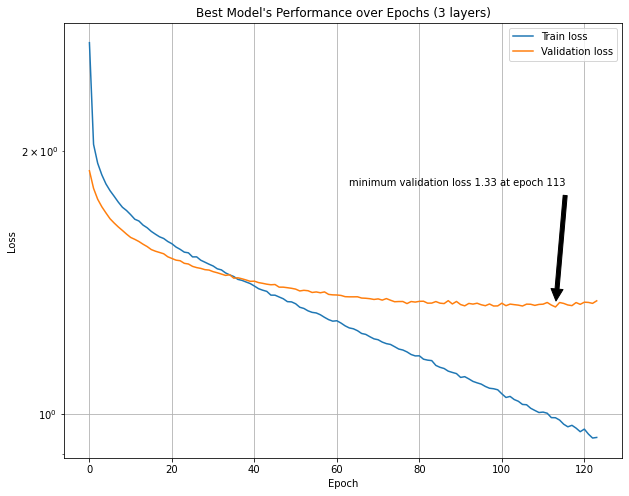

In [235]:
print("best score: ",gs.best_score_)
print("best params: ", gs.best_params_)
print("training time: ", sum(gs.best_estimator_.history[:, 'dur']))
best_3layer = gs.best_estimator_

# plotting training vs validation loss

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()

plt.semilogy(best_3layer.history[:, 'train_loss'], label='Train loss')
plt.semilogy(best_3layer.history[:, 'valid_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# annotating best validation loss score
ymin = min(best_3layer.history[:, 'valid_loss'])
xpos = best_3layer.history[:, 'valid_loss'].index(ymin)
xmin = best_3layer.history[:, 'valid_loss'][xpos]
ax.annotate('minimum validation loss {0} at epoch {1}'.format(str(round(ymin, 2)), str(xpos)),
            xy = (xpos, ymin), xytext = (xpos - 50, ymin + 0.5), arrowprops=dict(facecolor='black', shrink=0.05))


plt.title("Best Model's Performance over Epochs (3 layers)")
plt.grid()
plt.legend()
plt.show()      

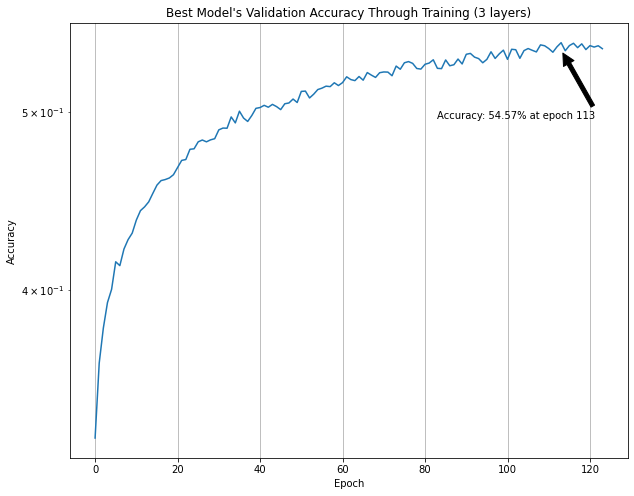

In [236]:
# annotating code aided with: https://stackoverflow.com/questions/43374920/how-to-automatically-annotate-maximum-value-in-pyplot

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()

plt.semilogy(best_3layer.history[:, 'valid_acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

ymax = max(best_3layer.history[:, 'valid_acc'])
xpos = best_3layer.history[:, 'valid_acc'].index(ymax)
xmin = best_3layer.history[:, 'valid_acc'][xpos]
ax.annotate('Accuracy: {0}% at epoch {1}'.format(str(round(ymax * 100, 2)), str(xpos)),
            xy = (xpos, ymax - 0.005), xytext = (xpos - 30, ymax-0.05), arrowprops=dict(facecolor='black', shrink=0.05))


plt.title("Best Model's Validation Accuracy Through Training (3 layers)")
plt.grid()
plt.show()    

In [232]:
print("training time: ", sum(gs.best_estimator_.history[:, 'dur']))

training time:  4057.8298528194427


Given the fine margins in improvement of validation accuracy between 2 and 3 hidden layers, and the vastly larger margins in computation time (1607s for 2 layers, ___ for 3), the tradeoff is not deemed to be worth the extra accuracy. This meagre difference in performance is supported by the claim that there is no scientific reason why a NN would need more than 2 hidden layers. []. One more gridsearch will therefore be conducted with two hidden layers, exploring greater yet numbers of nodes in the two hidden layers, given that the best performing models for both the original 2 layer search and the 3 layers search saw the highest possible number of nodes for some layers produce the best cross-validation results. SGD will be used, as will the smallest learning rate, given they have both prevailed as optimum hyperparameters from all 3 gridsearches hitherto on this data set.

# 2 Hidden Layers (cont.)

In [237]:
from skorch import NeuralNetClassifier

# defining callbacks to be input in to the skorch classifier

earlystopping = skorch.callbacks.EarlyStopping(monitor = 'valid_acc', lower_is_better = False,
                                               patience = 10, threshold_mode = 'abs')

checkpoint = skorch.callbacks.Checkpoint(monitor = 'valid_acc_best')

# defining the classifier object


mlpskorch = NeuralNetClassifier(
        mlp,
        criterion = nn.CrossEntropyLoss,
        max_epochs = 200,
        lr = lr,
        callbacks = [earlystopping, checkpoint]
        )

In [238]:
# Specifying parameters to be searched through

params = {'module__nodes1': [2000, 1500, 1000],
          'module__nodes2': [250, 500, 1000],
          'optimizer__momentum': [0.7, 0.9, 0.99]
          }

gs = GridSearchCV(mlpskorch, params, verbose = 2, cv = 2, scoring = 'accuracy')

In [239]:
# fitting the model

best_mdl_2 = gs.fit(xTrain, yTrain)

Fitting 2 folds for each of 27 candidates, totalling 54 fits
[CV] module__nodes1=2000, module__nodes2=250, optimizer__momentum=0.7 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  epoch    train_loss    valid_acc    valid_loss    cp      dur
-------  ------------  -----------  ------------  ----  -------
      1        3.1535       0.1496        2.2272     +  13.0060
      2        2.1936       0.2290        2.0946     +  13.5139
      3        2.1277       0.2502        2.0055     +  14.0003
      4        2.0814       0.2718        1.9699     +  13.9800
      5        2.0516       0.2932        1.9408     +  13.9501
      6        2.0276       0.2850        1.9113        14.2639
      7        2.0016       0.3012        1.8989     +  14.1477
      8        1.9864       0.3100        1.8707     +  14.1001
      9        1.9638       0.3428        1.8457     +  14.0892
     10        1.9470       0.3526        1.8348     +  14.0187
     11        1.9326       0.3564        1.8269     +  14.1808
     12        1.9197       0.3462        1.8133        14.1794
     13        1.9106       0.3578        1.7972     +  14.0684
     14        1.8978       0.3566      

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 19.9min remaining:    0.0s


  epoch    train_loss    valid_acc    valid_loss    cp      dur
-------  ------------  -----------  ------------  ----  -------
      1        3.2402       0.1848        2.2075     +  12.5799
      2        2.2309       0.1984        2.1617     +  12.1615
      3        2.1746       0.2550        2.0609     +  12.2091
      4        2.1167       0.2686        1.9977     +  12.2624
      5        2.0560       0.2846        1.9452     +  12.2190
      6        2.0200       0.2974        1.9184     +  12.2349
      7        1.9828       0.2940        1.9013        12.2549
      8        1.9638       0.3074        1.8809     +  12.5381
      9        1.9448       0.3218        1.8658     +  12.3243
     10        1.9269       0.3330        1.8268     +  12.2580
     11        1.9013       0.3370        1.8235     +  12.2026
     12        1.8835       0.3432        1.8109     +  12.2468
     13        1.8749       0.3492        1.8046     +  12.3722
     14        1.8616       0.3530      

    100        1.0868       0.4774        1.5249        11.9158
    101        1.0841       0.4696        1.5375        11.9127
    102        1.0814       0.4802        1.5389        11.8394
    103        1.0756       0.4824        1.5266     +  11.9273
    104        1.0668       0.4836        1.5232     +  11.9473
    105        1.0594       0.4748        1.5348        11.8964
    106        1.0464       0.4848        1.5198     +  12.0983
    107        1.0344       0.4816        1.5351        11.9273
    108        1.0350       0.4790        1.5387        11.9291
    109        1.0307       0.4872        1.5332     +  11.8332
    110        1.0154       0.4832        1.5502        11.9199
    111        1.0077       0.4864        1.5385        11.9235
    112        1.0093       0.4862        1.5425        11.8488
    113        1.0006       0.4818        1.5415        11.8615
    114        0.9863       0.4862        1.5429        11.8074
    115        0.9873       0.4826      

     64        1.2811       0.4818        1.4878     +  12.2098
     65        1.2707       0.4706        1.5131        12.0998
     66        1.2627       0.4732        1.4978        12.1663
     67        1.2488       0.4708        1.5019        12.1822
     68        1.2389       0.4736        1.5230        12.1846
     69        1.2200       0.4740        1.5161        12.3724
     70        1.1964       0.4770        1.5139        12.1784
     71        1.1909       0.4734        1.5018        12.2340
     72        1.1869       0.4786        1.5012        12.1278
     73        1.1730       0.4702        1.5076        12.0664
Stopping since valid_acc has not improved in the last 10 epochs.
[CV]  module__nodes1=2000, module__nodes2=250, optimizer__momentum=0.9, total=15.3min
[CV] module__nodes1=2000, module__nodes2=250, optimizer__momentum=0.9 
  epoch    train_loss    valid_acc    valid_loss    cp      dur
-------  ------------  -----------  ------------  ----  -------
      1   

     89        0.9201       0.4756        1.6477        12.1488
     90        0.9145       0.4830        1.6091        12.1757
     91        0.9051       0.4896        1.5745        12.3829
     92        0.9008       0.4900        1.5765        12.1360
     93        0.8863       0.4886        1.6102        12.1342
     94        0.8811       0.4900        1.6051        12.1474
     95        0.8724       0.4794        1.6506        12.1842
     96        0.8622       0.4820        1.6518        12.1549
     97        0.8418       0.4994        1.5768     +  12.1491
     98        0.8402       0.4956        1.6254        12.2373
     99        0.8228       0.4898        1.6219        12.2015
    100        0.8156       0.4840        1.6534        12.1172
    101        0.8347       0.4974        1.5864        12.2655
    102        0.8065       0.4868        1.6226        12.1232
    103        0.7931       0.4910        1.6419        12.0963
    104        0.7899       0.4880      

     49        1.4174       0.4664        1.5227        13.1783
     50        1.4036       0.4630        1.5209        13.1263
     51        1.4043       0.4684        1.5127     +  13.0726
     52        1.3878       0.4708        1.5078     +  13.0347
     53        1.3746       0.4734        1.5083     +  13.1389
     54        1.3608       0.4732        1.5034        13.1336
     55        1.3619       0.4736        1.5038     +  13.1278
     56        1.3517       0.4726        1.5029        13.2824
     57        1.3468       0.4780        1.5049     +  13.0388
     58        1.3328       0.4796        1.5000     +  13.0792
     59        1.3155       0.4760        1.4970        13.0400
     60        1.3135       0.4806        1.4978     +  13.1959
     61        1.3043       0.4792        1.4919        13.0992
     62        1.2913       0.4798        1.4924        12.9688
     63        1.2884       0.4844        1.4869     +  12.9976
     64        1.2776       0.4822      

     35        1.5235       0.4430        1.5575     +  13.1346
     36        1.5032       0.4466        1.5568     +  12.9296
     37        1.4904       0.4406        1.5580        12.9542
     38        1.4863       0.4444        1.5583        13.0894
     39        1.4804       0.4542        1.5482     +  12.9634
     40        1.4742       0.4500        1.5474        12.9773
     41        1.4646       0.4496        1.5465        12.9876
     42        1.4556       0.4526        1.5450        12.9059
     43        1.4414       0.4566        1.5330     +  13.1213
     44        1.4331       0.4578        1.5318     +  13.0347
     45        1.4307       0.4588        1.5342     +  12.8972
     46        1.4190       0.4562        1.5308        12.8567
     47        1.3997       0.4614        1.5244     +  12.8941
     48        1.3966       0.4538        1.5312        12.8896
     49        1.3855       0.4576        1.5273        12.9023
     50        1.3779       0.4600      

     22        1.6891       0.4226        1.6192        14.1938
     23        1.6695       0.4294        1.6121     +  14.2465
     24        1.6465       0.4336        1.5960     +  14.2314
     25        1.6352       0.4354        1.5908     +  14.2104
     26        1.6161       0.4392        1.5857     +  14.3121
     27        1.6000       0.4378        1.5770        14.2635
     28        1.5808       0.4334        1.5793        14.4091
     29        1.5705       0.4496        1.5567     +  14.2567
     30        1.5530       0.4518        1.5487     +  14.2655
     31        1.5346       0.4544        1.5444     +  14.2016
     32        1.5193       0.4520        1.5420        14.2506
     33        1.5117       0.4506        1.5373        14.1949
     34        1.4978       0.4638        1.5216     +  14.2138
     35        1.4736       0.4524        1.5307        14.1765
     36        1.4628       0.4590        1.5150        14.6345
     37        1.4458       0.4668      

     46        1.2454       0.4746        1.5033        13.5210
     47        1.2309       0.4686        1.5178        13.4795
     48        1.2223       0.4772        1.4931        13.5298
     49        1.2090       0.4810        1.5007     +  13.5289
     50        1.1911       0.4772        1.5106        13.5247
     51        1.1856       0.4718        1.5133        13.4744
     52        1.1735       0.4818        1.5019     +  13.5118
     53        1.1539       0.4830        1.4963     +  13.4681
     54        1.1430       0.4782        1.5210        13.4695
     55        1.1404       0.4916        1.5001     +  13.4308
     56        1.1263       0.4802        1.5090        13.3922
     57        1.1069       0.4834        1.5046        13.6434
     58        1.0893       0.4818        1.5290        13.5046
     59        1.0908       0.4940        1.4890     +  13.4745
     60        1.0705       0.4778        1.4982        13.5321
     61        1.0654       0.4856      

     38        1.3010       0.4760        1.5011        14.8648
     39        1.2963       0.4756        1.5001        14.9346
     40        1.2768       0.4774        1.4871        14.8681
     41        1.2698       0.4812        1.4856     +  14.9160
     42        1.2608       0.4780        1.4922        15.1579
     43        1.2439       0.4812        1.4867        14.9074
     44        1.2445       0.4762        1.4947        14.9069
     45        1.2228       0.4812        1.4864        14.9745
     46        1.2205       0.4792        1.4836        14.8854
     47        1.2071       0.4846        1.4775     +  14.8574
     48        1.2005       0.4802        1.4879        15.0472
     49        1.1934       0.4908        1.4828     +  14.9976
     50        1.1802       0.4884        1.4769        15.1389
     51        1.1702       0.4888        1.4826        15.0129
     52        1.1598       0.4894        1.4775        14.9550
     53        1.1542       0.4868      

      8        1.7238       0.4140        1.6558        17.0396
      9        1.6890       0.4278        1.6222     +  17.0356
     10        1.6567       0.4324        1.6113     +  17.0746
     11        1.6340       0.4386        1.5981     +  17.0091
     12        1.6127       0.4358        1.5937        17.2491
     13        1.5926       0.4482        1.5711     +  16.9954
     14        1.5733       0.4472        1.5638        17.1541
     15        1.5591       0.4496        1.5504     +  17.0658
     16        1.5405       0.4564        1.5477     +  17.1193
     17        1.5142       0.4570        1.5325     +  17.1328
     18        1.5057       0.4606        1.5369     +  17.1192
     19        1.4836       0.4622        1.5257     +  17.2368
     20        1.4682       0.4598        1.5213        17.4571
     21        1.4436       0.4640        1.5123     +  17.5696
     22        1.4232       0.4632        1.5019        17.2879
     23        1.4149       0.4724      

     33        1.2512       0.4666        1.5152        17.0689
     34        1.2292       0.4740        1.5142     +  17.0112
     35        1.2280       0.4830        1.4983     +  16.9885
     36        1.2097       0.4784        1.5157        16.9309
     37        1.1926       0.4850        1.4882     +  16.9841
     38        1.1823       0.4800        1.5009        16.9410
     39        1.1678       0.4792        1.5026        17.1320
     40        1.1534       0.4828        1.5017        16.9510
     41        1.1436       0.4850        1.4986        16.9712
     42        1.1320       0.4766        1.4999        16.9166
     43        1.1167       0.4762        1.4996        16.9775
     44        1.1034       0.4682        1.5487        16.9292
     45        1.0896       0.4890        1.4955     +  16.9081
     46        1.0805       0.4764        1.5094        17.1599
     47        1.0736       0.4868        1.5096        16.9719
     48        1.0527       0.4930      

     44        1.5542       0.4430        1.5626        9.1590
     45        1.5436       0.4430        1.5689        9.1827
     46        1.5432       0.4428        1.5619        9.1379
     47        1.5379       0.4490        1.5544     +  9.1798
     48        1.5205       0.4502        1.5478     +  9.0953
     49        1.5230       0.4522        1.5497     +  9.0852
     50        1.5053       0.4516        1.5401        9.1085
     51        1.5021       0.4512        1.5396        9.1591
     52        1.4888       0.4546        1.5422     +  9.1341
     53        1.4837       0.4520        1.5411        9.1239
     54        1.4811       0.4528        1.5381        9.3363
     55        1.4720       0.4584        1.5284     +  9.2190
     56        1.4620       0.4578        1.5266        9.1804
     57        1.4592       0.4598        1.5227     +  9.1576
     58        1.4483       0.4658        1.5230     +  9.2289
     59        1.4388       0.4574        1.5192       

     46        1.5592       0.4314        1.5903     +  13.5353
     47        1.5442       0.4396        1.5860     +  13.7619
     48        1.5390       0.4326        1.5846        13.5445
     49        1.5280       0.4302        1.5871        13.2584
     50        1.5202       0.4392        1.5778        12.8850
     51        1.5105       0.4382        1.5764        13.1989
     52        1.5111       0.4472        1.5715     +  13.5616
     53        1.4985       0.4424        1.5688        12.7133
     54        1.4915       0.4478        1.5635     +  12.8500
     55        1.4864       0.4460        1.5607        13.0156
     56        1.4702       0.4494        1.5503     +  12.4427
     57        1.4681       0.4462        1.5651        12.6854
     58        1.4495       0.4474        1.5519        13.4232
     59        1.4485       0.4522        1.5500     +  18.2163
     60        1.4417       0.4578        1.5399     +  15.0373
     61        1.4344       0.4518      

     37        1.6178       0.4292        1.5817     +  12.9766
     38        1.6018       0.4446        1.5624     +  15.7951
     39        1.5933       0.4386        1.5670        13.8659
     40        1.5690       0.4424        1.5501        13.5861
     41        1.5633       0.4418        1.5571        13.1259
     42        1.5382       0.4396        1.5636        13.1250
     43        1.5282       0.4488        1.5381     +  12.8194
     44        1.5095       0.4478        1.5364        12.6285
     45        1.4999       0.4542        1.5238     +  13.1437
     46        1.4828       0.4522        1.5240        12.7382
     47        1.4703       0.4580        1.5191     +  12.9457
     48        1.4553       0.4656        1.5169     +  13.0220
     49        1.4459       0.4666        1.5027     +  13.1729
     50        1.4373       0.4684        1.5062     +  13.1673
     51        1.4221       0.4684        1.4969        13.1268
     52        1.4167       0.4618      

     42        1.7640       0.3816        1.6902     +  13.1812
     43        1.7412       0.3876        1.6844     +  13.1886
     44        1.7264       0.4016        1.6562     +  13.1428
     45        1.7109       0.3978        1.6667        12.9406
     46        1.6872       0.4052        1.6481     +  12.8260
     47        1.6724       0.4022        1.6504        12.9629
     48        1.6586       0.4104        1.6208     +  12.9494
     49        1.6444       0.4066        1.6329        13.0731
     50        1.6203       0.4232        1.5964     +  13.5726
     51        1.6050       0.4190        1.6002        13.1548
     52        1.5907       0.4234        1.5920     +  12.7909
     53        1.5823       0.4250        1.5871     +  12.7588
     54        1.5573       0.4242        1.5879        12.9293
     55        1.5544       0.4262        1.5835     +  12.9659
     56        1.5364       0.4326        1.5732     +  12.8219
     57        1.5181       0.4434      

      2        2.1685       0.2782        2.0151     +  14.2140
      3        2.0741       0.3034        1.9258     +  13.9977
      4        2.0134       0.3194        1.8892     +  14.2083
      5        1.9767       0.3352        1.8586     +  14.1302
      6        1.9446       0.3480        1.8264     +  13.9765
      7        1.9126       0.3618        1.7972     +  13.9050
      8        1.8864       0.3788        1.7756     +  13.6050
      9        1.8628       0.3770        1.7643        13.6586
     10        1.8417       0.3862        1.7466     +  13.5855
     11        1.8100       0.3960        1.7189     +  13.7098
     12        1.8009       0.3936        1.7151        14.1544
     13        1.7805       0.3984        1.7126     +  14.0273
     14        1.7680       0.4042        1.6919     +  14.1306
     15        1.7471       0.4078        1.6789     +  14.0231
     16        1.7383       0.4140        1.6700     +  13.6888
     17        1.7263       0.4112      

    104        1.0033       0.4898        1.4915        14.5566
    105        0.9962       0.4904        1.4840        13.9981
    106        0.9963       0.4900        1.4782        13.4342
Stopping since valid_acc has not improved in the last 10 epochs.
[CV]  module__nodes1=1500, module__nodes2=500, optimizer__momentum=0.7, total=25.9min
[CV] module__nodes1=1500, module__nodes2=500, optimizer__momentum=0.7 
  epoch    train_loss    valid_acc    valid_loss    cp      dur
-------  ------------  -----------  ------------  ----  -------
      1        3.5635       0.2282        2.1035     +  13.3086
      2        2.1929       0.2600        2.0117     +  13.3833
      3        2.0864       0.2752        1.9591     +  14.1923
      4        2.0167       0.3036        1.9010     +  17.9997
      5        1.9611       0.3300        1.8614     +  21.7761
      6        1.9215       0.3256        1.8469        15.5467
      7        1.8909       0.3296        1.8268        14.5010
      8   

     96        0.9927       0.4930        1.5141        13.6539
     97        0.9936       0.4868        1.5379        14.9046
     98        0.9737       0.4854        1.5352        14.0390
     99        0.9813       0.4898        1.5287        13.6350
    100        0.9718       0.4890        1.5132        13.7939
    101        0.9579       0.4854        1.5322        14.0648
    102        0.9585       0.4930        1.5134        14.2726
    103        0.9485       0.4928        1.5168        13.7395
    104        0.9434       0.4840        1.5405        14.0659
    105        0.9376       0.4940        1.5181     +  13.7171
    106        0.9310       0.4868        1.5332        14.1384
    107        0.9209       0.4942        1.5286     +  13.4546
    108        0.9215       0.4924        1.5296        13.7050
    109        0.9166       0.4946        1.5425     +  13.5090
    110        0.9090       0.4906        1.5419        13.6968
    111        0.8950       0.4936      

     37        1.4222       0.4698        1.4974     +  14.8202
     38        1.3955       0.4706        1.4992     +  15.0357
     39        1.3967       0.4638        1.4885        15.2717
     40        1.3762       0.4716        1.4920     +  14.9367
     41        1.3618       0.4784        1.4838     +  15.3001
     42        1.3517       0.4800        1.4882     +  15.1075
     43        1.3516       0.4758        1.4843        15.7244
     44        1.3290       0.4772        1.4758        15.3453
     45        1.3213       0.4708        1.4909        15.2478
     46        1.2985       0.4836        1.4841     +  15.0768
     47        1.2961       0.4776        1.4750        15.3456
     48        1.2814       0.4830        1.4643        15.4240
     49        1.2728       0.4752        1.4837        15.3993
     50        1.2709       0.4846        1.4782     +  15.1880
     51        1.2450       0.4864        1.4693     +  15.8194
     52        1.2406       0.4894      

     27        1.4739       0.4554        1.5423     +  12.0118
     28        1.4658       0.4510        1.5464        12.1933
     29        1.4467       0.4630        1.5317     +  12.0115
     30        1.4297       0.4618        1.5374        12.2644
     31        1.4122       0.4566        1.5346        11.6584
     32        1.4082       0.4578        1.5360        11.5226
     33        1.3913       0.4622        1.5234        11.4772
     34        1.3866       0.4662        1.5225     +  11.4321
     35        1.3690       0.4672        1.5122     +  11.4546
     36        1.3486       0.4770        1.4977     +  11.3671
     37        1.3402       0.4750        1.5039        11.3135
     38        1.3238       0.4708        1.5060        11.2871
     39        1.3122       0.4726        1.5037        11.4556
     40        1.3032       0.4742        1.4986        11.2181
     41        1.2953       0.4680        1.4981        11.2606
     42        1.2770       0.4790      

     28        1.4091       0.4458        1.5666        12.2525
     29        1.3918       0.4492        1.5606     +  12.3679
     30        1.3881       0.4510        1.5605     +  12.2817
     31        1.3769       0.4436        1.5617        12.1946
     32        1.3713       0.4522        1.5622     +  12.1769
     33        1.3477       0.4574        1.5535     +  12.2120
     34        1.3386       0.4466        1.5555        12.1391
     35        1.3288       0.4554        1.5492        12.2126
     36        1.3223       0.4550        1.5493        12.1932
     37        1.3061       0.4624        1.5408     +  12.2023
     38        1.2991       0.4558        1.5421        12.4193
     39        1.2859       0.4640        1.5384     +  12.3654
     40        1.2741       0.4638        1.5300        12.2742
     41        1.2742       0.4610        1.5442        12.1426
     42        1.2600       0.4626        1.5375        12.1473
     43        1.2515       0.4556      

     34        1.3220       0.4386        1.6123        12.1436
     35        1.3097       0.4470        1.5924     +  12.0951
     36        1.2925       0.4366        1.6114        12.1930
     37        1.2875       0.4380        1.6125        12.1202
     38        1.2778       0.4458        1.6032        12.1210
     39        1.2637       0.4446        1.6116        12.0961
     40        1.2550       0.4388        1.6004        12.0433
     41        1.2394       0.4478        1.5861     +  12.2910
     42        1.2305       0.4468        1.6094        12.2196
     43        1.2265       0.4494        1.5870     +  12.1104
     44        1.2104       0.4500        1.5875     +  12.1172
     45        1.2013       0.4450        1.5952        12.2318
     46        1.1987       0.4538        1.5796     +  12.1351
     47        1.1841       0.4550        1.5910     +  12.1657
     48        1.1765       0.4582        1.5836     +  12.1368
     49        1.1655       0.4506      

     46        1.1344       0.4714        1.5127        13.8905
     47        1.1295       0.4786        1.5140        14.7105
     48        1.1079       0.4786        1.5164        13.9577
     49        1.1043       0.4746        1.5066        13.9311
     50        1.0905       0.4830        1.5035     +  13.8994
     51        1.0827       0.4800        1.5102        13.9520
     52        1.0725       0.4764        1.5288        14.1390
     53        1.0501       0.4856        1.5362     +  13.9405
     54        1.0501       0.4794        1.5315        13.9562
     55        1.0471       0.4754        1.5263        13.9634
     56        1.0423       0.4844        1.5498        13.9203
     57        1.0207       0.4796        1.5389        13.9196
     58        1.0088       0.4722        1.5620        13.9205
     59        1.0000       0.4780        1.5617        13.9883
     60        0.9851       0.4814        1.5408        14.0290
     61        0.9909       0.4830      

Stopping since valid_acc has not improved in the last 10 epochs.
[CV]  module__nodes1=1500, module__nodes2=1000, optimizer__momentum=0.99, total= 2.4min
[CV] module__nodes1=1500, module__nodes2=1000, optimizer__momentum=0.99 
  epoch    train_loss    valid_acc    valid_loss    cp      dur
-------  ------------  -----------  ------------  ----  -------
      1        6.0741       0.1058        2.2917     +  11.7480
      2        2.2944       0.1124        2.2948     +  11.7010
      3        2.3034       0.1000        2.3028        11.6947
      4        2.3028       0.1000        2.3027        11.6662
      5        2.3013       0.1280        2.2790     +  11.6639
      6        2.2945       0.1000        2.3027        11.6657
      7        2.3028       0.1000        2.3027        11.6969
      8        2.3031       0.1000        2.3027        11.6204
      9        2.3027       0.1000        2.3027        11.6345
     10        2.3030       0.1000        2.3027        11.6475
     1

     81        1.3186       0.4670        1.5160        6.7475
     82        1.3173       0.4664        1.5159        6.6138
     83        1.3079       0.4636        1.5184        6.5531
     84        1.2988       0.4684        1.5124        6.5865
     85        1.2954       0.4684        1.5052        6.5433
     86        1.2861       0.4714        1.5076     +  6.6032
     87        1.2889       0.4722        1.5046     +  6.6333
     88        1.2778       0.4714        1.5038        6.5169
     89        1.2685       0.4708        1.5105        6.5803
     90        1.2614       0.4712        1.5055        6.5907
     91        1.2624       0.4820        1.5004     +  6.5342
     92        1.2455       0.4720        1.5152        6.5672
     93        1.2452       0.4752        1.5082        6.5081
     94        1.2419       0.4760        1.4947        6.5385
     95        1.2347       0.4744        1.5058        6.5588
     96        1.2323       0.4746        1.5055       

     63        1.4041       0.4532        1.5541        6.5855
     64        1.3941       0.4568        1.5446        6.5512
     65        1.3904       0.4510        1.5582        6.5386
     66        1.3755       0.4518        1.5549        6.5353
     67        1.3704       0.4552        1.5492        6.6118
     68        1.3639       0.4582        1.5474        6.5739
     69        1.3590       0.4536        1.5519        6.5638
     70        1.3523       0.4618        1.5381     +  6.5699
     71        1.3463       0.4596        1.5416        6.7232
     72        1.3355       0.4466        1.5643        6.5935
     73        1.3366       0.4616        1.5378        6.5935
     74        1.3290       0.4640        1.5321     +  6.6074
     75        1.3134       0.4568        1.5458        6.6872
     76        1.3173       0.4562        1.5357        6.6080
     77        1.3102       0.4642        1.5423     +  6.5620
     78        1.3037       0.4622        1.5419       

     44        1.5039       0.4550        1.5304     +  7.3448
     45        1.4850       0.4526        1.5230        7.3471
     46        1.4745       0.4602        1.5186     +  7.3784
     47        1.4700       0.4594        1.5195        7.3692
     48        1.4573       0.4628        1.5076     +  7.3273
     49        1.4510       0.4602        1.5035        7.3464
     50        1.4272       0.4548        1.5146        7.3510
     51        1.4257       0.4568        1.5154        7.2908
     52        1.4169       0.4614        1.5083        7.4176
     53        1.4112       0.4636        1.5055     +  7.4382
     54        1.3947       0.4554        1.4985        7.4870
     55        1.3890       0.4560        1.5055        7.3635
     56        1.3951       0.4672        1.4902     +  7.5383
     57        1.3722       0.4664        1.4974        7.4694
     58        1.3628       0.4688        1.4917     +  7.3672
     59        1.3562       0.4692        1.5002     + 

     26        1.6592       0.4206        1.6210     +  6.9892
     27        1.6432       0.4200        1.6239        6.9708
     28        1.6343       0.4180        1.6269        6.9704
     29        1.6178       0.4258        1.5914     +  6.9542
     30        1.6048       0.4150        1.6211        7.0268
     31        1.5881       0.4338        1.5890     +  7.1610
     32        1.5780       0.4362        1.5777     +  7.0783
     33        1.5622       0.4358        1.5793        6.9938
     34        1.5481       0.4430        1.5756     +  6.9815
     35        1.5372       0.4418        1.5688        7.0146
     36        1.5338       0.4370        1.5769        7.0079
     37        1.5133       0.4452        1.5653     +  7.0853
     38        1.4994       0.4400        1.5706        6.9946
     39        1.5036       0.4540        1.5396     +  6.9382
     40        1.4795       0.4498        1.5491        7.0108
     41        1.4729       0.4418        1.5528       

     13        1.7176       0.4106        1.6833     +  7.1005
     14        1.7002       0.4066        1.6870        7.0215
     15        1.6919       0.4158        1.6733     +  7.0759
     16        1.6724       0.4288        1.6615     +  7.1222
     17        1.6462       0.4186        1.6668        7.0652
     18        1.6289       0.4192        1.6610        7.0470
     19        1.6266       0.4184        1.6517        7.0707
     20        1.6021       0.4226        1.6448        7.0723
     21        1.5915       0.4254        1.6397        7.0982
     22        1.5733       0.4326        1.6275     +  7.0959
     23        1.5692       0.4284        1.6274        7.1388
     24        1.5512       0.4356        1.6232     +  7.2302
     25        1.5393       0.4342        1.6246        7.1656
     26        1.5343       0.4388        1.6155     +  7.1420
     27        1.5163       0.4378        1.6045        7.0938
     28        1.5011       0.4408        1.5932     + 

     46        1.3387       0.4464        1.5909        7.1199
     47        1.3300       0.4546        1.5817     +  7.1327
     48        1.3239       0.4500        1.5938        7.1421
     49        1.3055       0.4522        1.5930        7.1045
     50        1.3021       0.4440        1.5915        7.1142
     51        1.3031       0.4484        1.5980        7.1001
     52        1.2943       0.4566        1.5801     +  7.0946
     53        1.2785       0.4530        1.5807        7.1120
     54        1.2766       0.4548        1.5724        7.1022
     55        1.2645       0.4424        1.5973        7.1457
     56        1.2622       0.4510        1.5880        7.1370
     57        1.2488       0.4564        1.5754        7.1461
     58        1.2451       0.4528        1.5905        7.2154
     59        1.2397       0.4598        1.5715     +  7.2264
     60        1.2319       0.4568        1.5866        7.2271
     61        1.2234       0.4582        1.5707       

[CV]  module__nodes1=1000, module__nodes2=500, optimizer__momentum=0.9, total= 7.6min
[CV] module__nodes1=1000, module__nodes2=500, optimizer__momentum=0.9 
  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        3.8588       0.2580        2.0163     +  7.0317
      2        2.0433       0.3254        1.8825     +  7.0779
      3        1.9445       0.3326        1.8338     +  6.9993
      4        1.8927       0.3464        1.7881     +  7.0563
      5        1.8426       0.3612        1.7683     +  7.1057
      6        1.8095       0.3786        1.7335     +  7.7237
      7        1.7826       0.3884        1.7176     +  7.9113
      8        1.7477       0.3878        1.6919        7.7992
      9        1.7317       0.3844        1.6859        7.8175
     10        1.7046       0.3942        1.6723     +  7.8121
     11        1.6876       0.4054        1.6515     +  7.8378
     12        1.6640   

      2        2.1162       0.3058        1.9498     +  8.2291
      3        2.0314       0.3204        1.9049     +  8.2392
      4        1.9743       0.3390        1.8751     +  8.2166
      5        1.9312       0.3508        1.8485     +  8.2374
      6        1.8989       0.3596        1.8378     +  8.4660
      7        1.8705       0.3726        1.8066     +  8.4146
      8        1.8362       0.3738        1.7785     +  8.2758
      9        1.8164       0.3790        1.7772     +  8.2386
     10        1.7905       0.3874        1.7534     +  8.2878
     11        1.7646       0.3938        1.7522     +  8.2821
     12        1.7440       0.3978        1.7309     +  8.2582
     13        1.7319       0.4024        1.7130     +  8.2999
     14        1.7171       0.4028        1.7185     +  8.3083
     15        1.7031       0.4006        1.6979        8.3234
     16        1.6822       0.4112        1.6980     +  8.3277
     17        1.6679       0.4050        1.6869       

     13        1.7123       0.3626        1.7845     +  8.2018
     14        1.6913       0.3672        1.7905     +  8.3918
     15        1.6832       0.3744        1.7724     +  8.3510
     16        1.6717       0.3694        1.7671        8.2181
     17        1.6469       0.3744        1.7609        8.2723
     18        1.6345       0.3814        1.7474     +  8.2126
     19        1.6257       0.4000        1.7180     +  8.2526
     20        1.5983       0.3862        1.7493        8.2770
     21        1.5969       0.3926        1.7297        8.2637
     22        1.5843       0.3874        1.7489        8.2323
     23        1.5672       0.3692        1.7874        8.2111
     24        1.5532       0.3872        1.7373        8.2219
     25        1.5390       0.3922        1.7491        8.2679
     26        1.5341       0.3948        1.7278        8.2633
     27        1.5158       0.4058        1.7049     +  8.2062
     28        1.5109       0.4032        1.7067       

     62        1.2260       0.4562        1.5842        10.3866
     63        1.2199       0.4562        1.5672        10.6905
     64        1.2147       0.4560        1.5916        10.3034
     65        1.2074       0.4516        1.5941        10.3066
     66        1.1987       0.4632        1.5717     +  10.2832
     67        1.2027       0.4546        1.5989        10.3408
     68        1.1773       0.4594        1.5823        10.3270
     69        1.1735       0.4570        1.5938        10.2803
     70        1.1650       0.4586        1.5901        10.2673
     71        1.1652       0.4456        1.6110        10.2349
     72        1.1480       0.4574        1.6122        10.2889
     73        1.1379       0.4566        1.6199        10.2292
     74        1.1497       0.4578        1.6099        10.4004
     75        1.1392       0.4570        1.6144        10.2738
Stopping since valid_acc has not improved in the last 10 epochs.
[CV]  module__nodes1=1000, module__node

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed: 664.5min finished


  epoch    train_loss    valid_acc    valid_loss    cp      dur
-------  ------------  -----------  ------------  ----  -------
      1        3.0070       0.2779        1.9712     +  20.3818
      2        1.9967       0.3274        1.8612     +  20.3608
      3        1.9154       0.3475        1.8200     +  21.4785
      4        1.8591       0.3755        1.7583     +  22.3758
      5        1.8159       0.3841        1.7206     +  22.3140
      6        1.7773       0.4016        1.6782     +  22.3035
      7        1.7381       0.4123        1.6441     +  22.3637
      8        1.7123       0.4181        1.6307     +  22.4738
      9        1.6892       0.4256        1.6160     +  22.6058
     10        1.6576       0.4378        1.5749     +  22.2683
     11        1.6332       0.4477        1.5666     +  22.2631
     12        1.6157       0.4449        1.5595        22.2596
     13        1.5980       0.4545        1.5300     +  23.2398
     14        1.5753       0.4500      

best score:  0.49214
best params:  {'module__nodes1': 1500, 'module__nodes2': 500, 'optimizer__momentum': 0.9}
training time:  1929.025996685028


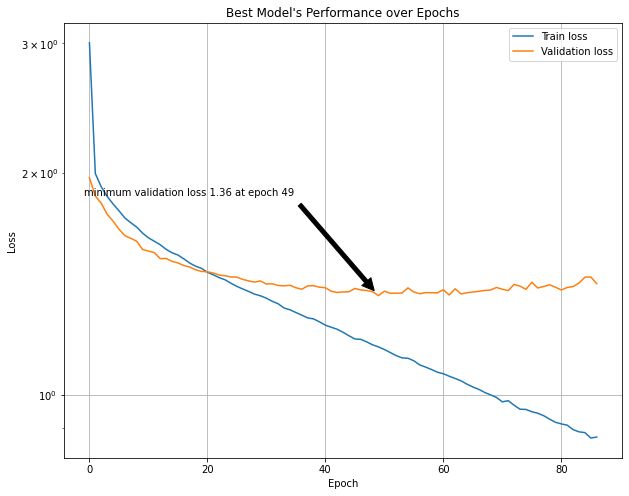

In [241]:
print("best score: ",gs.best_score_)
print("best params: ", gs.best_params_)
print("training time: ", sum(gs.best_estimator_.history[:, 'dur']))
best_2layer_cont = gs.best_estimator_

# plotting training vs validation loss

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()

plt.semilogy(best_2layer_cont.history[:, 'train_loss'], label='Train loss')
plt.semilogy(best_2layer_cont.history[:, 'valid_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# annotating best validation loss score
ymin = min(best_2layer_cont.history[:, 'valid_loss'])
xpos = best_2layer_cont.history[:, 'valid_loss'].index(ymin)
xmin = best_2layer_cont.history[:, 'valid_loss'][xpos]
ax.annotate('minimum validation loss {0} at epoch {1}'.format(str(round(ymin, 2)), str(xpos)),
            xy = (xpos, ymin), xytext = (xpos - 50, ymin + 0.5), arrowprops=dict(facecolor='black', shrink=0.05))


plt.title("Best Model's Performance over Epochs")
plt.grid()
plt.legend()
plt.show()      

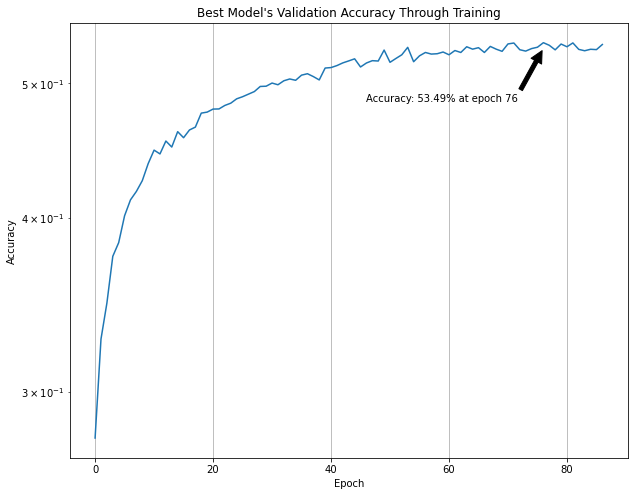

In [242]:
# annotating code aided with: https://stackoverflow.com/questions/43374920/how-to-automatically-annotate-maximum-value-in-pyplot

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()

plt.semilogy(best_2layer_cont.history[:, 'valid_acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

ymax = max(best_2layer_cont.history[:, 'valid_acc'])
xpos = best_2layer_cont.history[:, 'valid_acc'].index(ymax)
xmin = best_2layer_cont.history[:, 'valid_acc'][xpos]
ax.annotate('Accuracy: {0}% at epoch {1}'.format(str(ymax * 100), str(xpos)),
            xy = (xpos, ymax - 0.005), xytext = (xpos - 30, ymax-0.05), arrowprops=dict(facecolor='black', shrink=0.05))


plt.title("Best Model's Validation Accuracy Through Training")
plt.grid()
plt.show()    

In [188]:
print("training time: ", sum(gs.best_estimator_.history[:, 'dur']))

training time:  1607.5434184074402


In [243]:
best_mlp = best_2layer_cont

In [249]:
best_mlp.save_params(f_params = 'mlp_mdl.pkl', f_optimizer='mlp_opt.pkl', f_history='history.json')

After the preceding results on the cross-validation stage, the optimum parameters for an MLP were found to be:

> __Hidden Layers: 2 (1500 and 500 nodes respectively, dropout: 0.2, learning rate: 0.0001, optimizer: SGD, momentum: 0.9.__


Now on to the convolutional neural network.

# Defining the convolutional neural network (CNN)

References for CNN section: 
> https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

> https://medium.com/datadriveninvestor/train-a-cnn-using-skorch-for-mnist-digit-recognition-53d7d2f971c7


# <font color='red'> CNN Hyperparameters</font>

In [28]:
# variables #
num_epochs = 20 # <--- # hyperparameter #

lr = 1e-4 # <--- # hyperparameter #

criterion = nn.CrossEntropyLoss() # different loss functions are available but this one is ackknowledged for classification

dropout = 0.2 # <--- hyperparameter

batch_size = 32

#optimizer = torch.optim.Adam(cnn.parameters, lr = lr)

# mlp number of nodes

conv1 = 32
conv2 = 64
conv3 = 512

dense1 = 1024
dense2 = 512

padding1 = 1
stride1 = 1

padding2 = 0
stride2 = 2


# learning rate initially set to 3e-4, which is recommended as not too slow or too large so that it would miss
# error minima/subtle fluctuation in performance*

## 2 convolutional layers

In [24]:
# convolutional neural network (CNN): base archictecture, which was the experimented with - taken from:
# https://medium.com/swlh/image-classification-with-cnn-4f2a501faadb

class cnn(nn.Module):
    def __init__(self, 
                dropout = dropout,
                conv1 = conv1, 
                conv2 = conv2,
                conv3 = conv3,
                dense1 = dense1,
                dense2 = dense2,
                stride1 = stride1,
                padding1 = padding1,
                stride2 = stride2,
                padding2 = padding2):
        super(cnn, self).__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, conv1, kernel_size=3, padding=padding1),
            nn.BatchNorm2d(conv1),
            nn.ReLU(inplace = True),
            nn.Conv2d(conv1, conv2, kernel_size=3, stride=stride1, padding=padding2),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16: 

            nn.Flatten(), 
            nn.Linear(conv2*16*16, dense1), # <--- make this *8*8 if using stride of 2 at stride2
            nn.ReLU(inplace = True),
            nn.Dropout(dropout),
            nn.Linear(dense1, dense2),
            nn.ReLU(inplace = True),
            nn.Linear(dense2, 10))
        
    def forward(self, i):
        return self.network(i)

Because the number of layers is 64 (conv2) and the dimensions 
of the images (32 x 32) are halved my the maxpool2d(2, 2) function. They continue to be halved below
(8 x 8), (4 x 4) etc. just the number of filters are changing with the conv2d, and the pooling changes
the other two dimensions. The halving of the dimensionc comes from the 2, 2 arguments of the pooling function. Basically means that for every 2x2 square of pixels, 1 pixel containing the maxmimum value from those 4 squares is passed to the next filter, thereby taking that 2x2 square to a 1x1 e.g. halved on both x and y dimensions.

### Training the evaluating CNN with <font color='orange'>Skorch</font>

Credit to Benjamin Bossan of skorch for resolving the following issue:
> https://github.com/skorch-dev/skorch/issues/745

In [25]:
# defining callbacks to be input in to the skorch classifier

from skorch import NeuralNetClassifier

earlystopping = skorch.callbacks.EarlyStopping(monitor = 'valid_acc', lower_is_better = False,
                                               patience = 3, threshold_mode = 'abs')

checkpoint = skorch.callbacks.Checkpoint(monitor = 'valid_acc_best')

# defining the classifier object


cnnskorch = NeuralNetClassifier(
        cnn,
        criterion = nn.CrossEntropyLoss,
        optimizer = torch.optim.Adam,
        batch_size = 64,
        max_epochs = 15,
        lr = lr,
        callbacks = [earlystopping, checkpoint]
        )

In [28]:
# Specifying parameters to be searched through

params = {'module__conv1': [16, 32],
          'module__conv2': [64, 128],
          
          'module__dense1': [1500, 1000],
          
          'batch_size': [64, 32]
          }

In [29]:
cnn_gs = GridSearchCV(cnnskorch, params, verbose = 2, cv = 2, scoring = 'accuracy')

In [45]:
xTrain2 = skorch.helper.SliceDataset(data, idx = 0)
yTrain2 = skorch.helper.SliceDataset(data, idx = 1)

In [39]:
cnn_gs.fit(xTrain2, yTrain)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] batch_size=64, module__conv1=16, module__conv2=64, module__dense1=1500 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  epoch    train_loss    valid_acc    valid_loss    cp       dur
-------  ------------  -----------  ------------  ----  --------
      1        1.8700       0.4108        1.5752     +  105.7272
      2        1.5413       0.4884        1.4065     +  116.3690
      3        1.3905       0.5316        1.3127     +  110.6522
      4        1.2724       0.5672        1.2101     +  112.1713
      5        1.1712       0.5976        1.1288     +  115.4838
      6        1.0786       0.6110        1.0759     +  111.1872
      7        0.9937       0.6254        1.0554     +  104.0909
      8        0.9205       0.6424        1.0265     +  103.1217
      9        0.8455       0.6476        1.0229     +  102.4931
     10        0.7789       0.6590        1.0147     +  101.7022
     11        0.7060       0.6608        1.0260     +  103.1337
     12        0.6380       0.6816        0.9743     +  100.1890
     13        0.5756       0.6822        0.9850     +  103.7103
     14        0.5124    

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 28.3min remaining:    0.0s


  epoch    train_loss    valid_acc    valid_loss    cp       dur
-------  ------------  -----------  ------------  ----  --------
      1        1.8672       0.3064        1.8309     +  154.1013
      2        1.5341       0.3614        1.7350     +  144.0538
      3        1.3883       0.4168        1.5930     +  155.3994
      4        1.2793       0.4532        1.4995     +  160.3986
      5        1.1803       0.4934        1.4100     +  155.5740
      6        1.0905       0.5356        1.3040     +  158.3023
      7        1.0054       0.5650        1.2383     +  152.2229
      8        0.9289       0.5954        1.1457     +  162.1874
      9        0.8586       0.6014        1.1403     +  164.6397
     10        0.7891       0.6220        1.0895     +  156.9785
     11        0.7167       0.6280        1.0879     +  156.1843
     12        0.6486       0.6320        1.0904     +  156.3393
     13        0.5816       0.6418        1.0852     +  160.7124
     14        0.5139    

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/classifier.py", line 142, in fit
    return super(NeuralNetClassifier, self).fit(X, y, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/net.py", line 903, in fit
    self.partial_fit(X, y, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/net.py", line 862, in partial_fit
    self.fit_loop(X, y, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/net.py", line 775, in fit_loop
    self.run_single_e

[CV]  batch_size=64, module__conv1=16, module__conv2=128, module__dense1=1500, total=   0.5s
[CV] batch_size=64, module__conv1=16, module__conv2=128, module__dense1=1500 


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/classifier.py", line 142, in fit
    return super(NeuralNetClassifier, self).fit(X, y, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/net.py", line 903, in fit
    self.partial_fit(X, y, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/net.py", line 862, in partial_fit
    self.fit_loop(X, y, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/net.py", line 775, in fit_loop
    self.run_single_e

[CV]  batch_size=64, module__conv1=16, module__conv2=128, module__dense1=1500, total=   0.2s
[CV] batch_size=64, module__conv1=16, module__conv2=128, module__dense1=1000 


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/classifier.py", line 142, in fit
    return super(NeuralNetClassifier, self).fit(X, y, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/net.py", line 903, in fit
    self.partial_fit(X, y, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/net.py", line 862, in partial_fit
    self.fit_loop(X, y, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/net.py", line 775, in fit_loop
    self.run_single_e

[CV]  batch_size=64, module__conv1=16, module__conv2=128, module__dense1=1000, total=   0.3s
[CV] batch_size=64, module__conv1=16, module__conv2=128, module__dense1=1000 


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/classifier.py", line 142, in fit
    return super(NeuralNetClassifier, self).fit(X, y, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/net.py", line 903, in fit
    self.partial_fit(X, y, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/net.py", line 862, in partial_fit
    self.fit_loop(X, y, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/net.py", line 775, in fit_loop
    self.run_single_e

[CV]  batch_size=64, module__conv1=16, module__conv2=128, module__dense1=1000, total=   0.2s
[CV] batch_size=64, module__conv1=32, module__conv2=64, module__dense1=1500 
  epoch    train_loss    valid_acc    valid_loss    cp       dur
-------  ------------  -----------  ------------  ----  --------
      1        1.8670       0.4254        1.5338     +  146.7205
      2        1.5090       0.4960        1.3884     +  145.9148
      3        1.3620       0.5392        1.2842     +  149.4512
      4        1.2500       0.5764        1.1839     +  150.8292
      5        1.1445       0.6052        1.1116     +  147.8970
      6        1.0474       0.6304        1.0599     +  165.9435
      7        0.9595       0.6418        1.0194     +  169.2673
      8        0.8779       0.6512        1.0076     +  152.7852
      9        0.7973       0.6688        0.9614     +  142.3685
     10        0.7234       0.6730        0.9832     +  178.6645
     11        0.6520       0.6766        0.9941  

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/classifier.py", line 142, in fit
    return super(NeuralNetClassifier, self).fit(X, y, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/net.py", line 903, in fit
    self.partial_fit(X, y, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/net.py", line 862, in partial_fit
    self.fit_loop(X, y, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/net.py", line 775, in fit_loop
    self.run_single_e

[CV]  batch_size=64, module__conv1=32, module__conv2=128, module__dense1=1500, total=   0.3s
[CV] batch_size=64, module__conv1=32, module__conv2=128, module__dense1=1500 


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/classifier.py", line 142, in fit
    return super(NeuralNetClassifier, self).fit(X, y, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/net.py", line 903, in fit
    self.partial_fit(X, y, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/net.py", line 862, in partial_fit
    self.fit_loop(X, y, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/net.py", line 775, in fit_loop
    self.run_single_e

[CV]  batch_size=64, module__conv1=32, module__conv2=128, module__dense1=1500, total=   0.2s
[CV] batch_size=64, module__conv1=32, module__conv2=128, module__dense1=1000 


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/classifier.py", line 142, in fit
    return super(NeuralNetClassifier, self).fit(X, y, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/net.py", line 903, in fit
    self.partial_fit(X, y, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/net.py", line 862, in partial_fit
    self.fit_loop(X, y, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/net.py", line 775, in fit_loop
    self.run_single_e

[CV]  batch_size=64, module__conv1=32, module__conv2=128, module__dense1=1000, total=   0.2s
[CV] batch_size=64, module__conv1=32, module__conv2=128, module__dense1=1000 


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/classifier.py", line 142, in fit
    return super(NeuralNetClassifier, self).fit(X, y, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/net.py", line 903, in fit
    self.partial_fit(X, y, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/net.py", line 862, in partial_fit
    self.fit_loop(X, y, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/net.py", line 775, in fit_loop
    self.run_single_e

[CV]  batch_size=64, module__conv1=32, module__conv2=128, module__dense1=1000, total=   0.2s
[CV] batch_size=32, module__conv1=16, module__conv2=64, module__dense1=1500 
  epoch    train_loss    valid_acc    valid_loss    cp       dur
-------  ------------  -----------  ------------  ----  --------
      1        1.8081       0.4618        1.4596     +  131.6900
      2        1.4119       0.5340        1.2881     +  147.0620
      3        1.2419       0.5852        1.1711     +  146.5314
      4        1.0985       0.6164        1.0783     +  132.3491
      5        0.9780       0.6454        1.0055     +  128.9236
      6        0.8684       0.6608        0.9626     +  126.1440
      7        0.7672       0.6796        0.9331     +  123.3513
      8        0.6672       0.6894        0.9301     +  126.0419
      9        0.5700       0.6846        0.9597        147.6690
     10        0.4734       0.6874        0.9993        149.7291
Stopping since valid_acc has not improved in the l

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/classifier.py", line 142, in fit
    return super(NeuralNetClassifier, self).fit(X, y, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/net.py", line 903, in fit
    self.partial_fit(X, y, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/net.py", line 862, in partial_fit
    self.fit_loop(X, y, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/net.py", line 775, in fit_loop
    self.run_single_e

[CV]  batch_size=32, module__conv1=16, module__conv2=128, module__dense1=1500, total=   0.1s
[CV] batch_size=32, module__conv1=16, module__conv2=128, module__dense1=1000 
[CV]  batch_size=32, module__conv1=16, module__conv2=128, module__dense1=1000, total=   0.1s
[CV] batch_size=32, module__conv1=16, module__conv2=128, module__dense1=1000 


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/classifier.py", line 142, in fit
    return super(NeuralNetClassifier, self).fit(X, y, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/net.py", line 903, in fit
    self.partial_fit(X, y, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/net.py", line 862, in partial_fit
    self.fit_loop(X, y, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/net.py", line 775, in fit_loop
    self.run_single_e

[CV]  batch_size=32, module__conv1=16, module__conv2=128, module__dense1=1000, total=   0.1s
[CV] batch_size=32, module__conv1=32, module__conv2=64, module__dense1=1500 
  epoch    train_loss    valid_acc    valid_loss    cp       dur
-------  ------------  -----------  ------------  ----  --------
      1        1.7822       0.4552        1.4736     +  151.1375
      2        1.4112       0.5312        1.2840     +  158.4993
      3        1.2225       0.5858        1.1413     +  160.0409
      4        1.0656       0.6266        1.0365     +  162.6260
      5        0.9301       0.6624        0.9601     +  161.3834
      6        0.8158       0.6832        0.9081     +  162.4847
      7        0.7131       0.6948        0.8975     +  162.5633
      8        0.6111       0.6984        0.8994     +  160.1561
      9        0.5142       0.7016        0.9288     +  160.6629
     10        0.4151       0.7046        0.9815     +  160.3028
     11        0.3320       0.6960        1.1043  

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/classifier.py", line 142, in fit
    return super(NeuralNetClassifier, self).fit(X, y, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/net.py", line 903, in fit
    self.partial_fit(X, y, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/net.py", line 862, in partial_fit
    self.fit_loop(X, y, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/net.py", line 775, in fit_loop
    self.run_single_e

[CV]  batch_size=32, module__conv1=32, module__conv2=128, module__dense1=1500, total=   0.1s
[CV] batch_size=32, module__conv1=32, module__conv2=128, module__dense1=1000 
[CV]  batch_size=32, module__conv1=32, module__conv2=128, module__dense1=1000, total=   0.1s
[CV] batch_size=32, module__conv1=32, module__conv2=128, module__dense1=1000 


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/classifier.py", line 142, in fit
    return super(NeuralNetClassifier, self).fit(X, y, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/net.py", line 903, in fit
    self.partial_fit(X, y, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/net.py", line 862, in partial_fit
    self.fit_loop(X, y, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/skorch/net.py", line 775, in fit_loop
    self.run_single_e

[CV]  batch_size=32, module__conv1=32, module__conv2=128, module__dense1=1000, total=   0.1s
  epoch    train_loss    valid_acc    valid_loss    cp       dur
-------  ------------  -----------  ------------  ----  --------
      1        1.6172       0.5267        1.3075     +  223.5430
      2        1.2028       0.6277        1.0450     +  228.4295
      3        0.9782       0.6807        0.8982     +  228.2381
      4        0.8379       0.7027        0.8457     +  227.8580
      5        0.7242       0.7167        0.8034     +  227.8285
      6        0.6181       0.7259        0.8047     +  227.8310
      7        0.5247       0.7354        0.8020     +  227.1261
      8        0.4357       0.7415        0.8214     +  227.1055
      9        0.3549       0.7521        0.8206     +  227.2824
     10        0.2842       0.7417        0.9217        227.4026
     11        0.2259       0.7389        1.0058        225.1230
     12        0.1801       0.7523        0.9699     +  226.37

GridSearchCV(cv=2,
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=cnn(
    (network): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): R...
      (12): Linear(in_features=2048, out_features=1024, bias=True)
      (13): ReLU(inplace=True)
      (14): Dropout(p=0.2, inplace=False)
      (15): Linear(in_features=1024, out_features=512, bias=True)
      (16): ReLU(inplace=True)
      (17): Linear(in_features=512, out_features=10, bias=True)
    )
  ),
),
             param_grid={'batch_size': [64, 32], 'module__conv1': [16, 32],
                         'module__conv2': [64, 128],
                         'module__dense1': [1500, 1000]},
             scoring='accuracy', verbose=2)

best score:  0.6834
best params:  {'batch_size': 32, 'module__conv1': 32, 'module__conv2': 64, 'module__dense1': 1000}
training time:  3400.8678784370422


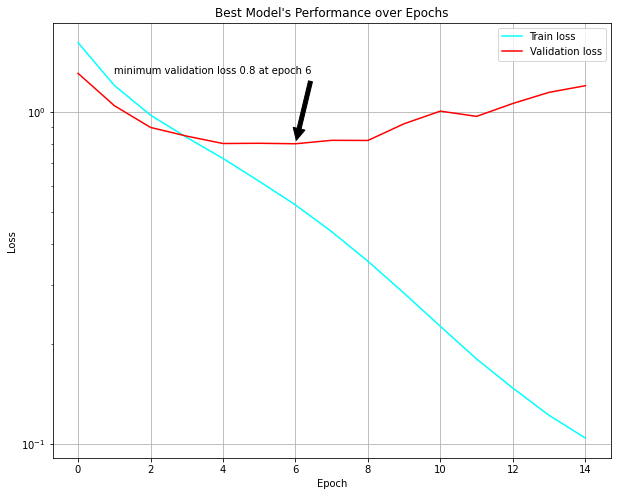

In [45]:
print("best score: ",cnn_gs.best_score_)
print("best params: ", cnn_gs.best_params_)
print("training time: ", sum(cnn_gs.best_estimator_.history[:, 'dur']))
best_cnn1 = cnn_gs.best_estimator_

# plotting training vs validation loss

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()

plt.semilogy(best_cnn1.history[:, 'train_loss'], label='Train loss', color = 'cyan')
plt.semilogy(best_cnn1.history[:, 'valid_loss'], label='Validation loss', color = 'red')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# annotating best validation loss score
ymin = min(best_cnn1.history[:, 'valid_loss'])
xpos = best_cnn1.history[:, 'valid_loss'].index(ymin)
xmin = best_cnn1.history[:, 'valid_loss'][xpos]
ax.annotate('minimum validation loss {0} at epoch {1}'.format(str(round(ymin, 2)), str(xpos)),
            xy = (xpos, ymin), xytext = (xpos - 5, ymin + 0.5), arrowprops=dict(facecolor='black', shrink=0.05))


plt.title("Best Model's Performance over Epochs")
plt.grid()
plt.legend()
plt.show()      


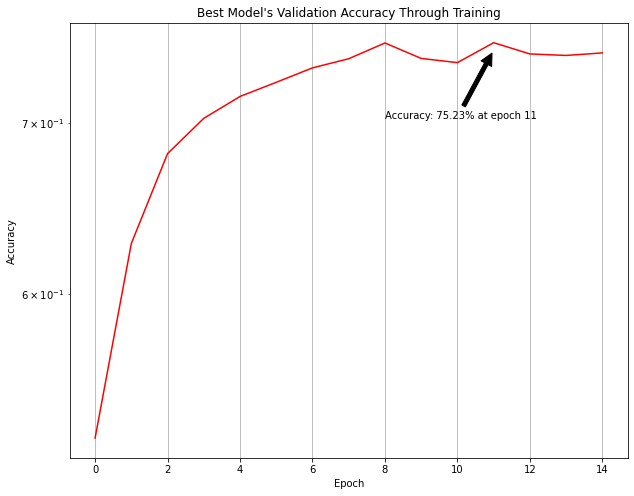

In [49]:
# annotating code aided with: https://stackoverflow.com/questions/43374920/how-to-automatically-annotate-maximum-value-in-pyplot

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()

plt.semilogy(best_cnn1.history[:, 'valid_acc'], color = 'r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

ymax = max(best_cnn1.history[:, 'valid_acc'])
xpos = best_cnn1.history[:, 'valid_acc'].index(ymax)
xmin = best_cnn1.history[:, 'valid_acc'][xpos]
ax.annotate('Accuracy: {0}% at epoch {1}'.format(str(round(ymax * 100, 2)), str(xpos)),
            xy = (xpos, ymax - 0.005), xytext = (xpos - 3, ymax-0.05), arrowprops=dict(facecolor='black', shrink=0.05))


plt.title("Best Model's Validation Accuracy Through Training")
plt.grid()
plt.show()    

## 4 convolutional layers

In [82]:
# convolutional neural network (CNN): base archictecture, which was the experimented with - taken from:
# https://medium.com/swlh/image-classification-with-cnn-4f2a501faadb

class cnn(nn.Module):
    def __init__(self, 
                dropout = dropout,
                conv1 = conv1, 
                conv2 = conv2,
                conv3 = conv3,
                dense1 = dense1,
                dense2 = dense2,
                stride1 = stride1,
                padding1 = padding1,
                stride2 = stride2,
                padding2 = padding2):
        super(cnn, self).__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size=3, stride = 1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace = True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16: 

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace = True),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1000), # <--- make this *8*8 if using stride of 2 at stride2
            nn.ReLU(inplace = True),
            nn.Dropout(dropout),
            nn.Linear(1000, 500),
            nn.ReLU(inplace = True),
            nn.Linear(500, 10))
        
    def forward(self, i):
        return self.network(i)

In [83]:
# defining callbacks to be input in to the skorch classifier

#from skorch import NeuralNetClassifier

earlystopping = skorch.callbacks.EarlyStopping(monitor = 'valid_acc', lower_is_better = False,
                                               patience = 5, threshold_mode = 'abs')

checkpoint = skorch.callbacks.Checkpoint(monitor = 'valid_acc_best')

# defining the classifier object


cnnskorch = NeuralNetClassifier(
        cnn,
        criterion = nn.CrossEntropyLoss,
        optimizer = torch.optim.Adam,
        batch_size = 32,
        max_epochs = 20,
        lr = lr,
        train_split = skorch.dataset.CVSplit(3),
        callbacks = [earlystopping, checkpoint]
        )

In [84]:
# fitting the cnn

best_cnn2 = cnnskorch.fit(data, yTrain)

  epoch    train_loss    valid_acc    valid_loss    cp       dur
-------  ------------  -----------  ------------  ----  --------
      1        1.6358       0.5109        1.3585     +  333.6420
      2        1.2244       0.6107        1.1020     +  391.8391
      3        1.0048       0.6607        0.9650     +  440.7749
      4        0.8500       0.6947        0.8686     +  407.6753
      5        0.7222       0.7101        0.8288     +  440.5227
      6        0.6052       0.7206        0.8311     +  478.4299
      7        0.4910       0.7142        0.8945        334.2004
      8        0.3917       0.7110        0.9980        288.4496
      9        0.3028       0.7100        1.1089        287.8812
     10        0.2280       0.7090        1.2081        290.0939
     11        0.1828       0.7371        1.0840     +  289.4355
     12        0.1365       0.7371        1.0982     +  287.2899
     13        0.1100       0.7332        1.2357        286.2034
     14        0.0863    

training time:  6681.691118955612


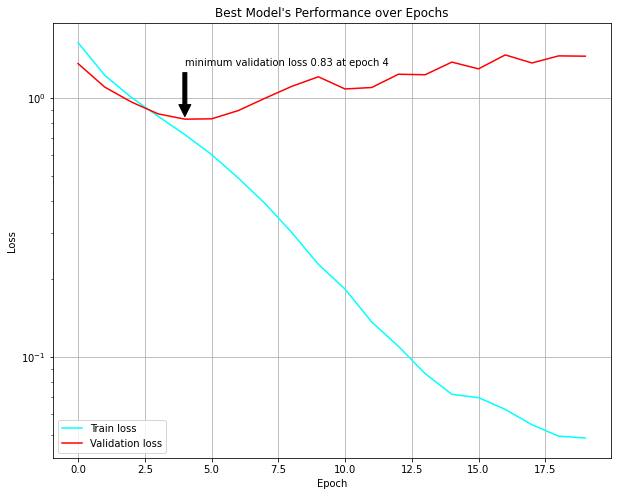

In [88]:
print("training time: ", sum(best_cnn2.history[:, 'dur']))


# plotting training vs validation loss

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()

plt.semilogy(best_cnn2.history[:, 'train_loss'], label='Train loss', color = 'cyan')
plt.semilogy(best_cnn2.history[:, 'valid_loss'], label='Validation loss', color = 'red')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# annotating best validation loss score
ymin = min(best_cnn2.history[:, 'valid_loss'])
xpos = best_cnn2.history[:, 'valid_loss'].index(ymin)
xmin = best_cnn2.history[:, 'valid_loss'][xpos]
ax.annotate('minimum validation loss {0} at epoch {1}'.format(str(round(ymin, 2)), str(xpos)),
            xy = (xpos, ymin), xytext = (xpos, ymin + 0.5), arrowprops=dict(facecolor='black', shrink=0.05))


plt.title("Best Model's Performance over Epochs")
plt.grid()
plt.legend()
plt.show()      


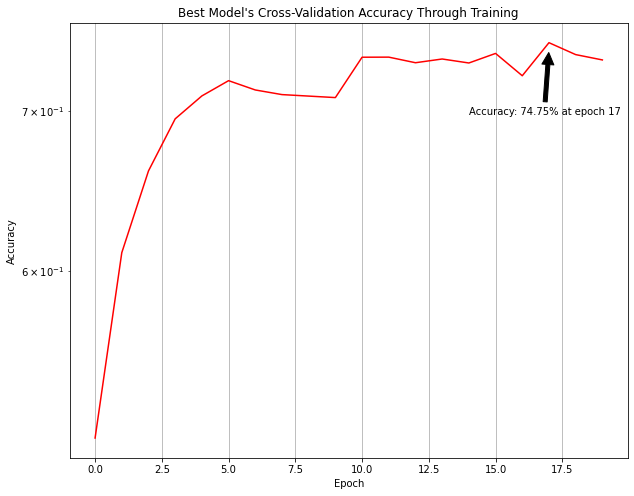

In [90]:
# annotating code aided with: https://stackoverflow.com/questions/43374920/how-to-automatically-annotate-maximum-value-in-pyplot

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()

plt.semilogy(best_cnn2.history[:, 'valid_acc'], color = 'r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

ymax = max(best_cnn2.history[:, 'valid_acc'])
xpos = best_cnn2.history[:, 'valid_acc'].index(ymax)
xmin = best_cnn2.history[:, 'valid_acc'][xpos]
ax.annotate('Accuracy: {0}% at epoch {1}'.format(str(round(ymax * 100, 2)), str(xpos)),
            xy = (xpos, ymax - 0.005), xytext = (xpos - 3, ymax-0.05), arrowprops=dict(facecolor='black', shrink=0.05))


plt.title("Best Model's Cross-Validation Accuracy Through Training")
plt.grid()
plt.show()    

## 6 convolutional layers

In [29]:
# convolutional neural network (CNN): base archictecture, which was the experimented with - taken from:
# https://medium.com/swlh/image-classification-with-cnn-4f2a501faadb

class cnn(nn.Module):
    def __init__(self, 
                dropout = dropout,
                conv1 = conv1, 
                conv2 = conv2,
                conv3 = conv3,
                dense1 = dense1,
                dense2 = dense2,
                stride1 = stride1,
                padding1 = padding1,
                stride2 = stride2,
                padding2 = padding2):
        super(cnn, self).__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, conv1, kernel_size=3, padding=1),
            nn.BatchNorm2d(conv1),
            nn.ReLU(inplace = True),
            nn.Conv2d(conv1, conv2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16: 

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace = True),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace = True),
            nn.Conv2d(512, conv3, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(conv3),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, 2), # output: 512 x 2 x 2

            nn.Flatten(), 
            nn.Linear(conv3*2*2, 1000), 
            nn.ReLU(inplace = True),
            nn.Dropout(dropout),
            nn.Linear(1000, 500),
            nn.ReLU(inplace = True),
            nn.Linear(500, 10))
        
    def forward(self, i):
        return self.network(i)

In [31]:
# defining callbacks to be input in to the skorch classifier

from skorch import NeuralNetClassifier

earlystopping = skorch.callbacks.EarlyStopping(monitor = 'valid_acc', lower_is_better = False,
                                               patience = 5, threshold_mode = 'abs')

checkpoint = skorch.callbacks.Checkpoint(monitor = 'valid_acc_best')

# defining the classifier object


cnnskorch = NeuralNetClassifier(
        cnn,
        criterion = nn.CrossEntropyLoss,
        optimizer = torch.optim.Adam,
        batch_size = 32,
        max_epochs = 25,
        lr = lr,
        train_split = skorch.dataset.CVSplit(3),
        callbacks = [earlystopping, checkpoint]
        )

In [32]:
params = {'module__conv3': [512, 1024]}

In [33]:
cnn_gs = GridSearchCV(cnnskorch, params, verbose = 1, cv = 3, scoring = 'accuracy')

In [46]:
cnn_gs.fit(xTrain2, yTrain)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  epoch    train_loss    valid_acc    valid_loss    cp       dur
-------  ------------  -----------  ------------  ----  --------
      1        1.4915       0.5541        1.2202     +  387.3441
      2        1.0313       0.5925        1.1926     +  356.1090
      3        0.7356       0.6372        1.1254     +  347.8102
      4        0.4746       0.6268        1.3568        333.3997
      5        0.3173       0.5900        1.6707        328.7066
      6        0.2236       0.6463        1.5025     +  326.7865
      7        0.1548       0.6785        1.3783     +  336.5434
      8        0.1242       0.6959        1.4072     +  330.8401
      9        0.1019       0.6958        1.5341        340.2388
     10        0.0860       0.6911        1.5953        327.6980
     11        0.0824       0.6935        1.5697        328.3211
     12        0.0726       0.7055        1.5676     +  325.9269
     13        0.0655       0.6998        1.5861        326.8946
     14        0.0733    

      6        0.2636       0.6755        1.4168     +  493.1317
      7        0.1846       0.6788        1.5097     +  498.7478
      8        0.1367       0.6773        1.5390        497.2750
      9        0.1322       0.6819        1.6484     +  491.7881
     10        0.0999       0.6819        1.6498        497.6496
     11        0.0791       0.6952        1.6667     +  492.3794
     12        0.0833       0.6824        1.8926        497.0298
     13        0.0708       0.6922        1.6504        491.3113
     14        0.0684       0.7070        1.5972     +  491.6310
     15        0.0600       0.7028        1.9680        496.5408
     16        0.0697       0.6955        1.7814        490.3232
     17        0.0509       0.6908        1.9062        490.9185
     18        0.0580       0.7125        1.6656     +  490.7110
     19        0.0502       0.7102        1.6012        495.4912
     20        0.0460       0.7153        1.5242     +  490.1249
     21        0.0426    

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 1011.2min finished


  epoch    train_loss    valid_acc    valid_loss    cp       dur
-------  ------------  -----------  ------------  ----  --------
      1        1.3638       0.6055        1.0923     +  733.2060
      2        0.8905       0.6639        0.9581     +  749.3839
      3        0.6235       0.6929        0.9584     +  749.5874
      4        0.4153       0.6968        1.0586     +  753.1679
      5        0.2821       0.7056        1.1470     +  752.0285
      6        0.1995       0.7084        1.2772     +  751.6977
      7        0.1587       0.7221        1.2033     +  751.5824
      8        0.1211       0.7229        1.2924     +  751.4923
      9        0.1080       0.7127        1.4030        754.7398
     10        0.0879       0.7217        1.2857        745.6245
     11        0.0821       0.7210        1.3663        744.2582
     12        0.0757       0.7356        1.3593     +  1084.0973
     13        0.0701       0.7430        1.2974     +  1086.1130
     14        0.0632  

GridSearchCV(cv=3,
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.cnn'>,
),
             param_grid={'module__conv3': [512, 1024]}, scoring='accuracy',
             verbose=1)

best score:  0.7021799381605071
best params:  {'module__conv3': 1024}
training time:  15020.467000722885


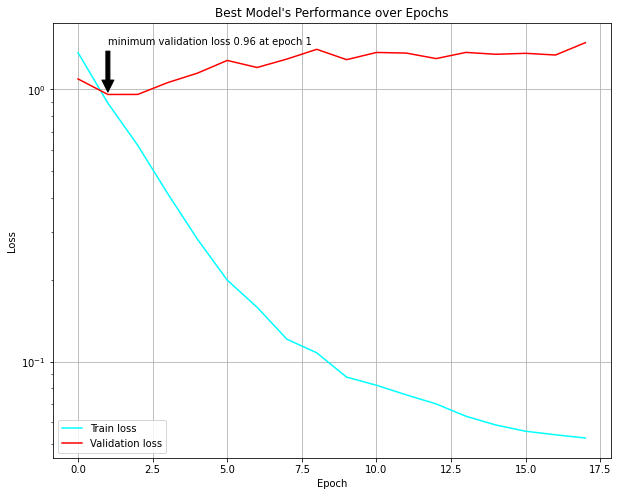

In [48]:
print("best score: ",cnn_gs.best_score_)
print("best params: ", cnn_gs.best_params_)
print("training time: ", sum(cnn_gs.best_estimator_.history[:, 'dur']))

best_cnn3 = cnn_gs.best_estimator_


# plotting training vs validation loss

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()

plt.semilogy(best_cnn3.history[:, 'train_loss'], label='Train loss', color = 'cyan')
plt.semilogy(best_cnn3.history[:, 'valid_loss'], label='Validation loss', color = 'red')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# annotating best validation loss score
ymin = min(best_cnn3.history[:, 'valid_loss'])
xpos = best_cnn3.history[:, 'valid_loss'].index(ymin)
xmin = best_cnn3.history[:, 'valid_loss'][xpos]
ax.annotate('minimum validation loss {0} at epoch {1}'.format(str(round(ymin, 2)), str(xpos)),
            xy = (xpos, ymin), xytext = (xpos, ymin + 0.5), arrowprops=dict(facecolor='black', shrink=0.05))


plt.title("Best Model's Performance over Epochs")
plt.grid()
plt.legend()
plt.show()      

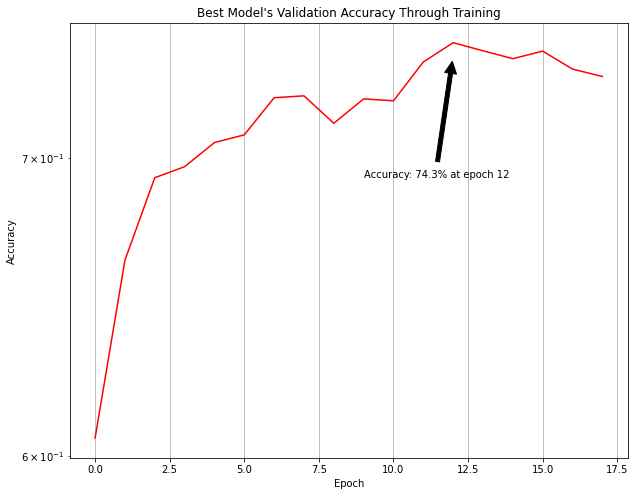

In [50]:
# annotating code aided with: https://stackoverflow.com/questions/43374920/how-to-automatically-annotate-maximum-value-in-pyplot

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()

plt.semilogy(best_cnn3.history[:, 'valid_acc'], color = 'r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

ymax = max(best_cnn3.history[:, 'valid_acc'])
xpos = best_cnn3.history[:, 'valid_acc'].index(ymax)
xmin = best_cnn3.history[:, 'valid_acc'][xpos]
ax.annotate('Accuracy: {0}% at epoch {1}'.format(str(round(ymax * 100, 2)), str(xpos)),
            xy = (xpos, ymax - 0.005), xytext = (xpos - 3, ymax-0.05), arrowprops=dict(facecolor='black', shrink=0.05))


plt.title("Best Model's Validation Accuracy Through Training")
plt.grid()
plt.show()    

The 3rd additional block of hidden layers appears to not have improved upon the validation accuracy. A couple more ad-hoc models will be trained and validated to provide clarity on which CNN architecture to select as best-performing.

### 4 layers (uniform stride)

In [51]:
# convolutional neural network (CNN): base archictecture, which was the experimented with - taken from:
# https://medium.com/swlh/image-classification-with-cnn-4f2a501faadb

class cnn(nn.Module):
    def __init__(self, 
                dropout = dropout,
                conv1 = conv1, 
                conv2 = conv2,
                conv3 = conv3,
                dense1 = dense1,
                dense2 = dense2,
                stride1 = stride1,
                padding1 = padding1,
                stride2 = stride2,
                padding2 = padding2):
        super(cnn, self).__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size=3, stride = 1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace = True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16: 

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace = True),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*8*8, 1000), # <--- make this *4*4 if using stride of 2 at stride2
            nn.ReLU(inplace = True),
            nn.Dropout(dropout),
            nn.Linear(1000, 500),
            nn.ReLU(inplace = True),
            nn.Linear(500, 10))
        
    def forward(self, i):
        return self.network(i)

In [52]:
# defining callbacks to be input in to the skorch classifier

from skorch import NeuralNetClassifier

earlystopping = skorch.callbacks.EarlyStopping(monitor = 'valid_acc', lower_is_better = False,
                                               patience = 5, threshold_mode = 'abs')

checkpoint = skorch.callbacks.Checkpoint(monitor = 'valid_acc_best')

# defining the classifier object


cnnskorch = NeuralNetClassifier(
        cnn,
        criterion = nn.CrossEntropyLoss,
        optimizer = torch.optim.Adam,
        batch_size = 32,
        max_epochs = 25,
        lr = lr,
        train_split = skorch.dataset.CVSplit(3),
        callbacks = [earlystopping, checkpoint]
        )

In [53]:
# fitting the cnn

best_cnn4 = cnnskorch.fit(data, yTrain)

  epoch    train_loss    valid_acc    valid_loss    cp       dur
-------  ------------  -----------  ------------  ----  --------
      1        1.5294       0.5631        1.2284     +  781.0808
      2        1.0898       0.6598        0.9678     +  738.0045
      3        0.8714       0.7048        0.8443     +  752.6453
      4        0.7084       0.7250        0.7998     +  762.2849
      5        0.5623       0.7307        0.8348     +  755.9666
      6        0.4270       0.7278        0.9304        759.8301
      7        0.2990       0.7421        0.9432     +  723.8008
      8        0.2048       0.7242        1.1269        721.1918
      9        0.1443       0.7491        1.0456     +  690.9909
     10        0.1112       0.7445        1.0696        695.5325
     11        0.0783       0.7596        1.1273     +  684.9323
     12        0.0640       0.7493        1.2698        692.5634
     13        0.0597       0.7419        1.3071        684.9898
     14        0.0491    

training time:  11564.520505428314


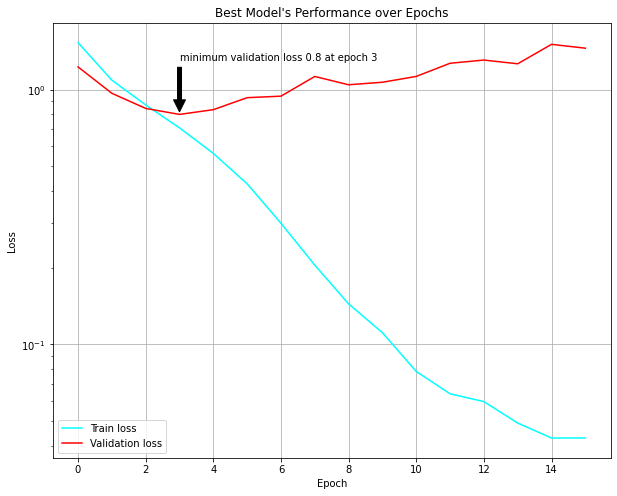

In [56]:
print("training time: ", sum(best_cnn4.history[:, 'dur']))


# plotting training vs validation loss

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()

plt.semilogy(best_cnn4.history[:, 'train_loss'], label='Train loss', color = 'cyan')
plt.semilogy(best_cnn4.history[:, 'valid_loss'], label='Validation loss', color = 'red')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# annotating best validation loss score
ymin = min(best_cnn4.history[:, 'valid_loss'])
xpos = best_cnn4.history[:, 'valid_loss'].index(ymin)
xmin = best_cnn4.history[:, 'valid_loss'][xpos]
ax.annotate('minimum validation loss {0} at epoch {1}'.format(str(round(ymin, 2)), str(xpos)),
            xy = (xpos, ymin), xytext = (xpos, ymin + 0.5), arrowprops=dict(facecolor='black', shrink=0.05))


plt.title("Best Model's Performance over Epochs")
plt.grid()
plt.legend()
plt.show()      


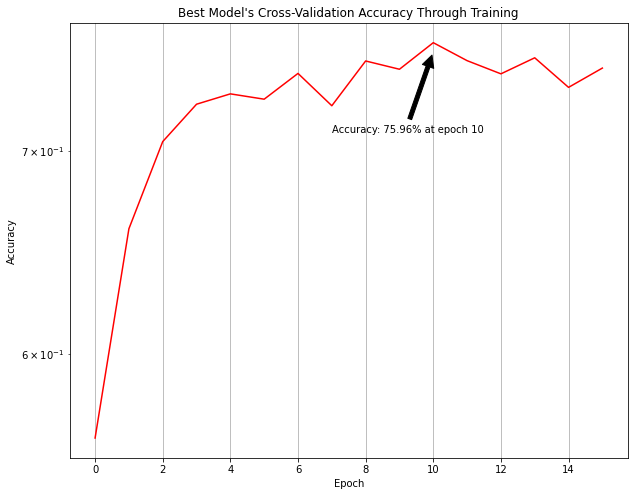

In [58]:
# annotating code aided with: https://stackoverflow.com/questions/43374920/how-to-automatically-annotate-maximum-value-in-pyplot

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()

plt.semilogy(best_cnn4.history[:, 'valid_acc'], color = 'r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

ymax = max(best_cnn4.history[:, 'valid_acc'])
xpos = best_cnn4.history[:, 'valid_acc'].index(ymax)
xmin = best_cnn4.history[:, 'valid_acc'][xpos]
ax.annotate('Accuracy: {0}% at epoch {1}'.format(str(round(ymax * 100, 2)), str(xpos)),
            xy = (xpos, ymax - 0.005), xytext = (xpos - 3, ymax-0.05), arrowprops=dict(facecolor='black', shrink=0.05))


plt.title("Best Model's Cross-Validation Accuracy Through Training")
plt.grid()
plt.show()    

In [59]:
# convolutional neural network (CNN): base archictecture, which was the experimented with - taken from:
# https://medium.com/swlh/image-classification-with-cnn-4f2a501faadb

class cnn(nn.Module):
    def __init__(self, 
                dropout = dropout,
                conv1 = conv1, 
                conv2 = conv2,
                conv3 = conv3,
                dense1 = dense1,
                dense2 = dense2,
                stride1 = stride1,
                padding1 = padding1,
                stride2 = stride2,
                padding2 = padding2):
        super(cnn, self).__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace = True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16: 

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace = True),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace = True),
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, 2), # output: 512 x 2 x 2

            nn.Flatten(), 
            nn.Linear(1024*4*4, 1000), 
            nn.ReLU(inplace = True),
            nn.Dropout(dropout),
            nn.Linear(1000, 500),
            nn.ReLU(inplace = True),
            nn.Linear(500, 10))
        
    def forward(self, i):
        return self.network(i)

In [60]:
# defining callbacks to be input in to the skorch classifier

from skorch import NeuralNetClassifier

earlystopping = skorch.callbacks.EarlyStopping(monitor = 'valid_acc', lower_is_better = False,
                                               patience = 5, threshold_mode = 'abs')

checkpoint = skorch.callbacks.Checkpoint(monitor = 'valid_acc_best')

# defining the classifier object


cnnskorch = NeuralNetClassifier(
        cnn,
        criterion = nn.CrossEntropyLoss,
        optimizer = torch.optim.Adam,
        batch_size = 32,
        max_epochs = 25,
        lr = lr,
        train_split = skorch.dataset.CVSplit(3),
        callbacks = [earlystopping, checkpoint]
        )

In [61]:
# fitting the cnn

best_cnn5 = cnnskorch.fit(data, yTrain)

  epoch    train_loss    valid_acc    valid_loss    cp        dur
-------  ------------  -----------  ------------  ----  ---------
      1        1.3003       0.6146        1.0769     +  2291.9739
      2        0.8421       0.7170        0.8000     +  2418.3269
      3        0.6281       0.7314        0.7919     +  2562.9138
      4        0.4489       0.7269        0.8922        2427.8041
      5        0.3142       0.7286        0.9819        2062.6456
      6        0.2318       0.7371        1.0605     +  2032.1777
      7        0.1761       0.7694        0.9390     +  2028.1543
      8        0.1408       0.7802        0.9910     +  2028.6170
      9        0.1144       0.7660        1.1649        2012.7222
     10        0.0961       0.7801        1.0319        2157.0996
     11        0.0829       0.7763        1.0626        2299.9891
     12        0.0812       0.7589        1.2174        3201.8283
     13        0.0703       0.7912        1.0044     +  3055.9185
     14   

training time:  56291.1304063797


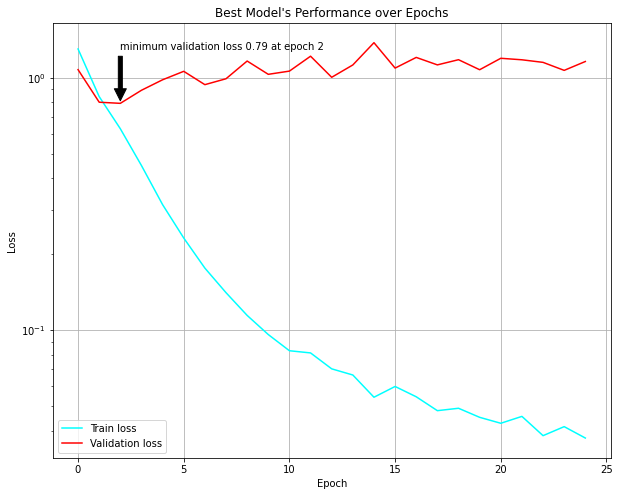

In [62]:
print("training time: ", sum(best_cnn5.history[:, 'dur']))


# plotting training vs validation loss

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()

plt.semilogy(best_cnn5.history[:, 'train_loss'], label='Train loss', color = 'cyan')
plt.semilogy(best_cnn5.history[:, 'valid_loss'], label='Validation loss', color = 'red')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# annotating best validation loss score
ymin = min(best_cnn5.history[:, 'valid_loss'])
xpos = best_cnn5.history[:, 'valid_loss'].index(ymin)
xmin = best_cnn5.history[:, 'valid_loss'][xpos]
ax.annotate('minimum validation loss {0} at epoch {1}'.format(str(round(ymin, 2)), str(xpos)),
            xy = (xpos, ymin), xytext = (xpos, ymin + 0.5), arrowprops=dict(facecolor='black', shrink=0.05))


plt.title("Best Model's Performance over Epochs")
plt.grid()
plt.legend()
plt.show()      


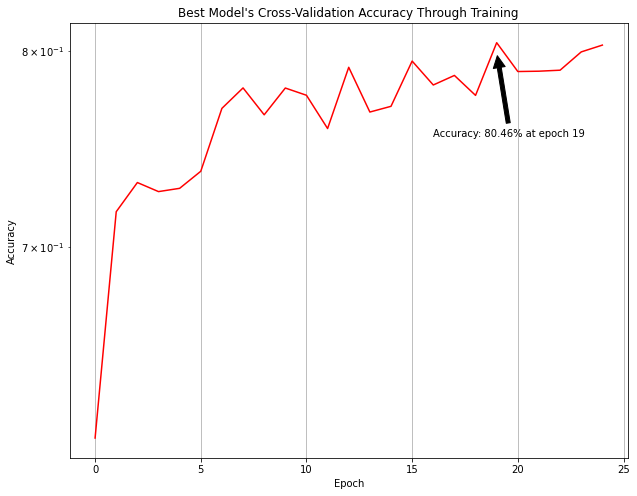

In [63]:
# annotating code aided with: https://stackoverflow.com/questions/43374920/how-to-automatically-annotate-maximum-value-in-pyplot

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()

plt.semilogy(best_cnn5.history[:, 'valid_acc'], color = 'r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

ymax = max(best_cnn5.history[:, 'valid_acc'])
xpos = best_cnn5.history[:, 'valid_acc'].index(ymax)
xmin = best_cnn5.history[:, 'valid_acc'][xpos]
ax.annotate('Accuracy: {0}% at epoch {1}'.format(str(round(ymax * 100, 2)), str(xpos)),
            xy = (xpos, ymax - 0.005), xytext = (xpos - 3, ymax-0.05), arrowprops=dict(facecolor='black', shrink=0.05))


plt.title("Best Model's Cross-Validation Accuracy Through Training")
plt.grid()
plt.show()    

After the preceding results on the cross-validation stage, the optimum parameters for an CNN were found to be:

> __Hidden Layers: 6 (growing in number of nodes across the network), dropout: 0.2, learning rate: 0.0001, optimizer: Adam, with two fully connected layers at the end, and interspersed with Relu activation layers, batch normalisation layers, as well as using max pooling layers to reduce the proportions of the filters over the network.__

In [64]:
best_cnn = best_cnn5

In [65]:
type(best_cnn)

skorch.classifier.NeuralNetClassifier

In [66]:
best_cnn.save_params(f_params = 'cnn_mdl.pkl', f_optimizer='cnn_opt.pkl', f_history='cnn_history.json')